# Agent-Specific Evaluation Notebook of the Hybrid Reasoning Agent

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import sys
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(project_root)
from src.util.data_util import (
    get_priority_features_for_task,
    features_dict,
    get_common_feature_aliases,
)

## Setup and Configuration

In [ ]:
# Set paths to pre-processed CSVs
metadata_path = os.path.join("./notebook_output/postprocessed_data", "pulse_metadata.csv")
metrics_path = os.path.join("./notebook_output/postprocessed_data", "pulse_metrics.csv")
metrics_op_path = os.path.join("./notebook_output/postprocessed_data", "pulse_metrics_operational.csv")

# Load metadata and metrics
df_metadata = pd.read_csv(metadata_path)
print(f"Loaded metadata: {df_metadata.shape}")

# Load performance metrics with and without subgroups
df_metrics_subgroup = pd.read_csv(metrics_path)
print(f"Loaded metrics with subgroups: {df_metrics_subgroup.shape}")

df_metrics = df_metrics_subgroup[
    df_metrics_subgroup["subgroup_type"] == "Overall"
].copy()
df_metrics = df_metrics.drop(columns=["subgroup_type", "subgroup_value"])
print(f"Loaded metrics without subgroups: {df_metrics.shape}")

# Load operational metrics
df_metrics_op = pd.read_csv(metrics_op_path)
print(f"Loaded operational metrics: {df_metrics_op.shape}")


# Split all loaded dataframes into _agents and _benchmark
def split_agents_benchmark(df):
    # Always include convML and convDL
    base = df[(df["model_type"] == "convML") | (df["model_type"] == "convDL")]
    # _agents: add is_agent == True
    agents = pd.concat(
        [base, df[df["is_agent"] == True]], ignore_index=True
    ).drop_duplicates()
    # _benchmark: add is_agent == False
    benchmark = pd.concat(
        [base, df[df["is_agent"] == False]], ignore_index=True
    ).drop_duplicates()
    return agents, benchmark


# Split all loaded dataframes into _agents and _benchmark
def split_agents_benchmark_op(df):
    # Always include convML and convDL
    base = df[(df["model_type"] == "convML") | (df["model_type"] == "convDL")]
    # _agents: include convML/convDL plus all rows where is_agent is True or 'all' (as string)
    agents = pd.concat(
        [base, df[df["is_agent"].isin(["True", "all"])]], ignore_index=True
    ).drop_duplicates()
    # _benchmark: include convML/convDL plus all rows where is_agent is False or 'all' (as string)
    benchmark = pd.concat(
        [base, df[df["is_agent"].isin(["False", "all"])]], ignore_index=True
    ).drop_duplicates()
    return agents, benchmark

df_metadata_agents, df_metadata_benchmark = split_agents_benchmark(df_metadata)
df_metrics_subgroup_agents, df_metrics_subgroup_benchmark = split_agents_benchmark(
    df_metrics_subgroup
)
df_metrics_agents, df_metrics_benchmark = split_agents_benchmark(df_metrics)
df_metrics_op_agents, df_metrics_op_benchmark = split_agents_benchmark_op(df_metrics_op)
# Drop specified columns from df_metrics_op_benchmark
df_metrics_op_benchmark = df_metrics_op_benchmark.drop(
    columns=[
        "avg_step_tokenization_time",
        "avg_step_inference_time",
        "avg_step_input_tokens",
        "avg_step_output_tokens",
    ],
    errors="ignore",
)

print(
    f"df_metadata_agents: {df_metadata_agents.shape}, df_metadata_benchmark: {df_metadata_benchmark.shape}"
)
print(
    f"df_metrics_subgroup_agents: {df_metrics_subgroup_agents.shape}, df_metrics_subgroup_benchmark: {df_metrics_subgroup_benchmark.shape}"
)
print(
    f"df_metrics_agents: {df_metrics_agents.shape}, df_metrics_benchmark: {df_metrics_benchmark.shape}"
)
print(
    f"df_metrics_op_agents: {df_metrics_op_agents.shape}, df_metrics_op_benchmark: {df_metrics_op_benchmark.shape}"
)

In [ ]:
# Global output directory for all visualizations
OUTPUT_BASE_DIR = os.path.join(".", "notebook_output", "pulse_agents_hybreagent")

TASK_MAPPING = {
    "mortality": ("Mortality", {"case": "#D14E70", "control": "#F0B0C0"}),  # Raspberry
    "aki": ("AKI", {"case": "#3A78B5", "control": "#A0D0F0"}),  # Blue
    "sepsis": ("Sepsis", {"case": "#F9C27B", "control": "#FFE6A7"}),  # Amber/Gold
}

DATASET_MAPPING = {
    "hirid": ("HiRID", "#793FBB"),  # Purple
    "miiv": ("MIMIC-IV", "#17AB6F"),  # Green
    "eicu": ("eICU", "#FC8D5F"),  # Orange
}
MODEL_MAPPING = {
    # convML: slightly darker, more prominent blues (light to dark)
    "RandomForest": "#c9daf6",  # light blue, slightly darker and bluer
    "XGBoost": "#4f8ad1",  # deeper blue, more saturated
    # convDL: slightly darker, more prominent greens (light to dark)
    "CNN": "#c6eedb",  # light mint green, slightly darker
    "InceptionTime": "#7fd6b1",  # medium mint green, slightly darker
    "LSTM": "#3ca97d",  # deeper green, more saturated
    "GRU": "#217a5a",  # even deeper green
    # LLMs: vivid, distinct, friendly (legend only)
    "OpenAI-o3": "#ff66c3",  # vivid magenta (first agent color in LLM_COLOR_FAMILIES)
    "Claude-Sonnet-4": "#1080e2",  # vivid blue (first agent color in LLM_COLOR_FAMILIES)
    "Grok-4": "#b44fd1",  # vivid purple (first agent color in LLM_COLOR_FAMILIES)
    "Gemini-2.5-Pro": "#8be600",  # vivid lime green (first agent color in LLM_COLOR_FAMILIES)
    "Gemini-2.5-Flash": "#ff7c1a",  # vivid gold (first agent color in LLM_COLOR_FAMILIES)
    "Llama-3.1-8B-Instruct": "#4cb0c3",  # vivid turquoise (first agent color in LLM_COLOR_FAMILIES)
    "Deepseek-R1-Distill-Llama-8B": "#ffa233",  # vivid orange (first agent color in LLM_COLOR_FAMILIES)
    "Mistral-7B-Instruct-v0.3": "#8f5ad8",  # vivid violet (first agent color in LLM_COLOR_FAMILIES)
    "Gemma-3-4B-it": "#00e699",  # vivid mint green (first agent color in LLM_COLOR_FAMILIES)
    "MedGemma-4B-it": "#c2338c",  # vivid magenta (first agent color in LLM_COLOR_FAMILIES)
}

PROMPTING_ID_MAPPING = {
    "Aggregation": "#1f77b4",  # Vivid Blue
    "Zero-Shot": "#ff7f0e",  # Vibrant Orange
    "One-Shot": "#9cf177",  # Modern Purple
    "Few-Shot (3)": "#fbe844",  # Bold Red
    "CoT": "#2ca02c",  # Fresh Green
    "SumAgent": "#ebb128",  # Playful Pink
    "ColAgent": "#b141e9",  # Lively Cyan
    "ClinFlowAgent": "#36eaab",  # Warm Brown
    "HybReAgent": "#f13636",  # Energetic Yellow-Green
}

CONVML_MODELS = ["RandomForest", "XGBoost"]
CONVDL_MODELS = ["CNN", "InceptionTime", "GRU", "LSTM"]
LLM_MODELS = [
    "OpenAI-o3",
    "Claude-Sonnet-4",
    "Grok-4",
    "Gemini-2.5-Pro",
    "Gemini-2.5-Flash",
    "Llama-3.1-8B-Instruct",
    "Deepseek-R1-Distill-Llama-8B",
    "Mistral-7B-Instruct-v0.3",
    "Gemma-3-4B-it", 
    "MedGemma-4B-it",
]

SUBGROUP_MAPPING = {
    "Sex": {"Male": "#1f4e79", "Female": "#c5282f"},  # Dark blue, Dark red
    "Age": {
        "18-65 Years": "#ddbf94",  # Light beige
        "65-75 Years": "#c19a6b",  # Medium beige
        "75-91 Years": "#8b7355",  # Dark beige
    },
    "BMI": {
        "BMI < 18.5 kg/m2": "#b8b8b8",  # Light silver
        "BMI 18.5-25 kg/m2": "#9d9d9d",  # Medium light silver
        "BMI 25-30 kg/m2": "#808080",  # Medium dark silver
        "BMI > 30 kg/m2": "#2c3539",  # Dark gunmetal
    },
}

METRICS_LIST = [
    "AUROC",
    "AUPRC",
    "Normalized AUPRC",
    "Min(+P, Se)",
    "Sensitivity (Recall)",
    "Specificity",
    "Precision",
    "F1 Score",
    "Accuracy",
    "Balanced Accuracy",
    "MCC",
    "Cohen's Kappa",
]

LLM_ALL_PROMPTING_IDS = sorted(
    x
    for x in df_metadata.loc[
        ~df_metadata["model_prompting_id"].isin(CONVML_MODELS + CONVDL_MODELS),
        "model_prompting_id",
    ].unique()
    if isinstance(x, str)
)

# Define agentic prompting methods
AGENTIC_PROMPTING_IDS = [
    "SumAgent",
    "ColAgent",
    "ClinFlowAgent",
    "HybReAgent",
]

# Define standard prompting methods
STANDARD_PROMPTING_IDS = [
    "Aggregation",
    "Zero-Shot",
    "One-Shot",
    "Few-Shot (3)",
    "CoT",
]

LLM_COLOR_FAMILIES = {
    "OpenAI-o3": {
        "standard_prompting": [
            "#fff0fa",  # 1 - very pale pink
            "#ffd6f2",  # 2 - light bubblegum
            "#ffb3e6",  # 3 - pastel bubblegum
            "#ff99db",  # 4 - soft bubblegum
            "#ff7fcf",  # 5 - bubblegum
        ],  # Pastel magenta to vivid pink
        "agents": [
            "#ff66c3",  # 6 - vivid bubblegum
            "#ff4db8",  # 7 - strong bubblegum
            "#ff33ac",  # 8 - deep bubblegum
            "#ff199f",  # 9 - deepest bubblegum
        ],  # Deeper magenta to lighter berry
    },
    "Claude-Sonnet-4": {
        "standard_prompting": [
            "#eaf6ff",
            "#b6dcff",
            "#7fc0ff",
            "#4da3ff",
            "#1987ff",
        ],  # Pastel blue to vivid azure
        "agents": [
            "#1080e2",
            "#0c6cc5",
            "#1152ad",
            "#114d83",
        ],  # Deeper blue to lighter navy
    },
    "Grok-4": {
        "standard_prompting": [
            "#fbe6ff",  # 1 - very light pink-lilac
            "#f3c2fa",  # 2 - pastel pink-lilac
            "#e6a8f7",  # 3 - soft lilac
            "#d98cf0",  # 4 - light magenta-lilac
            "#c96ae6",  # 5 - medium lilac
        ],  # Pastel lilac to vivid purple
        "agents": [
            "#b44fd1",  # 6 - vivid lilac
            "#9443c3",  # 7 - strong blue-violet
            "#7d2ca2",  # 8 - deep blue-violet
            "#61247C",  # 9 - darkest, but lighter than pure indigo
        ],  # Deeper purple to lighter violet
    },
    "Gemini-2.5-Pro": {
        "standard_prompting": [
            "#f7ffe0",  # 1 - very pale lime
            "#eaffb3",  # 2 - light lime
            "#d4ff66",  # 3 - pastel lime
            "#baff33",  # 4 - soft lime
            "#a0ff00",  # 5 - vivid lime
        ],  # Pastel green to vivid lime
        "agents": [
            "#8be600",  # 6 - lime green
            "#7acc1a",  # 7 - yellow-green
            "#6ab300",  # 8 - olive-lime
            "#5a9900",  # 9 - darkest, yellowish green
        ],  # Deeper lime/green to lighter green
    },
    "Gemini-2.5-Flash": {
        "standard_prompting": [
            "#fff4e6",  # 1 - very light orange
            "#ffd9b3",  # 2 - light peach
            "#ffc285",  # 3 - soft orange
            "#ffad5c",  # 4 - rich orange
            "#ff9800",  # 5 - vivid orange
        ],  # Pastel yellow to vivid gold
        "agents": [
            "#ff7c1a",  # 6 - deep orange
            "#ff5a36",  # 7 - orange-red
            "#e64a19",  # 8 - strong reddish orange
            "#e65c00",
        ],  # Deeper gold to lighter orange-brown
    },
    "Llama-3.1-8B-Instruct": {
        "standard_prompting": [
            "#e0ffff",  # 1 - very light aqua
            "#b3eaf2",  # 2 - lighter aqua
            "#99dbe6",  # 3 - light pastel aqua
            "#7fcddb",  # 4 - pastel aqua
            "#66becf",  # 5 - soft aqua
        ],  # Pastel aqua to vivid turquoise
        "agents": [
            "#4cb0c3",  # 6 - medium aqua
            "#3391a7",  # 7 - deeper aqua
            "#2a7c8c",  # 8 - dark teal-blue
            "#2a6a7c",  # 9 - darkest, deep blue-teal
        ],  # Deeper turquoise to lighter teal
    },
    "Deepseek-R1-Distill-Llama-8B": {
        "standard_prompting": [
            "#fff3e0",  # 1 - very light peach
            "#ffe3c2",  # 2 - light cream
            "#ffd39f",  # 3 - pale yellow-orange
            "#ffc278",  # 4 - soft yellow-orange
            "#ffb34d",  # 5 - light amber
        ],  # Pastel peach to vivid orange
        "agents": [
            "#ffa233",  # 6 - amber
            "#e88c1a",  # 7 - brownish amber
            "#c97a1a",  # 8 - brown-orange
            "#be7835",  # 9 - brown
        ],  # Deeper orange to lighter brown
    },
    "Mistral-7B-Instruct-v0.3": {
        "standard_prompting": [
            "#f6efff",  # 1 - very light lavender
            "#e3d1fa",  # 2 - pale lavender
            "#d1b3f6",  # 3 - light pastel purple
            "#be95ea",  # 4 - soft purple
            "#a97fdc",  # 5 - medium purple
        ],  # Pastel lilac to vivid violet
        "agents": [
            "#8f5ad8",  # 6 - vivid purple
            "#7a3fc7",  # 7 - strong purple
            "#6a1bb1",  # 8 - deep purple
            "#502491",  # 9 - darkest, but not black
        ],  # Deeper violet to lighter purple
    },
    "Gemma-3-4B-it": {
        "standard_prompting": [
            "#e6fff7",  # 1 - very pale blue-green
            "#b3ffe6",  # 2 - light blue-green
            "#80ffd1",  # 3 - pastel blue-green
            "#4dffbe",  # 4 - soft blue-green
            "#1affaa",  # 5 - vivid blue-green
        ],  # Pastel mint to vivid green
        "agents": [
            "#00e699",  # 6 - cool green
            "#00cc88",  # 7 - blueish green
            "#00b377",  # 8 - deep blue-green
            "#009966",  # 9 - darkest, blueish green
        ],  # Deeper mint/green to lighter green
    },
    "MedGemma-4B-it": {
        "standard_prompting": [
            "#fbe6f6",  # 1 - very pale berry
            "#f5c2e3",  # 2 - light berry
            "#ee99cc",  # 3 - pastel berry
            "#e673b8",  # 4 - soft berry
            "#d94da3",  # 5 - berry
        ],  # Pastel pink to vivid magenta
        "agents": [
            "#c2338c",  # 6 - vivid berry
            "#a61a70",  # 7 - strong berry
            "#8c005a",  # 8 - deep berry
            "#66003f",  # 9 - darkest berry
        ],  # Deeper magenta to lighter pink/purple
    },
}

# Create unified model-prompting mapping
MODEL_PROMPTING_ID_MAPPING = {}

# Add convML and convDL models (unchanged)
for model in CONVML_MODELS + CONVDL_MODELS:
    MODEL_PROMPTING_ID_MAPPING[model] = MODEL_MAPPING[model]

# Add LLM models with integrated color schemes
for model, color_family in LLM_COLOR_FAMILIES.items():
    # Assign agent colors
    for i, agent_id in enumerate(AGENTIC_PROMPTING_IDS):
        key = f"{model}, {agent_id}"
        if i < len(color_family["agents"]):
            MODEL_PROMPTING_ID_MAPPING[key] = color_family["agents"][i]
        else:
            # Fallback to cycling through available agent colors
            MODEL_PROMPTING_ID_MAPPING[key] = color_family["agents"][
                i % len(color_family["agents"])
            ]

    # Assign standard prompting colors
    for i, standard_id in enumerate(STANDARD_PROMPTING_IDS):
        key = f"{model}, {standard_id}"
        if i < len(color_family["standard_prompting"]):
            MODEL_PROMPTING_ID_MAPPING[key] = color_family["standard_prompting"][i]
        else:
            # Fallback to cycling through available standard colors
            MODEL_PROMPTING_ID_MAPPING[key] = color_family["standard_prompting"][
                i % len(color_family["standard_prompting"])
            ]

# Function to get model-specific color
def get_model_color(model):
    if model in MODEL_MAPPING:
        # Use the color defined in MODEL_MAPPING for convML/convDL models
        return MODEL_MAPPING[model]

### Agent-specific Metadata Overview

In [ ]:
# Filter df_metadata_agents to only include Hybrid Reasoning Agent
df_metadata_hra = df_metadata_agents[df_metadata_agents["prompting_id"] == "HybReAgent"].copy()
print(f"df_metadata_hra: {df_metadata_hra.shape}")

# Delete columns that have only missing values
columns_before = df_metadata_hra.shape[1]
df_metadata_hra = df_metadata_hra.dropna(axis=1, how='all')
columns_after = df_metadata_hra.shape[1]
print(f"Removed {columns_before - columns_after} columns with only missing values")
print(f"df_metadata_hra after cleanup: {df_metadata_hra.shape}")

# Comprehensive analysis of df_metadata_hra characteristics
print("=" * 80)
print("COMPREHENSIVE SUMMARY OF HYBRID REASONING AGENT METADATA")
print("=" * 80)

# Basic shape and structure
print(f"\n1. DATASET OVERVIEW")
print(f"   Shape: {df_metadata_hra.shape[0]} rows × {df_metadata_hra.shape[1]} columns")
print(f"   Total experiments: {len(df_metadata_hra)}")

# Column information
print(f"\n2. AVAILABLE COLUMNS")
print(f"   Columns: {list(df_metadata_hra.columns)}")

# Model distribution
print(f"\n3. MODEL DISTRIBUTION")
if 'model' in df_metadata_hra.columns:
    model_counts = df_metadata_hra['model'].value_counts()
    print(f"   Models tested: {len(model_counts)} unique models")
    for model, count in model_counts.items():
        print(f"   - {model}: {count} rows")
else:
    print("   No 'model' column found")

# Task distribution
print(f"\n4. TASK DISTRIBUTION")
if 'task' in df_metadata_hra.columns:
    task_counts = df_metadata_hra['task'].value_counts()
    print(f"   Tasks evaluated: {len(task_counts)} unique tasks")
    for task, count in task_counts.items():
        print(f"   - {task}: {count} rows")
else:
    print("   No 'task' column found")

# Dataset distribution
print(f"\n5. DATASET DISTRIBUTION")
if 'dataset' in df_metadata_hra.columns:
    dataset_counts = df_metadata_hra['dataset'].value_counts()
    print(f"   Datasets used: {len(dataset_counts)} unique datasets")
    for dataset, count in dataset_counts.items():
        print(f"   - {dataset}: {count} rows")
else:
    print("   No 'dataset' column found")

# Model type distribution
print(f"\n6. MODEL TYPE DISTRIBUTION")
if 'model_type' in df_metadata_hra.columns:
    model_type_counts = df_metadata_hra['model_type'].value_counts()
    print(f"   Model types: {len(model_type_counts)} unique types")
    for model_type, count in model_type_counts.items():
        print(f"   - {model_type}: {count} experiments")
else:
    print("   No 'model_type' column found")

# Prompting ID verification
print(f"\n7. PROMPTING METHOD VERIFICATION")
if 'prompting_id' in df_metadata_hra.columns:
    prompting_counts = df_metadata_hra['prompting_id'].value_counts()
    print(f"   Prompting methods: {len(prompting_counts)} unique methods")
    for prompting, count in prompting_counts.items():
        print(f"   - {prompting}: {count} experiments")
else:
    print("   No 'prompting_id' column found")

# Agent verification
print(f"\n8. AGENT STATUS VERIFICATION")
if 'is_agent' in df_metadata_hra.columns:
    agent_counts = df_metadata_hra['is_agent'].value_counts()
    print(f"   Agent status distribution:")
    for status, count in agent_counts.items():
        print(f"   - is_agent={status}: {count} experiments")
else:
    print("   No 'is_agent' column found")

# Cross-tabulation analysis
print(f"\n9. CROSS-TABULATION ANALYSIS")
if all(col in df_metadata_hra.columns for col in ['model', 'task', 'dataset']):
    print(f"   Model × Task × Dataset combinations:")
    cross_tab = df_metadata_hra.groupby(['model', 'task', 'dataset']).size().reset_index(name='count')
    print(f"   Total unique combinations: {len(cross_tab)}")
    
    # Show coverage matrix
    print(f"\n   Coverage by Task and Dataset:")
    coverage = df_metadata_hra.pivot_table(
        index='task', 
        columns='dataset', 
        values='model', 
        aggfunc='count', 
        fill_value=0
    )
    print(coverage)
    
    print(f"\n   Coverage by Model and Task:")
    model_task_coverage = df_metadata_hra.pivot_table(
        index='model', 
        columns='task', 
        values='dataset', 
        aggfunc='count', 
        fill_value=0
    )
    print(model_task_coverage)

# Model-prompting ID combinations
print(f"\n10. MODEL-PROMPTING COMBINATIONS")
if 'model_prompting_id' in df_metadata_hra.columns:
    model_prompting_counts = df_metadata_hra['model_prompting_id'].value_counts()
    print(f"    Unique model-prompting combinations: {len(model_prompting_counts)}")
    for combo, count in model_prompting_counts.items():
        print(f"    - {combo}: {count} experiments")

# Temporal information (if available)
print(f"\n11. TEMPORAL INFORMATION")
time_columns = [col for col in df_metadata_hra.columns if any(keyword in col.lower() for keyword in ['time', 'date', 'duration', 'created'])]
if time_columns:
    print(f"    Time-related columns found: {time_columns}")
    for col in time_columns:
        if df_metadata_hra[col].dtype in ['datetime64[ns]', 'object']:
            try:
                # Try to convert to datetime if not already
                temp_series = pd.to_datetime(df_metadata_hra[col], errors='coerce')
                if not temp_series.isna().all():
                    print(f"    - {col}: {temp_series.min()} to {temp_series.max()}")
            except:
                print(f"    - {col}: Unable to parse as datetime")
        else:
            print(f"    - {col}: {df_metadata_hra[col].describe()}")
else:
    print("    No time-related columns found")

# Configuration and parameter information
print(f"\n12. CONFIGURATION PARAMETERS")
config_columns = [col for col in df_metadata_hra.columns if any(keyword in col.lower() for keyword in ['config', 'param', 'setting', 'seed', 'temperature', 'max_tokens'])]
if config_columns:
    print(f"    Configuration columns found: {config_columns}")
    for col in config_columns:
        unique_vals = df_metadata_hra[col].nunique()
        if unique_vals <= 10:  # Show all values if few unique
            print(f"    - {col}: {sorted(df_metadata_hra[col].unique())}")
        else:
            print(f"    - {col}: {unique_vals} unique values, range: {df_metadata_hra[col].min()} to {df_metadata_hra[col].max()}")
else:
    print("    No configuration-related columns found")

# File and path information
print(f"\n13. FILE AND PATH INFORMATION")
path_columns = [col for col in df_metadata_hra.columns if any(keyword in col.lower() for keyword in ['path', 'file', 'dir', 'output'])]
if path_columns:
    print(f"    Path-related columns found: {path_columns}")
    for col in path_columns:
        unique_count = df_metadata_hra[col].nunique()
        print(f"    - {col}: {unique_count} unique paths")
        if unique_count <= 5:  # Show examples for few paths
            print(f"      Examples: {list(df_metadata_hra[col].unique()[:3])}")
else:
    print("    No path-related columns found")

# Missing data analysis
print(f"\n14. DATA COMPLETENESS ANALYSIS")
missing_data = df_metadata_hra.isnull().sum()
missing_percentage = (missing_data / len(df_metadata_hra)) * 100
print(f"    Columns with missing data:")
for col, missing_count in missing_data[missing_data > 0].items():
    print(f"    - {col}: {missing_count} missing ({missing_percentage[col]:.1f}%)")
if missing_data.sum() == 0:
    print("    No missing data found - dataset is complete!")

# Sample data preview
print(f"\n15. SAMPLE DATA PREVIEW")
print("    First 3 rows:")
print(df_metadata_hra.head(3).to_string())

# Data types
print(f"\n16. DATA TYPES")
print("    Column data types:")
for col, dtype in df_metadata_hra.dtypes.items():
    print(f"    - {col}: {dtype}")

# Statistical summary for numerical columns
print(f"\n17. NUMERICAL COLUMNS SUMMARY")
numerical_cols = df_metadata_hra.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 0:
    print("    Numerical columns statistics:")
    print(df_metadata_hra[numerical_cols].describe())
else:
    print("    No numerical columns found")

print(f"\n" + "=" * 80)
print("SUMMARY COMPLETE - Ready for detailed agent evaluation analysis")
print("=" * 80)

df_metadata_hra: (268760, 96)
Removed 35 columns with only missing values
df_metadata_hra after cleanup: (268760, 61)
COMPREHENSIVE SUMMARY OF HYBRID REASONING AGENT METADATA

1. DATASET OVERVIEW
   Shape: 268760 rows × 61 columns
   Total experiments: 268760

2. AVAILABLE COLUMNS
   Columns: ['model_type', 'model_name', 'is_agent', 'prompting_id', 'task', 'dataset', 'sample_index', 'original_row_index', 'sex', 'age', 'height', 'weight', 'probabilities', 'prediction', 'label', 'Sample ID', 'Step Name', 'Step Number', 'Target Label', 'metadata_patient_age', 'metadata_patient_sex', 'metadata_patient_weight', 'metadata_patient_height', 'metadata_monitoring_hours', 'metadata_total_features_available', 'metadata_data_completeness_score', 'metadata_imputation_percentage', 'metadata_agent_type', 'metadata_sample_start_time', 'System Message', 'Input Prompt', 'Output', 'Predicted Probability', 'Predicted Diagnosis', 'Predicted Explanation', 'Confidence', 'Tokenization Time', 'Inference Time', 

/var/folders/r1/8n2p36gx2ydfw7wf826zxyh00000gn/T/ipykernel_47454/2349610896.py:131: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_series = pd.to_datetime(df_metadata_hra[col], errors='coerce')


    - source_file: 90 unique paths
    - source_file.1: 90 unique paths

14. DATA COMPLETENESS ANALYSIS
    Columns with missing data:
    - probabilities: 61891 missing (23.0%)
    - prediction: 61891 missing (23.0%)
    - metadata_patient_age: 206870 missing (77.0%)
    - metadata_patient_sex: 206870 missing (77.0%)
    - metadata_patient_weight: 206870 missing (77.0%)
    - metadata_patient_height: 206870 missing (77.0%)
    - metadata_monitoring_hours: 206870 missing (77.0%)
    - metadata_total_features_available: 1 missing (0.0%)
    - metadata_data_completeness_score: 1 missing (0.0%)
    - metadata_imputation_percentage: 206870 missing (77.0%)
    - metadata_agent_type: 206870 missing (77.0%)
    - metadata_sample_start_time: 206870 missing (77.0%)
    - Input Prompt: 61890 missing (23.0%)
    - Output: 61890 missing (23.0%)
    - Predicted Probability: 61891 missing (23.0%)
    - Predicted Diagnosis: 61891 missing (23.0%)
    - Predicted Explanation: 61891 missing (23.0%)
    

# Evaluation and Validation of Hybrid Reasoning Agent Behaviour

In [ ]:
# Create output directory
os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)
print(f"Analysis output directory: {OUTPUT_BASE_DIR}")

# Data preprocessing for analysis
print("\n" + "="*80)
print("DATA PREPROCESSING FOR HYBRID REASONING AGENT ANALYSIS") 
print("="*80)

# Clean and prepare the data
df_hra_clean = df_metadata_hra.copy()

# Convert Confidence column to numeric (handle different formats)
def convert_confidence_to_numeric(conf_val):
    """Convert confidence values to numeric, handling various formats."""
    if pd.isna(conf_val):
        return np.nan
    if isinstance(conf_val, (int, float)):
        return float(conf_val)
    if isinstance(conf_val, str):
        # Try to extract numeric value from string
        try:
            # Handle JSON-like strings or plain numbers
            import re
            numbers = re.findall(r'\d+(?:\.\d+)?', str(conf_val))
            if numbers:
                return float(numbers[0])
        except:
            pass
    return np.nan

df_hra_clean['Confidence_numeric'] = df_hra_clean['Confidence'].apply(convert_confidence_to_numeric)

# Add step type categorization
def categorize_step(step_name):
    """Categorize steps for analysis."""
    if pd.isna(step_name):
        return "Unknown"
    step_name = str(step_name).lower()
    if "metadata" in step_name:
        return "Sample Metadata"
    elif "ml_interpretation" in step_name:
        return "ML Interpretation" 
    elif "clinical_assessment" in step_name:
        return "Clinical Assessment"
    elif "detailed_investigation" in step_name:
        return "Detailed Investigation"
    elif "final_prediction" in step_name:
        return "Final Prediction"
    else:
        return "Other"

df_hra_clean['Step_Category'] = df_hra_clean['Step Name'].apply(categorize_step)

# Basic step analysis
print(f"\nStep distribution:")
step_counts = df_hra_clean['Step_Category'].value_counts()
for step, count in step_counts.items():
    percentage = (count / len(df_hra_clean)) * 100
    print(f"  {step}: {count:,} ({percentage:.1f}%)")

print(f"\nModel distribution in HRA data:")
model_counts = df_hra_clean['model_name'].value_counts()
for model, count in model_counts.items():
    percentage = (count / len(df_hra_clean)) * 100
    print(f"  {model}: {count:,} ({percentage:.1f}%)")

print(f"\nTask-Dataset distribution:")
task_dataset_counts = df_hra_clean.groupby(['task', 'dataset']).size().sort_values(ascending=False)
for (task, dataset), count in task_dataset_counts.items():
    percentage = (count / len(df_hra_clean)) * 100
    print(f"  {task}-{dataset}: {count:,} ({percentage:.1f}%)")

print(f"\nData cleaning summary:")
print(f"  Original shape: {df_metadata_hra.shape}")
print(f"  Cleaned shape (adding numeric confidence column and standardized step categories): {df_hra_clean.shape}")
print(f"  Confidence values converted: {df_hra_clean['Confidence_numeric'].notna().sum():,}")
print(f"  Steps categorized: {df_hra_clean['Step_Category'].notna().sum():,}")

Analysis output directory: ./notebook_output/pulse_agents_hybreagent

DATA PREPROCESSING FOR HYBRID REASONING AGENT ANALYSIS

Step distribution:
  Sample Metadata: 61,890 (23.0%)
  ML Interpretation: 61,890 (23.0%)
  Clinical Assessment: 61,889 (23.0%)
  Final Prediction: 61,889 (23.0%)
  Detailed Investigation: 21,202 (7.9%)

Model distribution in HRA data:
  Gemma-3-4B-it: 28,129 (10.5%)
  Gemini-2.5-Pro: 27,392 (10.2%)
  Llama-3.1-8B-Instruct: 26,923 (10.0%)
  Gemini-2.5-Flash: 26,823 (10.0%)
  Deepseek-R1-Distill-Llama-8B: 26,778 (10.0%)
  Claude-Sonnet-4: 26,630 (9.9%)
  MedGemma-4B-it: 26,608 (9.9%)
  Grok-4: 26,511 (9.9%)
  Mistral-7B-Instruct-v0.3: 26,494 (9.9%)
  OpenAI-o3: 26,472 (9.8%)

Task-Dataset distribution:
  AKI-MIMIC-IV: 45,733 (17.0%)
  AKI-eICU: 45,542 (16.9%)
  AKI-HiRID: 43,278 (16.1%)
  Sepsis-HiRID: 40,917 (15.2%)
  Sepsis-eICU: 40,286 (15.0%)
  Sepsis-MIMIC-IV: 40,134 (14.9%)
  Mortality-HiRID: 4,359 (1.6%)
  Mortality-MIMIC-IV: 4,264 (1.6%)
  Mortality-eICU: 

## 1. Step-by-Step Reasoning Analysis

This section analyzes how the Hybrid Reasoning Agent progresses through its 4-step workflow and how predictions evolve across steps.

In [ ]:
# Step Evolution Analysis
print("\n" + "="*80)
print("STEP EVOLUTION AND PREDICTION FLOW ANALYSIS")
print("="*80)

# First, let's check for duplicate final prediction steps
final_steps = df_hra_clean[df_hra_clean['Step_Category'] == 'Final Prediction'].copy()
print(f"Total final prediction steps: {len(final_steps):,}")

# Check for duplicates in final steps
final_duplicates = final_steps.duplicated(subset=['sample_index', 'task', 'dataset', 'model_name'])
if final_duplicates.any():
    print(f"WARNING: Found {final_duplicates.sum():,} duplicate final prediction steps!")
    print("Removing duplicate final prediction steps...")
    final_steps = final_steps.drop_duplicates(subset=['sample_index', 'task', 'dataset', 'model_name'])
    print(f"After removing duplicates: {len(final_steps):,}")

# Comprehensive data cleaning function
def clean_boolean_value(value):
    """Convert various boolean formats to consistent True/False/None."""
    if pd.isna(value):
        return None
    if isinstance(value, bool):
        return value
    if isinstance(value, str):
        value_lower = value.lower().strip()
        if value_lower in ['true', '1', 'yes', 'y']:
            return True
        elif value_lower in ['false', '0', 'no', 'n']:
            return False
        else:
            return None
    if isinstance(value, (int, float)):
        if value == 1:
            return True
        elif value == 0:
            return False
        else:
            return None
    return None

def clean_agreement_value(value):
    """Clean agreement values to remove malformed characters."""
    if pd.isna(value):
        return None
    if isinstance(value, str):
        # Remove malformed characters like } and clean whitespace
        cleaned = value.strip().rstrip('}').strip()
        if cleaned.lower() in ['agree', 'partial', 'disagree', 'partially agree', 'partially disagree']:
            return cleaned.lower()
        else:
            return 'malformed'
    return str(value)

# Create sample-level dataset for tracking prediction evolution
def create_sample_level_data():
    """Create sample-level dataset to track prediction evolution across steps."""
    sample_evolution = []
    skipped_samples = 0
    
    print(f"Processing {len(final_steps):,} unique final prediction steps...")
    
    for _, final_row in final_steps.iterrows():
        sample_idx = final_row['sample_index']
        task = final_row['task']
        dataset = final_row['dataset']
        model = final_row['model_name']
        label = final_row['label']
        
        # Get all steps for this sample
        sample_steps = df_hra_clean[
            (df_hra_clean['sample_index'] == sample_idx) &
            (df_hra_clean['task'] == task) &
            (df_hra_clean['dataset'] == dataset) &
            (df_hra_clean['model_name'] == model)
        ].copy()
        
        if len(sample_steps) == 0:
            skipped_samples += 1
            continue
            
        # Initialize sample record
        sample_record = {
            'sample_index': sample_idx,
            'task': task,
            'dataset': dataset,
            'model': model,
            'label': label,
            'model_prompting_id': final_row['model_prompting_id']
        }
        
        # Extract data from each step - use the first occurrence of each step type
        step_data = {}
        for _, step in sample_steps.iterrows():
            step_cat = step['Step_Category']
            
            # Only process if we haven't seen this step category yet (avoid duplicates)
            if step_cat not in step_data:
                step_data[step_cat] = step
        
        # Extract metadata from Sample Metadata step
        if 'Sample Metadata' in step_data:
            step = step_data['Sample Metadata']
            sample_record.update({
                'metadata_ml_prediction': step['metadata_ml_prediction'],
                'metadata_ml_confidence': step['metadata_ml_confidence'],
                'metadata_total_features': step['metadata_total_features_available'],
                'metadata_completeness': step['metadata_data_completeness_score'],
                'patient_age': step['age'],
                'patient_sex': step['sex']
            })
                
        # Extract data from ML Interpretation step
        if 'ML Interpretation' in step_data:
            step = step_data['ML Interpretation']
            # Get ML prediction probability (convert from 0-100 to 0-1 scale)
            ml_pred_prob = step['metadata_ml_prediction'] / 100.0 if pd.notna(step['metadata_ml_prediction']) else None
            
            # Get step 1 prediction and handle scale conversion
            step1_pred = step['probabilities']
            # If step1_prediction is > 1, it's likely on 0-100 scale and needs conversion
            if pd.notna(step1_pred) and step1_pred > 1.0:
                step1_pred = step1_pred / 100.0
            
            sample_record.update({
                'step0_ml_prediction': ml_pred_prob,  # XGBoost raw prediction (Step 0)
                'step1_prediction': step1_pred,  # Agent interpretation (Step 1) - scale corrected
                'step1_confidence': step['Confidence_numeric'],
                'step1_ml_prediction': step['metadata_ml_prediction'],
                'step1_ml_confidence': step['metadata_ml_confidence']
            })
                
        # Extract data from Clinical Assessment step
        if 'Clinical Assessment' in step_data:
            step = step_data['Clinical Assessment']
            
            # Get step 2 prediction and handle scale conversion
            step2_pred = step['probabilities']
            # If step2_prediction is > 1, it's likely on 0-100 scale and needs conversion
            if pd.notna(step2_pred) and step2_pred > 1.0:
                step2_pred = step2_pred / 100.0
            
            sample_record.update({
                'step2_prediction': step2_pred,  # Agent clinical assessment (Step 2) - scale corrected
                'step2_confidence': step['Confidence_numeric'],
                'ml_vs_clinical_diff': step['metadata_ml_vs_clinical_diff'],
                'ai_agreement': clean_agreement_value(step['metadata_ai_agreement']),  # Clean agreement
                'ml_confidence_adequate': clean_boolean_value(step['metadata_ml_confidence_adequate'])  # Clean boolean
            })
                
        # Extract data from Detailed Investigation step (if exists)
        if 'Detailed Investigation' in step_data:
            step = step_data['Detailed Investigation']
            
            # Get step 3 prediction and handle scale conversion
            step3_pred = step['probabilities']
            # If step3_prediction is > 1, it's likely on 0-100 scale and needs conversion
            if pd.notna(step3_pred) and step3_pred > 1.0:
                step3_pred = step3_pred / 100.0
            
            sample_record.update({
                'step3_prediction': step3_pred,  # Agent detailed investigation (Step 3) - scale corrected
                'step3_confidence': step['Confidence_numeric'],
                'investigation_triggered': clean_boolean_value(step['metadata_investigation_triggered']),  # Clean boolean
                'high_disagreement': clean_boolean_value(step['metadata_high_disagreement']),  # Clean boolean
                'ml_confidence_low': clean_boolean_value(step['metadata_ml_confidence_low'])  # Clean boolean
            })
        else:
            # Investigation was not triggered
            sample_record.update({
                'step3_prediction': None,
                'step3_confidence': None,
                'investigation_triggered': False,
                'high_disagreement': None,
                'ml_confidence_low': None
            })
                
        # Extract data from Final Prediction step
        if 'Final Prediction' in step_data:
            step = step_data['Final Prediction']
            sample_record.update({
                'final_prediction': step['probabilities'],
                'objective_synthesis': step['metadata_objective_synthesis'],
                'dampened_clinical': step['metadata_dampened_clinical'],
                'dampening_applied': clean_boolean_value(step['metadata_dampening_applied']),  # Clean boolean
                'original_clinical': step['metadata_original_clinical']
            })
        
        sample_evolution.append(sample_record)
    
    print(f"Skipped {skipped_samples:,} samples due to missing step data")
    return pd.DataFrame(sample_evolution)

# Create sample-level dataset
print("Creating sample-level evolution dataset...")
df_sample_evolution = create_sample_level_data()
print(f"Sample evolution dataset: {df_sample_evolution.shape}")

# Additional post-creation data cleaning to ensure consistency
print("Applying additional data cleaning...")

# Clean boolean columns that might still have mixed formats
boolean_columns = ['investigation_triggered', 'dampening_applied', 'ml_confidence_adequate', 'high_disagreement', 'ml_confidence_low']
for col in boolean_columns:
    if col in df_sample_evolution.columns:
        df_sample_evolution[col] = df_sample_evolution[col].apply(clean_boolean_value)

# Clean agreement column
if 'ai_agreement' in df_sample_evolution.columns:
    df_sample_evolution['ai_agreement'] = df_sample_evolution['ai_agreement'].apply(clean_agreement_value)

# Check for any remaining duplicates
print(f"Checking for duplicate samples in evolution dataset...")
duplicates = df_sample_evolution.duplicated(subset=['sample_index', 'task', 'dataset', 'model'])
if duplicates.any():
    print(f"WARNING: Found {duplicates.sum():,} duplicate samples! Removing duplicates...")
    df_sample_evolution = df_sample_evolution.drop_duplicates(subset=['sample_index', 'task', 'dataset', 'model'])
    print(f"After removing duplicates: {df_sample_evolution.shape}")

# Basic statistics
total_samples = len(df_sample_evolution)
print(f"\nTotal unique completed agent workflows: {total_samples:,}")

# Distribution by task-dataset-model
task_dataset_model_dist = df_sample_evolution.groupby(['task', 'dataset', 'model']).size().reset_index(name='count')
print(f"\nTask-Dataset-Model distribution:")
for _, row in task_dataset_model_dist.iterrows():
    percentage = (row['count'] / total_samples) * 100
    print(f"  {row['task']}-{row['dataset']}-{row['model']}: {row['count']:,} ({percentage:.1f}%)")


def correct_prediction_scales_inplace(df):
    """
    For each prediction column except final_prediction, divide by 100 if value is exactly 1.0.
    Modifies columns in-place.
    """
    prediction_cols = [
        "step0_ml_prediction",
        "step1_prediction",
        "step2_prediction",
        "step3_prediction",
    ]
    for col in prediction_cols:
        if col in df.columns:
            df[col] = df[col].apply(
                lambda v: v / 100 if pd.notna(v) and float(v) == 1.0 else v
            )
    # For final_prediction, leave as is


# Apply correction of prediction scales (ml interpretation step had parsing issues, but the values were not used for subsequent steps)
correct_prediction_scales_inplace(df_sample_evolution)


STEP EVOLUTION AND PREDICTION FLOW ANALYSIS
Total final prediction steps: 61,889
Creating sample-level evolution dataset...
Processing 61,889 unique final prediction steps...
Skipped 0 samples due to missing step data
Sample evolution dataset: (61889, 32)
Applying additional data cleaning...
Checking for duplicate samples in evolution dataset...

Total unique completed agent workflows: 61,889

Task-Dataset-Model distribution:
  AKI-HiRID-Claude-Sonnet-4: 982 (1.6%)
  AKI-HiRID-Deepseek-R1-Distill-Llama-8B: 982 (1.6%)
  AKI-HiRID-Gemini-2.5-Flash: 982 (1.6%)
  AKI-HiRID-Gemini-2.5-Pro: 982 (1.6%)
  AKI-HiRID-Gemma-3-4B-it: 982 (1.6%)
  AKI-HiRID-Grok-4: 982 (1.6%)
  AKI-HiRID-Llama-3.1-8B-Instruct: 982 (1.6%)
  AKI-HiRID-MedGemma-4B-it: 982 (1.6%)
  AKI-HiRID-Mistral-7B-Instruct-v0.3: 982 (1.6%)
  AKI-HiRID-OpenAI-o3: 982 (1.6%)
  AKI-MIMIC-IV-Claude-Sonnet-4: 984 (1.6%)
  AKI-MIMIC-IV-Deepseek-R1-Distill-Llama-8B: 984 (1.6%)
  AKI-MIMIC-IV-Gemini-2.5-Flash: 984 (1.6%)
  AKI-MIMIC-IV-G

Note:
 - Not all samples go through the detailed investigation step. This can explain the different prediction values and metrics.
 - AUROC and AUPRC are calculated for each step, but only shown if there are enough samples with predictions (both outcome groups needed).
 - AUROC and AUPRC are calculated across all plotted samples, not per subgroup.
Creating cases vs controls view...
Samples with initial and final prediction: 61,889
Prediction evolution plot saved to: ./notebook_output/pulse_agents_hybreagent/prediction_evolution_cases_controls_cases_controls.png


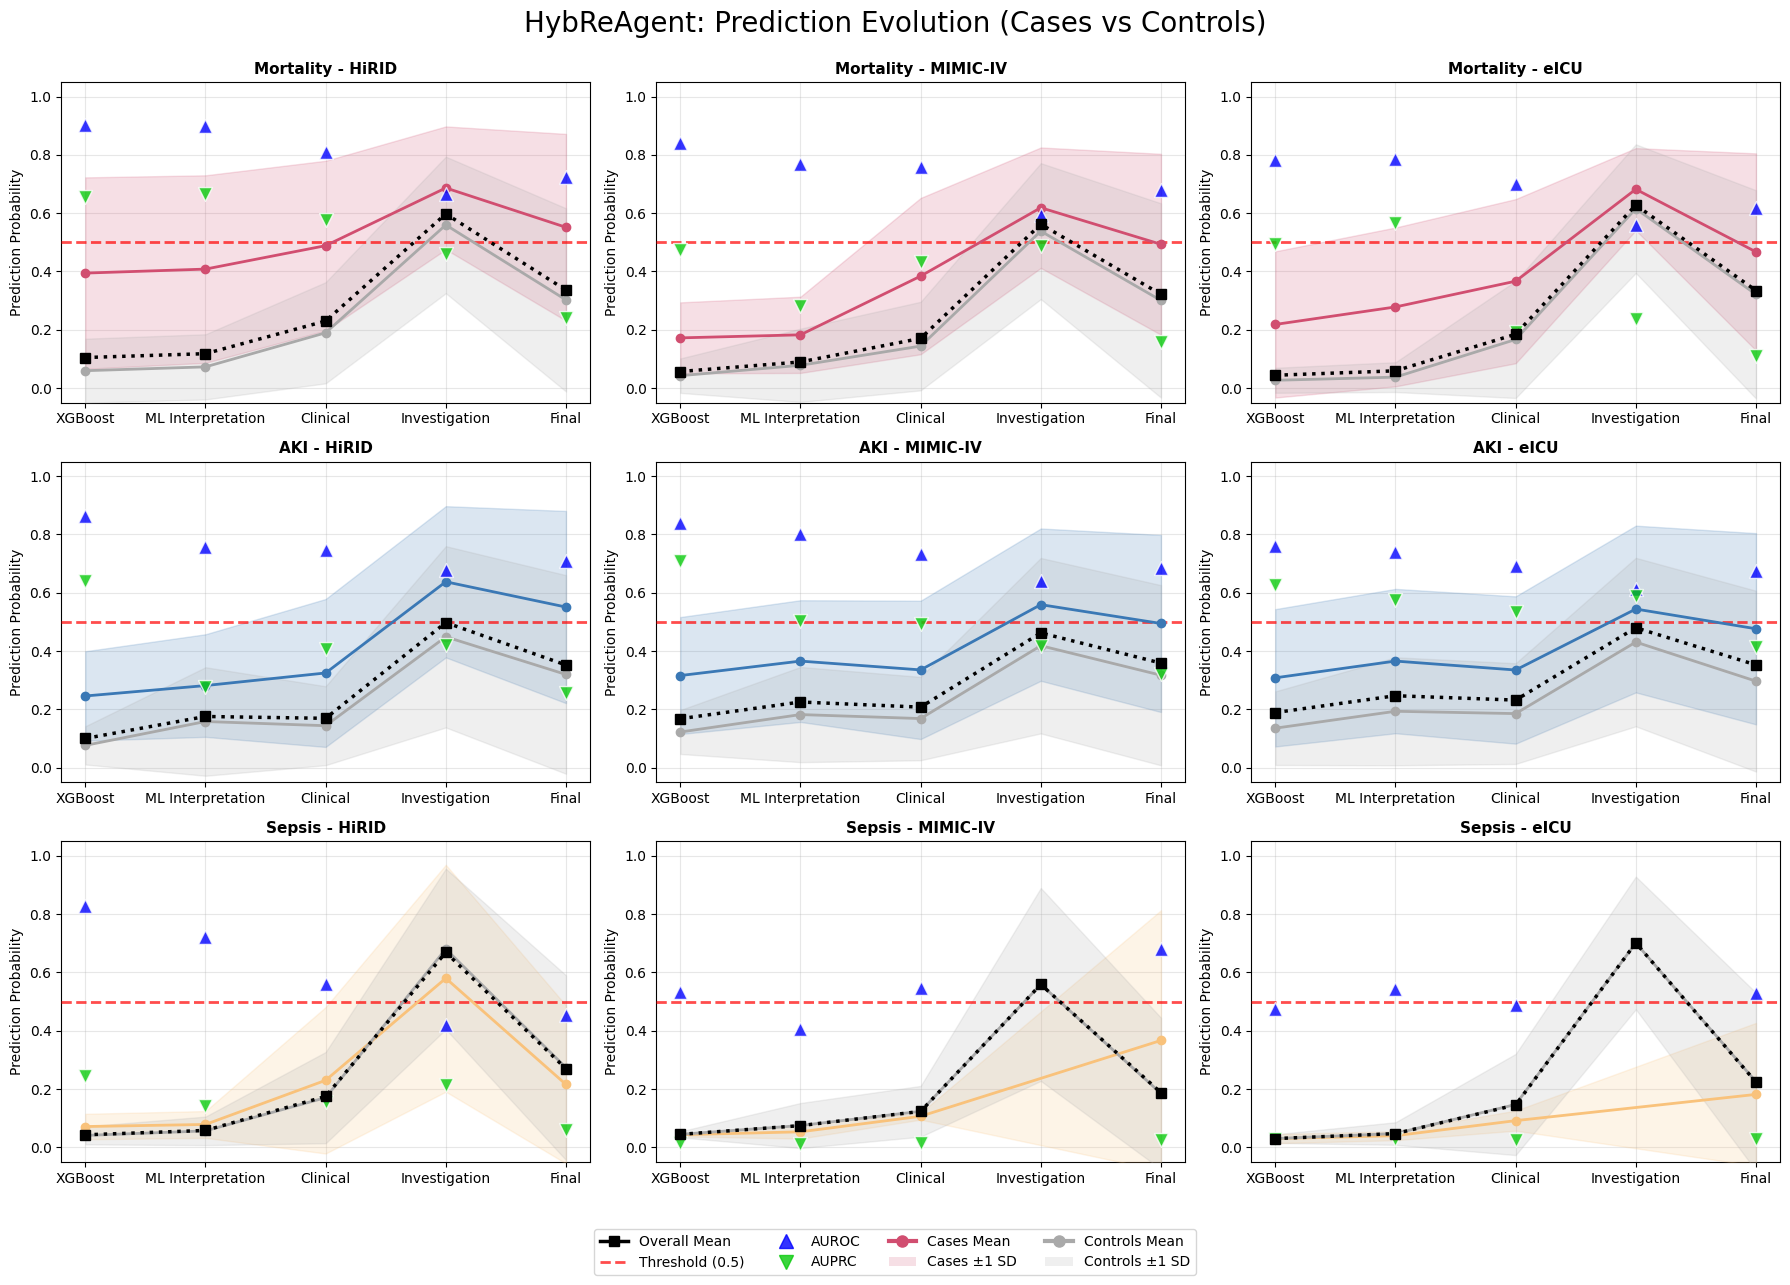


AUROC/AUPRC values for each subplot:
Mortality - HiRID:
  XGBoost: AUROC=0.902, AUPRC=0.656
  ML Interpretation: AUROC=0.899, AUPRC=0.666
  Clinical: AUROC=0.811, AUPRC=0.578
  Investigation: AUROC=0.666, AUPRC=0.460
  Final: AUROC=0.723, AUPRC=0.240
Mortality - MIMIC-IV:
  XGBoost: AUROC=0.841, AUPRC=0.473
  ML Interpretation: AUROC=0.769, AUPRC=0.283
  Clinical: AUROC=0.758, AUPRC=0.433
  Investigation: AUROC=0.595, AUPRC=0.489
  Final: AUROC=0.681, AUPRC=0.157
Mortality - eICU:
  XGBoost: AUROC=0.783, AUPRC=0.495
  ML Interpretation: AUROC=0.785, AUPRC=0.565
  Clinical: AUROC=0.701, AUPRC=0.192
  Investigation: AUROC=0.558, AUPRC=0.238
  Final: AUROC=0.619, AUPRC=0.109
AKI - HiRID:
  XGBoost: AUROC=0.864, AUPRC=0.641
  ML Interpretation: AUROC=0.757, AUPRC=0.276
  Clinical: AUROC=0.747, AUPRC=0.406
  Investigation: AUROC=0.677, AUPRC=0.421
  Final: AUROC=0.709, AUPRC=0.256
AKI - MIMIC-IV:
  XGBoost: AUROC=0.840, AUPRC=0.711
  ML Interpretation: AUROC=0.801, AUPRC=0.503
  Clinical: 

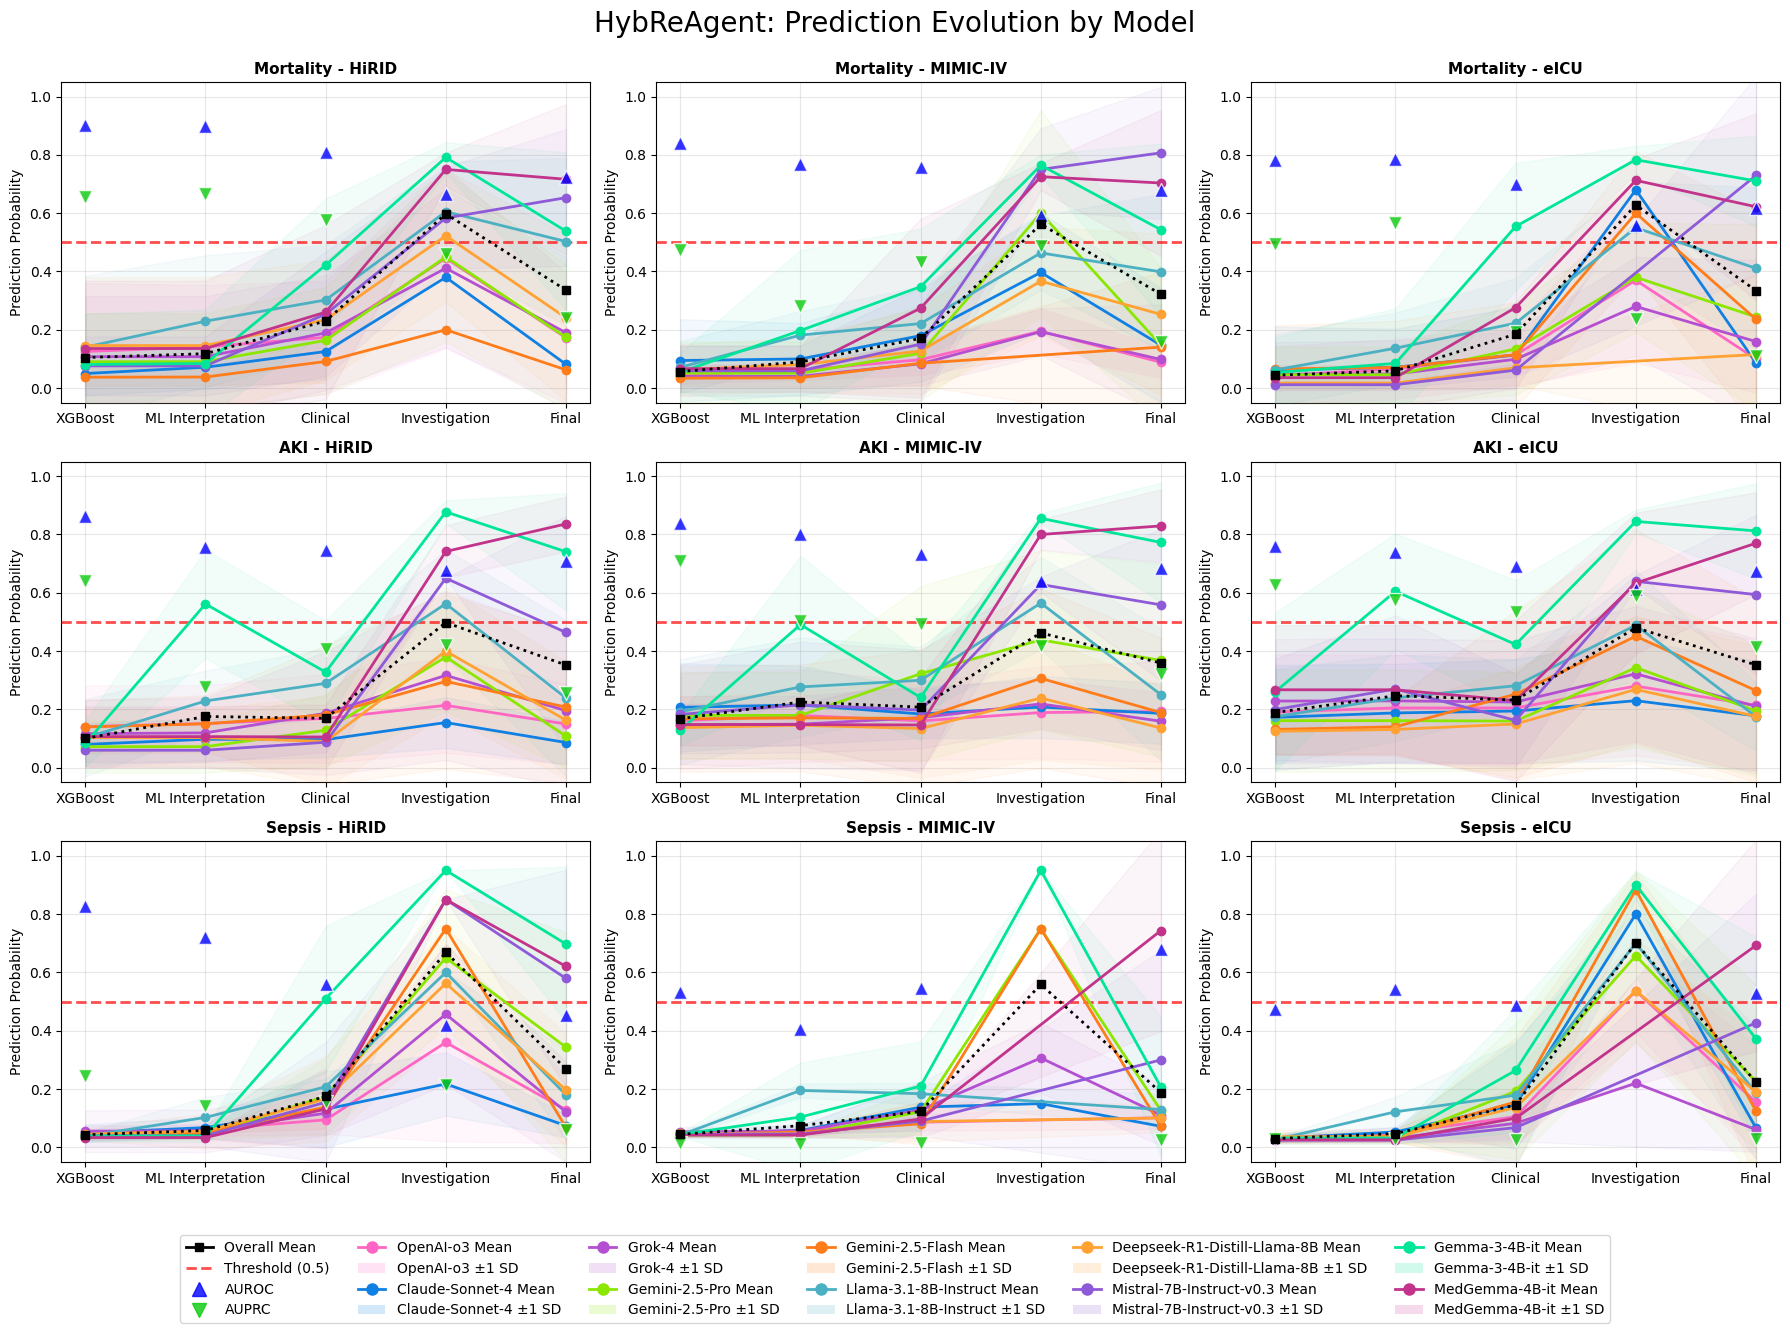


AUROC/AUPRC values for each subplot:
Mortality - HiRID:
  XGBoost: AUROC=0.902, AUPRC=0.656
  ML Interpretation: AUROC=0.899, AUPRC=0.666
  Clinical: AUROC=0.811, AUPRC=0.578
  Investigation: AUROC=0.666, AUPRC=0.460
  Final: AUROC=0.723, AUPRC=0.240
Mortality - MIMIC-IV:
  XGBoost: AUROC=0.841, AUPRC=0.473
  ML Interpretation: AUROC=0.769, AUPRC=0.283
  Clinical: AUROC=0.758, AUPRC=0.433
  Investigation: AUROC=0.595, AUPRC=0.489
  Final: AUROC=0.681, AUPRC=0.157
Mortality - eICU:
  XGBoost: AUROC=0.783, AUPRC=0.495
  ML Interpretation: AUROC=0.785, AUPRC=0.565
  Clinical: AUROC=0.701, AUPRC=0.192
  Investigation: AUROC=0.558, AUPRC=0.238
  Final: AUROC=0.619, AUPRC=0.109
AKI - HiRID:
  XGBoost: AUROC=0.864, AUPRC=0.641
  ML Interpretation: AUROC=0.757, AUPRC=0.276
  Clinical: AUROC=0.747, AUPRC=0.406
  Investigation: AUROC=0.677, AUPRC=0.421
  Final: AUROC=0.709, AUPRC=0.256
AKI - MIMIC-IV:
  XGBoost: AUROC=0.840, AUPRC=0.711
  ML Interpretation: AUROC=0.801, AUPRC=0.503
  Clinical: 

In [ ]:
def create_prediction_evolution_plot(
    view_type="cases_controls", models_to_include=None, save_suffix=""
):
    """
    Visualize prediction evolution across HRA agent steps using the sample-level dataframe.
    Restrict x-axis to: XGBoost (Raw), Step 1 (ML Interp), Step 2 (Clinical), Step 3 (Investigation), Final (Synthesis).
    Means are shown as lines; standard deviation fill is only shown for subgroups (cases/controls or models), not for overall mean.
    Legend is shown below the grid with 2 rows and open-end columns.
    Only the last row shows xticklabels; all subplots have both x and y axis grid.
    If models_to_include is set, only samples from those models are used (for both views).
    """

    step_labels = [
        "step0_ml_prediction",
        "step1_prediction",
        "step2_prediction",
        "step3_prediction",
        "final_prediction",
    ]
    step_display_names = [
        "XGBoost",
        "ML Interpretation",
        "Clinical",
        "Investigation",
        "Final",
    ]
    step_positions = list(range(len(step_labels)))

    plot_df = df_sample_evolution.copy()

    # Filter models if needed
    if models_to_include is not None:
        if isinstance(models_to_include, str):
            models_to_include = [models_to_include]
        # Ensure models_to_include follows LLM_MODELS order
        models_to_include = [m for m in LLM_MODELS if m in models_to_include]
        plot_df = plot_df[plot_df["model"].isin(models_to_include)]
        plot_df["model"] = pd.Categorical(
            plot_df["model"], categories=models_to_include, ordered=True
        )
        print(f"Filtered to models: {models_to_include}")

    # Only keep samples with initial and final prediction
    initial_col = step_labels[0]
    final_col = step_labels[-1]
    plot_df = plot_df[
        plot_df[initial_col].notna() & plot_df[final_col].notna()
    ].copy()
    print(f"Samples with initial and final prediction: {len(plot_df):,}")

    tasks = ["Mortality", "AKI", "Sepsis"]
    datasets = ["HiRID", "MIMIC-IV", "eICU"]

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    # Title logic: append models if models_to_include is set
    if view_type == "cases_controls":
        if models_to_include is not None:
            title = (
                "HybReAgent: Prediction Evolution (Cases vs Controls) "
                f"({', '.join(models_to_include)})"
            )
        else:
            title = "HybReAgent: Prediction Evolution (Cases vs Controls)"
    else:
        if models_to_include is not None:
            title = (
                "HybReAgent: Prediction Evolution by Model "
                f"({', '.join(models_to_include)})"
            )
        else:
            title = "HybReAgent: Prediction Evolution by Model"
    fig.suptitle(title, fontsize=20, y=0.98)

    legend_models = None
    if view_type == "models":
        if models_to_include is not None:
            legend_models = [m for m in LLM_MODELS if m in plot_df["model"].unique()]
        else:
            legend_models = [m for m in LLM_MODELS if m in plot_df["model"].unique()]

    # Collect legend elements for later
    legend_elements = []
    legend_cases_controls = [
        Line2D(
            [0],
            [0],
            color="black",
            linewidth=2.5,
            marker="s",
            markersize=7,
            label="Overall Mean",
        ),
        Line2D(
            [0],
            [0],
            color="red",
            linestyle="--",
            linewidth=2,
            alpha=0.7,
            label="Threshold (0.5)",
        ),
        Line2D(
            [0],
            [0],
            marker="^",
            color="blue",
            linestyle="None",
            markersize=10,
            alpha=0.8,
            label="AUROC",
        ),
        Line2D(
            [0],
            [0],
            marker="v",
            color="#09CB0C",
            linestyle="None",
            markersize=10,
            alpha=0.8,
            label="AUPRC",
        ),
        Line2D(
            [0],
            [0],
            color=TASK_MAPPING["mortality"][1]["case"],
            linewidth=3,
            marker="o",
            markersize=8,
            label="Cases Mean",
        ),
        Patch(
            facecolor=TASK_MAPPING["mortality"][1]["case"],
            alpha=0.18,
            label="Cases ±1 SD",
        ),
        Line2D(
            [0],
            [0],
            color="darkgray",
            linewidth=3,
            marker="o",
            markersize=8,
            label="Controls Mean",
        ),
        Patch(facecolor="darkgray", alpha=0.18, label="Controls ±1 SD"),
    ]
    legend_models_base = [
        Line2D([0], [0], color="black", linewidth=2, marker="s", markersize=6, label="Overall Mean"),
        Line2D([0], [0], color="red", linestyle="--", linewidth=2, alpha=0.7, label="Threshold (0.5)"),
        Line2D([0], [0], marker="^", color="blue", linestyle="None", markersize=10, alpha=0.8, label="AUROC"),
        Line2D([0], [0], marker="v", color="#09CB0C", linestyle="None", markersize=10, alpha=0.8, label="AUPRC"),
    ]

    if view_type == "cases_controls":
        legend_elements = legend_cases_controls
    else:
        legend_elements = legend_models_base.copy()
        for model in legend_models:
            model_color = get_model_color(model)
            legend_elements.append(
                Line2D([0], [0], color=model_color, linewidth=2, marker="o", markersize=8, label=f"{model} Mean")
            )
            legend_elements.append(
                Patch(facecolor=model_color, alpha=0.18, label=f"{model} ±1 SD")
            )

    # Store all AUROC/AUPRC values for concise printing
    all_metrics = []

    for i, task in enumerate(tasks):
        for j, dataset in enumerate(datasets):
            ax = axes[i, j]
            task_data = plot_df[
                (plot_df["task"] == task) & (plot_df["dataset"] == dataset)
            ]
            if len(task_data) == 0:
                ax.text(0.5, 0.5, f"No data for\n{task}-{dataset}", ha="center", va="center", transform=ax.transAxes, fontsize=12)
                ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
                continue
            plot_data = task_data.sample(n=200, random_state=42) if len(task_data) > 200 else task_data

            # Plot means and standard deviations for each subgroup
            if view_type == "cases_controls":
                controls = plot_data[plot_data["label"] == 0]
                cases = plot_data[plot_data["label"] == 1]
                for group, group_color, label, alpha_fill in [
                    (cases, TASK_MAPPING[task.lower()][1]["case"], "Cases Mean", 0.18),
                    (controls, "darkgray", "Controls Mean", 0.18),
                ]:
                    means, stds, valid_positions = [], [], []
                    for pos, col in enumerate(step_labels):
                        vals = pd.to_numeric(group[col], errors="coerce")
                        mean_val = vals.mean()
                        std_val = vals.std()
                        if not np.isnan(mean_val):
                            means.append(mean_val)
                            stds.append(std_val)
                            valid_positions.append(pos)
                    ax.plot(valid_positions, means, color=group_color, linewidth=2, marker="o", markersize=6, label=label, zorder=6)
                    ax.fill_between(valid_positions, np.array(means)-np.array(stds), np.array(means)+np.array(stds),
                                    color=group_color, alpha=alpha_fill, zorder=5, label=f"{label} ±1 SD")
                # Overall mean (no SD fill)
                means, valid_positions = [], []
                for pos, col in enumerate(step_labels):
                    mean_val = pd.to_numeric(plot_data[col], errors="coerce").mean()
                    if not np.isnan(mean_val):
                        means.append(mean_val)
                        valid_positions.append(pos)
                ax.plot(valid_positions, means, color="black", linewidth=2.5, marker="s", markersize=7, label="Overall Mean", zorder=10, linestyle=":")
                ax.axhline(y=0.5, color="red", linestyle="--", alpha=0.7, linewidth=2, label="Classification Threshold (0.5)", zorder=5)
            else:
                if models_to_include is not None:
                    # Ensure models_to_include follows LLM_MODELS order and is present in plot_data
                    models = [m for m in LLM_MODELS if m in models_to_include and m in plot_data["model"].unique()]
                else:
                    # Use LLM_MODELS order, but only those present in plot_data
                    models = [m for m in LLM_MODELS if m in plot_data["model"].unique()]
                for idx, model in enumerate(models):
                    model_data = plot_data[plot_data["model"] == model]
                    means, stds, valid_positions = [], [], []
                    for pos, col in enumerate(step_labels):
                        vals = pd.to_numeric(model_data[col], errors="coerce")
                        mean_val = vals.mean()
                        std_val = vals.std()
                        if not np.isnan(mean_val):
                            means.append(mean_val)
                            stds.append(std_val)
                            valid_positions.append(pos)
                    model_color = get_model_color(model)
                    ax.plot(valid_positions, means, color=model_color, linewidth=2, marker="o", markersize=6, label=f"{model} Mean", zorder=6)
                    ax.fill_between(valid_positions, np.array(means)-np.array(stds), np.array(means)+np.array(stds),
                                    color=model_color, alpha=0.05, zorder=5, label=f"{model} ±1 SD")
                # Overall mean (no SD fill)
                means, valid_positions = [], []
                for pos, col in enumerate(step_labels):
                    mean_val = pd.to_numeric(plot_data[col], errors="coerce").mean()
                    if not np.isnan(mean_val):
                        means.append(mean_val)
                        valid_positions.append(pos)
                ax.plot(valid_positions, means, color="black", linewidth=2, marker="s", markersize=6, label="Overall Mean", zorder=10, linestyle=":")
                ax.axhline(y=0.5, color="red", linestyle="--", alpha=0.7, linewidth=2, label="Classification Threshold (0.5)", zorder=5)

            # AUROC/AUPRC for each step (skip missing)
            from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

            step_metrics = []
            for pos, col in enumerate(step_labels):
                y_true = plot_data["label"].values
                y_pred = pd.to_numeric(plot_data[col], errors="coerce").values
                mask = ~np.isnan(y_pred)
                if mask.sum() < 2 or len(np.unique(y_true[mask])) < 2:
                    step_metrics.append((pos, None, None))
                    continue
                try:
                    auroc = roc_auc_score(y_true[mask], y_pred[mask])
                    precision, recall, _ = precision_recall_curve(
                        y_true[mask], y_pred[mask]
                    )
                    auprc = auc(recall, precision)
                    ax.scatter(
                        pos,
                        auroc,
                        marker="^",
                        s=100,
                        color="blue",
                        alpha=0.8,
                        zorder=8,
                        edgecolors="white",
                        linewidth=1,
                    )
                    ax.scatter(
                        pos,
                        auprc,
                        marker="v",
                        s=100,
                        color="#09CB0C",
                        alpha=0.8,
                        zorder=8,
                        edgecolors="white",
                        linewidth=1,
                    )
                    step_metrics.append((pos, auroc, auprc))
                except Exception:
                    step_metrics.append((pos, None, None))
                    continue

            # Store metrics for concise printing
            all_metrics.append(
                {
                    "task": task,
                    "dataset": dataset,
                    "metrics": [
                        {
                            "step": step_display_names[pos],
                            "auroc": auroc,
                            "auprc": auprc,
                        }
                        for pos, auroc, auprc in step_metrics
                    ],
                }
            )

            ax.set_ylim(-0.05, 1.05)
            ax.set_ylabel("Prediction Probability", fontsize=10)
            ax.set_title(f"{task} - {dataset}", fontsize=11, fontweight="bold")
            ax.grid(True, alpha=0.3, axis="both")
            # Show xticks for all rows, but only show xticklabels for last row
            ax.set_xticks(step_positions)
            ax.set_xticklabels(
                    step_display_names, fontsize=10, rotation=0,
                )
            # if i == len(tasks) - 1:
            #     ax.set_xticklabels(
            #         step_display_names, fontsize=10, rotation=25, ha="right"
            #     )
            # else:
            #     ax.set_xticklabels([""] * len(step_positions))

    # Place legend below the grid, split into 2 rows if <= 12 items (fits in 6 columns), else 4 rows
    n_items = len(legend_elements)
    fig_width = fig.get_size_inches()[0]
    # Estimate legend width: 1.5 inches per item, adjust as needed
    est_legend_width = n_items * 1.5 / 6  # 6 columns
    if n_items <= 12 and est_legend_width < fig_width:
        ncol = 4
        bbox_to_anchor = (0.5, -0.08)
    else:
        ncol = 6
        bbox_to_anchor = (0.5, -0.12)
    fig.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=bbox_to_anchor,
        fontsize=10,
        frameon=True,
        ncol=ncol,
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.02)
    if view_type == "cases_controls":
        save_path = os.path.join(OUTPUT_BASE_DIR, f"prediction_evolution_cases_controls{save_suffix}.png")
    else:
        model_suffix = f"_{'_'.join(models_to_include)}" if models_to_include else "_all_models"
        save_path = os.path.join(OUTPUT_BASE_DIR, f"prediction_evolution_models{model_suffix}{save_suffix}.png")
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    print(f"Prediction evolution plot saved to: {save_path}")
    plt.show()
    # Concise printing of AUROC/AUPRC values
    print("\nAUROC/AUPRC values for each subplot:")
    for entry in all_metrics:
        print(f"{entry['task']} - {entry['dataset']}:")
        for metric in entry["metrics"]:
            if metric["auroc"] is not None and metric["auprc"] is not None:
                print(
                    f"  {metric['step']}: AUROC={metric['auroc']:.3f}, AUPRC={metric['auprc']:.3f}"
                )
            else:
                print(f"  {metric['step']}: AUROC=NA, AUPRC=NA")

    return fig

# Create prediction evolution plots
print(
    "Note:"
    "\n - Not all samples go through the detailed investigation step. This can explain the different prediction values and metrics."
    "\n - AUROC and AUPRC are calculated for each step, but only shown if there are enough samples with predictions (both outcome groups needed)."
    "\n - AUROC and AUPRC are calculated across all plotted samples, not per subgroup."
)

# 1. Original cases vs controls view (default)
print("Creating cases vs controls view...")
evolution_fig_cases = create_prediction_evolution_plot(models_to_include=None, save_suffix="_cases_controls")
# evolution_fig_cases = create_prediction_evolution_plot(
#     models_to_include=['Gemini-2.5-Flash'], 
#     save_suffix="_cases_controls_gemini2p5flash"
# )

# 2. Models view with all models
print("\nCreating models view with all models...")
evolution_fig_models_all = create_prediction_evolution_plot(view_type="models")

# 3. Models view with specific models
# First, let's see what models are available
available_models = df_sample_evolution["model"].unique()
print(f"\nAvailable models: {list(available_models)}")

# print(f"\nCreating models view with selected models")
# step_by_step_selected_models = [
#     "Gemini-2.5-Flash",
#     "Llama-3.1-8B-Instruct",
#     # "Mistral-7B-Instruct-v0.3",
# ]
# evolution_fig_models_selected = create_prediction_evolution_plot(
#     view_type="models",
#     models_to_include=step_by_step_selected_models,
#     save_suffix=f"_selected",  # Example suffix for saved file    ,
# )

## 2. ML-Clinical Agreement Analysis

This section analyzes how well the clinical assessment (Step 2) agrees with the XGBoost predictions (Step 1) and what factors drive disagreement.

Samples with complete agreement data: 61,378
Agreement analysis plot saved to: ./notebook_output/pulse_agents_hybreagent/ml_clinical_agreement_analysis.png


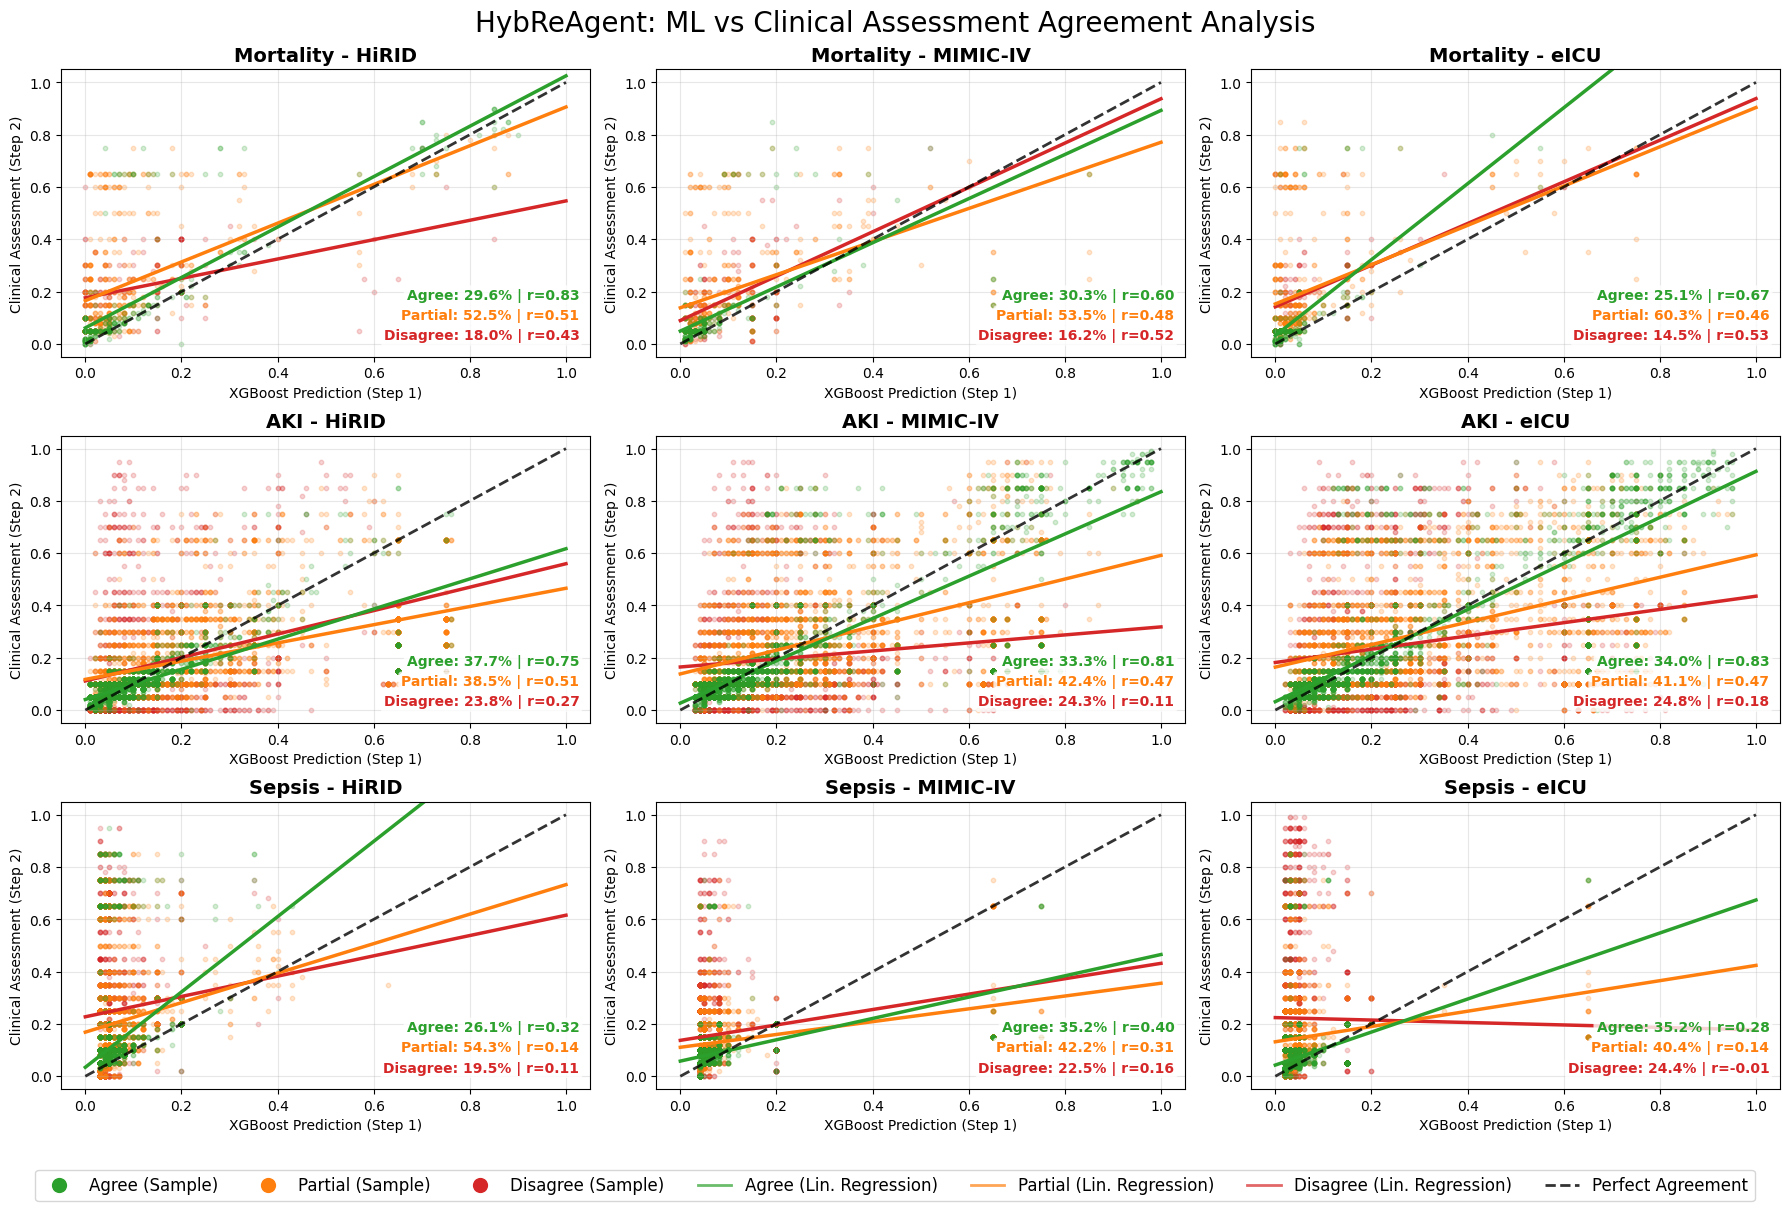

In [ ]:
def create_agreement_analysis_plot(models=None):
    """Create comprehensive ML-Clinical agreement analysis.

    Args:
        models (list, optional): List of model names to include. If None, includes all models.
    """
    import numpy as np

    # Filter samples with complete data for analysis
    agreement_data = df_sample_evolution[
        (df_sample_evolution["step1_prediction"].notna())
        & (df_sample_evolution["step2_prediction"].notna())
        & (df_sample_evolution["ml_vs_clinical_diff"].notna())
        & (df_sample_evolution["ai_agreement"].notna())
    ].copy()

    # Filter by models if specified
    if models is not None:
        agreement_data = agreement_data[agreement_data["model"].isin(models)]
        print(f"Filtered to models: {models}")

    print(f"Samples with complete agreement data: {len(agreement_data):,}")

    # Create 3x3 grid
    tasks = ["Mortality", "AKI", "Sepsis"]
    datasets = ["HiRID", "MIMIC-IV", "eICU"]

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))

    # Set title based on selected models
    if models is not None:
        model_str = f" ({', '.join(models)})"
        title = f"HybReAgent: ML vs Clinical Assessment Agreement Analysis{model_str}"
    else:
        title = "HybReAgent: ML vs Clinical Assessment Agreement Analysis"

    fig.suptitle(title, fontsize=20, y=0.98)

    # Prepare legend elements (dots for agreement, dashed line for perfect agreement)
    legend_elements = [
        # Dots for sample points
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="#2ca02c",
            markersize=10,
            label="Agree (Sample)",
            alpha=1,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="#ff7f0e",
            markersize=10,
            label="Partial (Sample)",
            alpha=1,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="#d62728",
            markersize=10,
            label="Disagree (Sample)",
            alpha=1,
        ),
        # Lines for correlation
        Line2D(
            [0],
            [0],
            color="#2ca02c",
            linestyle="-",
            linewidth=2,
            label="Agree (Lin. Regression)",
            alpha=0.7,
        ),
        Line2D(
            [0],
            [0],
            color="#ff7f0e",
            linestyle="-",
            linewidth=2,
            label="Partial (Lin. Regression)",
            alpha=0.7,
        ),
        Line2D(
            [0],
            [0],
            color="#d62728",
            linestyle="-",
            linewidth=2,
            label="Disagree (Lin. Regression)",
            alpha=0.7,
        ),
        # Diagonal line for perfect agreement
        Line2D(
            [0],
            [0],
            color="black",
            linestyle="--",
            linewidth=2,
            label="Perfect Agreement",
            alpha=0.8,
        ),
    ]

    agreement_colors = {
        "agree": "#2ca02c",
        "partial": "#ff7f0e",
        "disagree": "#d62728",
        "nan": "#7f7f7f",
    }

    for i, task in enumerate(tasks):
        for j, dataset in enumerate(datasets):
            ax = axes[i, j]
            # Filter data for this task-dataset
            task_data = agreement_data[
                (agreement_data["task"] == task)
                & (agreement_data["dataset"] == dataset)
            ]

            if len(task_data) == 0:
                ax.text(
                    0.5,
                    0.5,
                    f"No data for\n{task}-{dataset}",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                    fontsize=12,
                )
                ax.set_title(f"{task} - {dataset}", fontsize=12, fontweight="bold")
                continue

            # Create scatter plot: XGBoost vs Clinical predictions
            x_values = task_data["step1_prediction"]  # XGBoost interpretation
            y_values = task_data["step2_prediction"]  # Clinical assessment

            # Plot disagree markers first (background), then partial, then agree (foreground)
            for agreement_type in ["disagree", "partial", "agree"]:
                mask = task_data["ai_agreement"] == agreement_type
                if mask.any():
                    ax.scatter(
                        x_values[mask],
                        y_values[mask],
                        c=agreement_colors[agreement_type],
                        alpha=0.2,
                        s=10,
                        label=f"{agreement_type.title()}",
                    )
                    # Add correlation line for each agreement type
                    if mask.sum() > 1:
                        # Fit linear regression for this group
                        coef = np.polyfit(x_values[mask], y_values[mask], 1)
                        poly1d_fn = np.poly1d(coef)
                        ax.plot(
                            [0, 1],
                            poly1d_fn([0, 1]),
                            color=agreement_colors[agreement_type],
                            linestyle="-",
                            linewidth=2.5,
                            alpha=1,
                            label=f"{agreement_type.title()} Corr",
                        )

            # Add diagonal line (perfect agreement)
            ax.plot(
                [0, 1], [0, 1], "k--", alpha=0.8, linewidth=2, label="Perfect Agreement"
            )

            # Formatting
            ax.set_xlim(-0.05, 1.05)
            ax.set_ylim(-0.05, 1.05)
            ax.set_xlabel("XGBoost Prediction (Step 1)", fontsize=10)
            ax.set_ylabel("Clinical Assessment (Step 2)", fontsize=10)
            ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
            ax.grid(True, alpha=0.3)

            # Add agreement statistics annotation (bottom right, colored lines, more spacing, bold, only percentages, less transparent box, with correlation)
            agreement_stats = task_data["ai_agreement"].value_counts()
            total = len(task_data)
            annotation_lines = []
            annotation_colors = []
            for agreement_type in ["disagree", "partial", "agree"]:
                mask = task_data["ai_agreement"] == agreement_type
                if agreement_type in agreement_stats and mask.sum() > 1:
                    pct = (agreement_stats[agreement_type] / total) * 100
                    # Calculate correlation for this category
                    try:
                        corr = np.corrcoef(x_values[mask], y_values[mask])[0, 1]
                    except Exception:
                        corr = np.nan
                    annotation_lines.append(
                        f"{agreement_type.title()}: {pct:.1f}% | r={corr:.2f}"
                    )
                    annotation_colors.append(agreement_colors[agreement_type])
                elif agreement_type in agreement_stats:
                    pct = (agreement_stats[agreement_type] / total) * 100
                    annotation_lines.append(
                        f"{agreement_type.title()}: {pct:.1f}% | r=NA"
                    )
                    annotation_colors.append(agreement_colors[agreement_type])
            # Draw each line separately for color
            y_start = 0.05
            line_spacing = 0.07  # slightly more spacing
            for idx, (line, color) in enumerate(
                zip(annotation_lines, annotation_colors)
            ):
                ax.text(
                    0.98,
                    y_start + idx * line_spacing,
                    line,
                    transform=ax.transAxes,
                    fontsize=10,
                    fontweight="bold",
                    color=color,
                    ha="right",
                    va="bottom",
                    bbox=(
                        dict(
                            boxstyle="round,pad=0.22",
                            facecolor="white",
                            alpha=0.8,
                            edgecolor="none",
                        )
                    ),
                )

    # Move legend below the grid
    fig.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.02),
        fontsize=12,
        frameon=True,
        ncol=len(legend_elements),
        markerscale=1.2,
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.93, bottom=0.08)
    model_suffix = f"_{'_'.join(models)}" if models else ""
    save_path = os.path.join(
        OUTPUT_BASE_DIR, f"ml_clinical_agreement_analysis{model_suffix}.png"
    )
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    print(f"Agreement analysis plot saved to: {save_path}")
    plt.show()

    return fig


# Create agreement plot
agreement_selected_models = [
    "Gemini-2.5-Flash",
    "Llama-3.1-8B-Instruct",
    # "Mistral-7B-Instruct-v0.3",
]
agreement_fig = create_agreement_analysis_plot(models=None)

### How to Interpret the ML-Clinical Agreement Analysis Plot

**Plot Structure:**
- **X-axis**: XGBoost prediction probability (Step 1 - ML Interpretation)
- **Y-axis**: Clinical assessment probability (Step 2 - Clinical Assessment)
- **Colors**: Agreement level between AI agent and clinical reasoning
  - 🟢 **Green (Agree)**: Agent agrees with clinical assessment
  - 🟠 **Orange (Partial)**: Agent partially agrees with clinical assessment
  - 🔴 **Red (Disagree)**: Agent disagrees with clinical assessment

**Key Elements:**
- **Diagonal line (black dashed)**: Perfect agreement line where XGBoost prediction = Clinical assessment
- **Text annotations**: Show percentage breakdown of agreement levels for each task-dataset combination

**What to Look For:**

1. **Points near the diagonal line**: Indicate good agreement between XGBoost interpretation and clinical assessment
2. **Points far from diagonal**: Show significant disagreement between ML and clinical reasoning
3. **Color patterns**:
   - Predominantly green points = Agent consistently agrees with clinical reasoning
   - Mixed colors = Agent shows varying levels of agreement
   - Many red points = Frequent disagreement between ML and clinical approaches

**Clinical Significance:**
- **Upper right quadrant**: Both XGBoost and clinical assessment predict high risk
- **Lower left quadrant**: Both predict low risk (good agreement)
- **Upper left/Lower right**: Disagreement areas where one approach predicts high risk while the other predicts low risk

**Expected Patterns:**
- Some scatter is expected due to legitimate differences in ML vs clinical reasoning
- Extreme outliers may indicate cases where additional investigation is warranted

In [ ]:
# Improved: Print full high disagreement distribution without truncation

print("\n" + "=" * 50)
print("DETAILED AGREEMENT STATISTICS")
print("=" * 50)

# Overall agreement statistics
overall_agreement = df_sample_evolution["ai_agreement"].value_counts()
total_with_agreement = overall_agreement.sum()

print(f"\nOverall Agreement Distribution (n={total_with_agreement:,}):")
for agreement, count in overall_agreement.items():
    percentage = (count / total_with_agreement) * 100
    print(f"  {agreement}: {count:,} ({percentage:.1f}%)")

# Agreement by task-dataset
print(f"\nAgreement by Task-Dataset:")
agreement_by_task_dataset = (
    df_sample_evolution.groupby(["task", "dataset"])["ai_agreement"]
    .value_counts()
    .unstack(fill_value=0)
)
for (task, dataset), row in agreement_by_task_dataset.iterrows():
    total = row.sum()
    if total > 0:
        print(f"\n  {task}-{dataset} (n={total:,}):")
        for agreement in ["agree", "partial", "disagree"]:
            if agreement in row:
                count = row[agreement]
                pct = (count / total) * 100
                print(f"    {agreement}: {count:,} ({pct:.1f}%)")

# ML vs Clinical difference analysis
print(f"\nML vs Clinical Probability Differences:")
ml_clinical_diff_stats = df_sample_evolution["ml_vs_clinical_diff"].describe()
print(f"  Mean difference: {ml_clinical_diff_stats['mean']:.3f}")
print(f"  Median difference: {ml_clinical_diff_stats['50%']:.3f}")
print(f"  75th percentile: {ml_clinical_diff_stats['75%']:.3f}")
print(
    f"  95th percentile: {df_sample_evolution['ml_vs_clinical_diff'].quantile(0.95):.3f}"
)

# Mean ML-clinical difference by agreement subgroup
print("\nMean ML-Clinical Probability Difference by Agreement Subgroup:")
for agreement in ["agree", "partial", "disagree"]:
    subgroup = df_sample_evolution[df_sample_evolution["ai_agreement"] == agreement]
    if len(subgroup) > 0:
        mean_diff = subgroup["ml_vs_clinical_diff"].mean()
        std_diff = subgroup["ml_vs_clinical_diff"].std()
        print(f"  {agreement.title()}: {mean_diff:.3f} (SD: {std_diff:.3f})")
    else:
        print(f"  {agreement.title()}: No data")

# High disagreement cases analysis
high_disagreement_threshold = 20  # 20% difference
high_disagreement = df_sample_evolution[
    df_sample_evolution["ml_vs_clinical_diff"] > high_disagreement_threshold
]
print(
    f"\nHigh Disagreement Cases (>20% difference): {len(high_disagreement):,} ({(len(high_disagreement)/len(df_sample_evolution))*100:.1f}%)"
)

if len(high_disagreement) > 0:
    high_disagreement_by_task = high_disagreement.groupby(["task", "dataset"]).size()
    print("  Distribution by task-dataset:")
    # Print all combinations, including those with zero
    for task in sorted(df_sample_evolution["task"].unique()):
        for dataset in sorted(df_sample_evolution["dataset"].unique()):
            count = high_disagreement_by_task.get((task, dataset), 0)
            task_total = len(
                df_sample_evolution[
                    (df_sample_evolution["task"] == task)
                    & (df_sample_evolution["dataset"] == dataset)
                ]
            )
            pct = (count / task_total) * 100 if task_total > 0 else 0
            print(
                f"    {task}-{dataset}: {count:,} ({pct:.1f}% of task-dataset samples)"
            )


DETAILED AGREEMENT STATISTICS

Overall Agreement Distribution (n=61,378):
  partial: 26,811 (43.7%)
  agree: 20,468 (33.3%)
  disagree: 14,058 (22.9%)
  malformed: 20 (0.0%)
  partially agree: 16 (0.0%)
  partially disagree: 5 (0.0%)

Agreement by Task-Dataset:

  AKI-HiRID (n=9,779):
    agree: 3,687 (37.7%)
    partial: 3,762 (38.5%)
    disagree: 2,327 (23.8%)

  AKI-MIMIC-IV (n=9,778):
    agree: 3,252 (33.3%)
    partial: 4,141 (42.4%)
    disagree: 2,378 (24.3%)

  AKI-eICU (n=9,773):
    agree: 3,319 (34.0%)
    partial: 4,017 (41.1%)
    disagree: 2,425 (24.8%)

  Mortality-HiRID (n=997):
    agree: 295 (29.6%)
    partial: 523 (52.5%)
    disagree: 179 (18.0%)

  Mortality-MIMIC-IV (n=981):
    agree: 297 (30.3%)
    partial: 525 (53.5%)
    disagree: 159 (16.2%)

  Mortality-eICU (n=991):
    agree: 249 (25.1%)
    partial: 598 (60.3%)
    disagree: 144 (14.5%)

  Sepsis-HiRID (n=9,470):
    agree: 2,468 (26.1%)
    partial: 5,146 (54.3%)
    disagree: 1,848 (19.5%)

  Sepsi

## 3. Investigation Trigger Analysis

This section analyzes when the agent triggers the detailed investigation step (Step 3) and what factors influence this decision.


INVESTIGATION TRIGGER ANALYSIS
Samples with complete investigation data: 61,889
Samples with actual Step 3 data: 21,202 (34.3%)
Investigation trigger logic: ML confidence < 80% OR ML-Clinical difference > 20%
Samples meeting trigger criteria: 16,220 (26.2%)
  - Low ML confidence (<80%): 16,110
  - High disagreement (>20%): 7,230
Investigation trigger plot saved to: ./notebook_output/pulse_agents_hybreagent/investigation_trigger_analysis.png


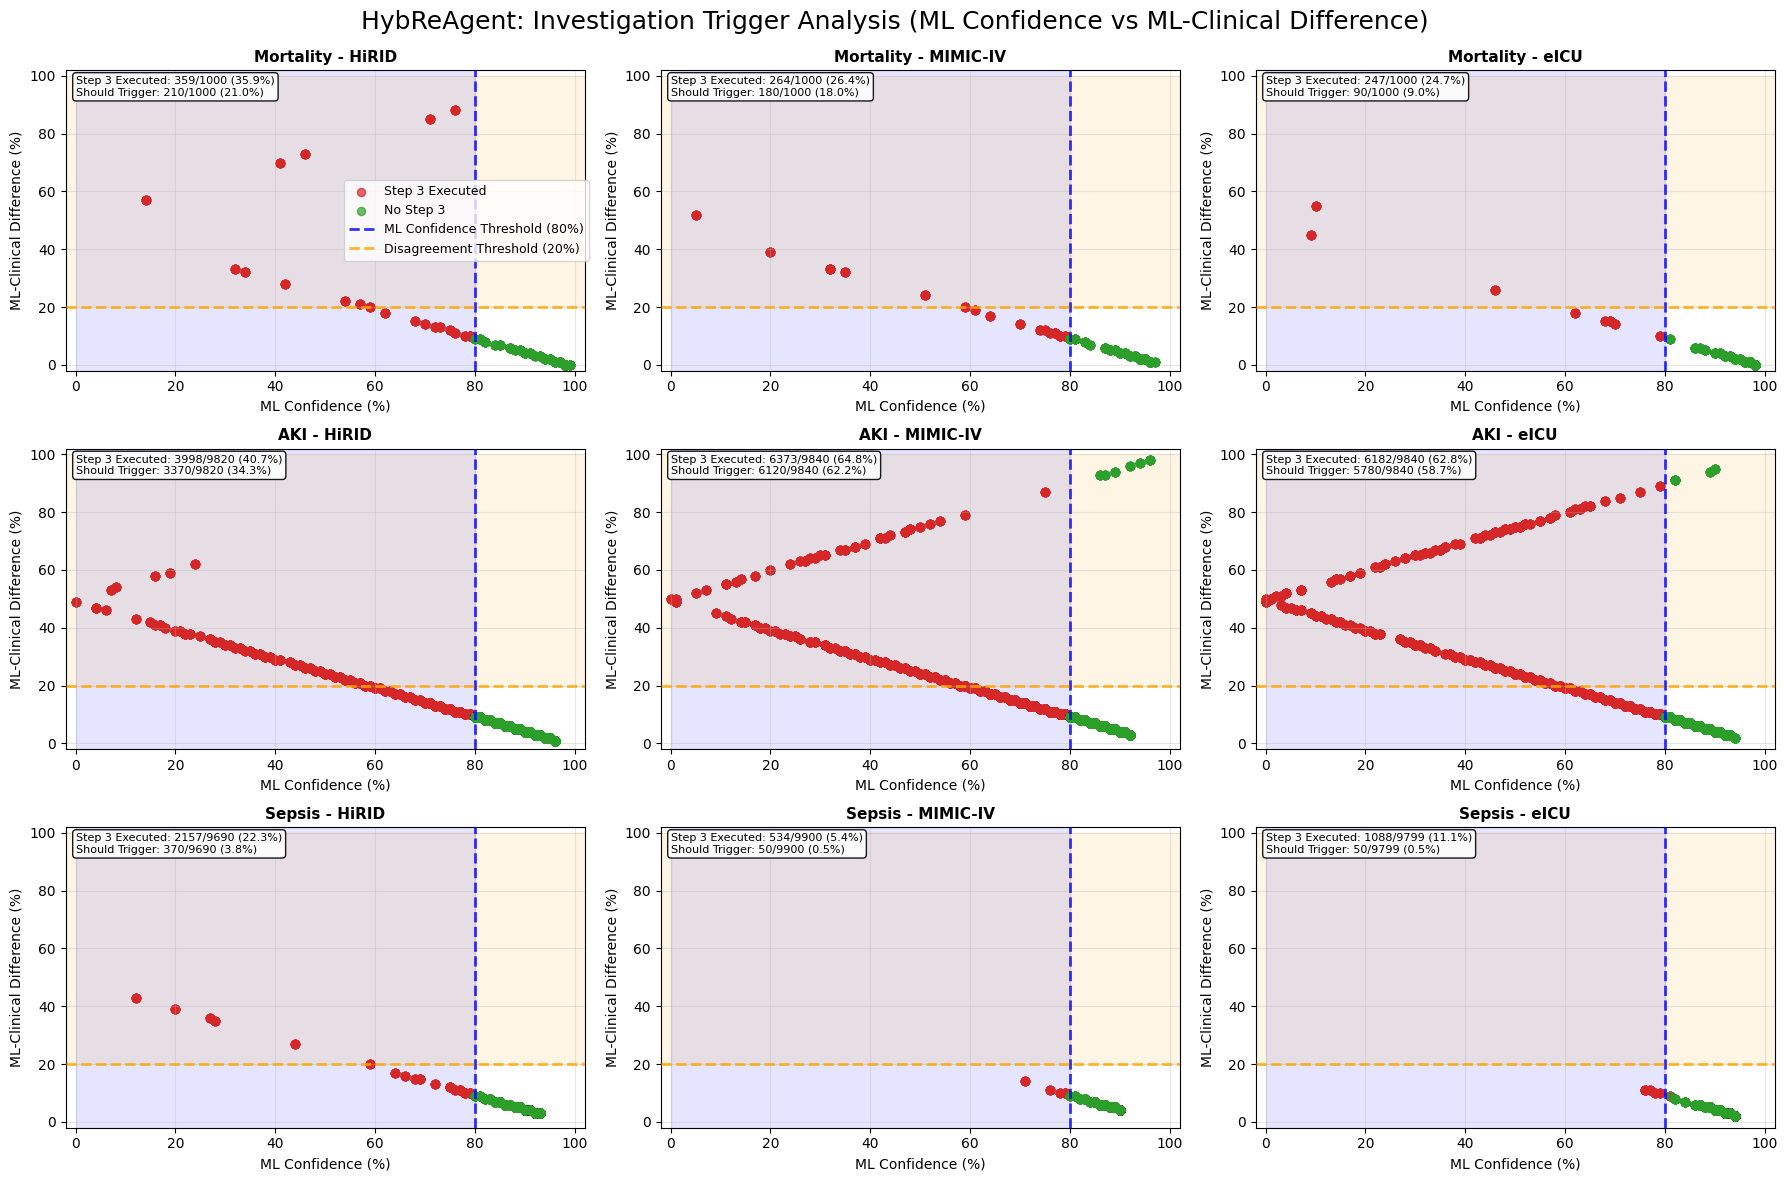

In [ ]:
# Investigation Trigger Analysis
print("\n" + "="*80)
print("INVESTIGATION TRIGGER ANALYSIS")
print("="*80)

def create_investigation_trigger_plot():
    """Create visualization showing investigation trigger patterns."""

    # Filter samples with complete investigation data
    investigation_data = df_sample_evolution[
        (df_sample_evolution['ml_vs_clinical_diff'].notna()) &
        (df_sample_evolution['step1_ml_confidence'].notna())
    ].copy()

    # Create actual investigation status based on presence of Step 3 data
    # This is the ground truth of whether investigation actually happened
    investigation_data['has_step3_data'] = investigation_data['step3_prediction'].notna()

    print(f"Samples with complete investigation data: {len(investigation_data):,}")

    # Print investigation trigger logic verification
    samples_with_step3 = investigation_data[investigation_data['has_step3_data'] == True]
    total_samples = len(investigation_data)
    step3_rate = (len(samples_with_step3) / total_samples) * 100

    print(f"Samples with actual Step 3 data: {len(samples_with_step3):,} ({step3_rate:.1f}%)")
    print(f"Investigation trigger logic: ML confidence < 80% OR ML-Clinical difference > 20%")

    # Verify trigger logic
    low_confidence_samples = investigation_data[investigation_data['step1_ml_confidence'] < 80]
    high_disagreement_samples = investigation_data[investigation_data['ml_vs_clinical_diff'] > 20]
    should_trigger = len(investigation_data[
        (investigation_data['step1_ml_confidence'] < 80) |
        (investigation_data['ml_vs_clinical_diff'] > 20)
    ])

    print(f"Samples meeting trigger criteria: {should_trigger:,} ({(should_trigger/total_samples)*100:.1f}%)")
    print(f"  - Low ML confidence (<80%): {len(low_confidence_samples):,}")
    print(f"  - High disagreement (>20%): {len(high_disagreement_samples):,}")

    # Create 3x3 grid
    tasks = ["Mortality", "AKI", "Sepsis"]
    datasets = ["HiRID", "MIMIC-IV", "eICU"]

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    fig.suptitle(
        "HybReAgent: Investigation Trigger Analysis (ML Confidence vs ML-Clinical Difference)",
        fontsize=18,
        y=0.98,
    )

    for i, task in enumerate(tasks):
        for j, dataset in enumerate(datasets):
            ax = axes[i, j]

            # Filter data for this task-dataset
            task_data = investigation_data[
                (investigation_data['task'] == task) &
                (investigation_data['dataset'] == dataset)
            ]

            if len(task_data) == 0:
                ax.text(0.5, 0.5, f'No data for\n{task}-{dataset}',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                ax.set_title(f'{task} - {dataset}', fontsize=14, fontweight='bold')
                continue

            # Create scatter plot: ML Confidence vs ML-Clinical Difference
            x_values = task_data['step1_ml_confidence']  # Keep as percentage (0-100)
            y_values = task_data['ml_vs_clinical_diff']   # Keep as percentage (0-100)

            # Color by actual Step 3 data presence (ground truth)
            trigger_colors = {True: '#d62728', False: '#2ca02c'}  # Red for has Step 3, green for no Step 3

            # Plot True first (background), then False (foreground) to highlight missing investigations
            for has_step3 in [True, False]:  # Changed order: Step 3 executed (background), No Step 3 (foreground)
                mask = task_data['has_step3_data'] == has_step3
                if mask.any():
                    label = 'Step 3 Executed' if has_step3 else 'No Step 3'
                    ax.scatter(x_values[mask], y_values[mask],
                             c=trigger_colors[has_step3],
                             alpha=0.7, s=35, label=label,
                             zorder=1 if has_step3 else 2)  # No Step 3 points on top

            # Add threshold lines based on actual trigger logic
            ax.axvline(x=80, color='blue', linestyle='--', alpha=0.8, linewidth=2, 
                      label='ML Confidence Threshold (80%)', zorder=3)
            ax.axhline(y=20, color='orange', linestyle='--', alpha=0.8, linewidth=2, 
                      label='Disagreement Threshold (20%)', zorder=3)

            # Add trigger regions with subtle background shading
            # Low confidence region (left of 80%)
            ax.axvspan(0, 80, alpha=0.1, color='blue', zorder=0)
            # High disagreement region (above 20%)
            ax.axhspan(20, 100, alpha=0.1, color='orange', zorder=0)

            # Formatting
            ax.set_xlim(-2, 102)
            ax.set_ylim(-2, 102)
            ax.set_xlabel('ML Confidence (%)', fontsize=10)
            ax.set_ylabel('ML-Clinical Difference (%)', fontsize=10)
            ax.set_title(f'{task} - {dataset}', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)

            # Add investigation statistics
            step3_count = (task_data['has_step3_data'] == True).sum()
            total = len(task_data)
            step3_pct = (step3_count/total)*100

            # Calculate trigger criteria matches
            should_trigger_count = len(task_data[
                (task_data['step1_ml_confidence'] < 80) | 
                (task_data['ml_vs_clinical_diff'] > 20)
            ])
            should_trigger_pct = (should_trigger_count/total)*100

            stats_text = f'Step 3 Executed: {step3_count}/{total} ({step3_pct:.1f}%)\n'
            stats_text += f'Should Trigger: {should_trigger_count}/{total} ({should_trigger_pct:.1f}%)'

            ax.text(0.02, 0.98, stats_text, 
                   transform=ax.transAxes, fontsize=8, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9),
                   verticalalignment='top')

            # Add legend only to first subplot
            if i == 0 and j == 0:
                ax.legend(loc='center right', fontsize=9, bbox_to_anchor=(1.02, 0.5))

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)

    # Save plot
    save_path = os.path.join(OUTPUT_BASE_DIR, "investigation_trigger_analysis.png")
    plt.savefig(save_path, dpi=400, bbox_inches='tight')
    print(f"Investigation trigger plot saved to: {save_path}")
    plt.show()

    return fig


# Create investigation trigger plot
investigation_fig = create_investigation_trigger_plot()

In [ ]:
# Detailed investigation trigger statistics
print("\n" + "=" * 50)
print("DETAILED INVESTIGATION TRIGGER STATISTICS")
print("=" * 50)

# Analysis based on actual Step 3 data presence (ground truth)
investigation_data = df_sample_evolution[
    (df_sample_evolution["ml_vs_clinical_diff"].notna())
    & (df_sample_evolution["step1_ml_confidence"].notna())
].copy()

# Create actual investigation status
investigation_data["has_step3_data"] = investigation_data["step3_prediction"].notna()

total_with_investigation_data = len(investigation_data)
step3_executed = (investigation_data["has_step3_data"] == True).sum()
step3_rate = (step3_executed / total_with_investigation_data) * 100

print(f"\nActual Investigation Execution Rate (based on Step 3 data presence):")
print(f"  Total samples: {total_with_investigation_data:,}")
print(f"  Step 3 executed: {step3_executed:,} ({step3_rate:.1f}%)")
print(
    f"  Step 3 not executed: {total_with_investigation_data - step3_executed:,} ({100-step3_rate:.1f}%)"
)

# Trigger logic analysis
print(f"\nTrigger Logic Analysis:")
low_conf_samples = investigation_data[investigation_data["step1_ml_confidence"] < 80]
high_disagree_samples = investigation_data[
    investigation_data["ml_vs_clinical_diff"] > 20
]
should_trigger_samples = investigation_data[
    (investigation_data["step1_ml_confidence"] < 80)
    | (investigation_data["ml_vs_clinical_diff"] > 20)
]

print(
    f"  Samples meeting trigger criteria: {len(should_trigger_samples):,} ({(len(should_trigger_samples)/total_with_investigation_data)*100:.1f}%)"
)
print(f"    - Low ML confidence (<80%): {len(low_conf_samples):,}")
print(f"    - High disagreement (>20%): {len(high_disagree_samples):,}")
print(f"    - Either condition: {len(should_trigger_samples):,}")

# Investigation rates by task-dataset (based on actual Step 3 data)
print(f"\nStep 3 Execution Rates by Task-Dataset:")
step3_by_task_dataset = (
    investigation_data.groupby(["task", "dataset"])
    .agg({"has_step3_data": ["count", "sum"]})
    .reset_index()
)

# Flatten column names
step3_by_task_dataset.columns = ["task", "dataset", "count", "sum"]
step3_by_task_dataset["rate"] = (
    step3_by_task_dataset["sum"] / step3_by_task_dataset["count"]
) * 100

for _, row in step3_by_task_dataset.iterrows():
    print(
        f"  {row['task']}-{row['dataset']}: {row['sum']}/{row['count']} ({row['rate']:.1f}%)"
    )

# --- AGGREGATED VALUES BY TASK ---
print(f"\nStep 3 Execution Rates by Task (Aggregated Across Datasets):")
step3_by_task = (
    investigation_data.groupby("task")
    .agg({"has_step3_data": ["count", "sum"]})
    .reset_index()
)
step3_by_task.columns = ["task", "count", "sum"]
step3_by_task["rate"] = (step3_by_task["sum"] / step3_by_task["count"]) * 100
for _, row in step3_by_task.iterrows():
    print(f"  {row['task']}: {row['sum']}/{row['count']} ({row['rate']:.1f}%)")

# Check for discrepancies between trigger logic and actual execution
print(f"\nTrigger Logic vs Actual Execution Analysis:")
should_trigger_but_no_step3 = investigation_data[
    (
        (investigation_data["step1_ml_confidence"] < 80)
        | (investigation_data["ml_vs_clinical_diff"] > 20)
    )
    & (investigation_data["has_step3_data"] == False)
]

no_trigger_but_has_step3 = investigation_data[
    ~(
        (investigation_data["step1_ml_confidence"] < 80)
        | (investigation_data["ml_vs_clinical_diff"] > 20)
    )
    & (investigation_data["has_step3_data"] == True)
]

print(f"  Should trigger but no Step 3: {len(should_trigger_but_no_step3):,}")
print(f"  Shouldn't trigger but has Step 3: {len(no_trigger_but_has_step3):,}")

# Model differences in Step 3 execution rates
print(f"\nStep 3 Execution Rates by Model:")
step3_by_model = (
    investigation_data.groupby("model")
    .agg({"has_step3_data": ["count", "sum"]})
    .reset_index()
)

# Flatten column names
step3_by_model.columns = ["model", "count", "sum"]
step3_by_model["rate"] = (step3_by_model["sum"] / step3_by_model["count"]) * 100

for _, row in step3_by_model.iterrows():
    print(f"  {row['model']}: {row['sum']}/{row['count']} ({row['rate']:.1f}%)")


DETAILED INVESTIGATION TRIGGER STATISTICS

Actual Investigation Execution Rate (based on Step 3 data presence):
  Total samples: 61,889
  Step 3 executed: 21,202 (34.3%)
  Step 3 not executed: 40,687 (65.7%)

Trigger Logic Analysis:
  Samples meeting trigger criteria: 16,220 (26.2%)
    - Low ML confidence (<80%): 16,110
    - High disagreement (>20%): 7,230
    - Either condition: 16,220

Step 3 Execution Rates by Task-Dataset:
  AKI-HiRID: 3998/9820 (40.7%)
  AKI-MIMIC-IV: 6373/9840 (64.8%)
  AKI-eICU: 6182/9840 (62.8%)
  Mortality-HiRID: 359/1000 (35.9%)
  Mortality-MIMIC-IV: 264/1000 (26.4%)
  Mortality-eICU: 247/1000 (24.7%)
  Sepsis-HiRID: 2157/9690 (22.3%)
  Sepsis-MIMIC-IV: 534/9900 (5.4%)
  Sepsis-eICU: 1088/9799 (11.1%)

Step 3 Execution Rates by Task (Aggregated Across Datasets):
  AKI: 16553/29500 (56.1%)
  Mortality: 870/3000 (29.0%)
  Sepsis: 3779/29389 (12.9%)

Trigger Logic vs Actual Execution Analysis:
  Should trigger but no Step 3: 109
  Shouldn't trigger but has St

In [ ]:
# Detailed Agent Behavior Analysis with Subgroup Breakdowns
print("\n" + "="*80)
print("DETAILED AGENT BEHAVIOR ANALYSIS WITH SUBGROUP BREAKDOWNS")
print("="*80)

def analyze_by_subgroups(df, column_name, clean_func=None, analysis_name="Analysis"):
    """
    Analyze a column by overall, cases vs controls, and individual models.
    
    Args:
        df: DataFrame to analyze
        column_name: Name of column to analyze
        clean_func: Function to clean the column values (optional)
        analysis_name: Name for the analysis section
    """
    print(f"\n{analysis_name.upper()}:")
    
    if column_name not in df.columns:
        print(f"  Column '{column_name}' not found in dataset")
        return
    
    # Clean data if cleaning function provided
    if clean_func:
        df = df.copy()
        df[f'{column_name}_clean'] = df[column_name].apply(clean_func)
        analysis_col = f'{column_name}_clean'
    else:
        analysis_col = column_name
    
    # Filter to non-null values
    valid_data = df[df[analysis_col].notna()].copy()
    
    if len(valid_data) == 0:
        print(f"  No valid data available for {analysis_name}")
        return
    
    # Overall analysis
    overall_counts = valid_data[analysis_col].value_counts()
    total_overall = len(valid_data)
    
    print(f"\n  OVERALL DISTRIBUTION (n={total_overall:,}):")
    for value, count in overall_counts.items():
        percentage = (count / total_overall) * 100
        print(f"    {value}: {count:,} ({percentage:.1f}%)")
    
    # Cases vs Controls analysis
    print(f"\n  BY CASE/CONTROL STATUS:")
    for label_type, label_name in [(1, "Cases"), (0, "Controls")]:
        subgroup_data = valid_data[valid_data['label'] == label_type]
        if len(subgroup_data) == 0:
            print(f"    {label_name}: No data available")
            continue
            
        subgroup_counts = subgroup_data[analysis_col].value_counts()
        total_subgroup = len(subgroup_data)
        
        print(f"    {label_name} (n={total_subgroup:,}):")
        for value, count in subgroup_counts.items():
            percentage = (count / total_subgroup) * 100
            print(f"      {value}: {count:,} ({percentage:.1f}%)")
    
    # Individual model analysis
    print(f"\n  BY INDIVIDUAL MODEL:")
    models = sorted(valid_data['model'].unique())
    for model in models:
        model_data = valid_data[valid_data['model'] == model]
        if len(model_data) == 0:
            print(f"    {model}: No data available")
            continue
            
        model_counts = model_data[analysis_col].value_counts()
        total_model = len(model_data)
        
        print(f"    {model} (n={total_model:,}):")
        for value, count in model_counts.items():
            percentage = (count / total_model) * 100
            print(f"      {value}: {count:,} ({percentage:.1f}%)")

# Clean boolean column function for analysis
def clean_boolean_column_analysis(series):
    """Convert mixed boolean/string values to proper boolean for analysis."""
    if pd.isna(series):
        return None
    if isinstance(series, bool):
        return series
    if isinstance(series, str):
        series_lower = series.lower().strip()
        if series_lower in ['true', '1', 'yes', 'y']:
            return True
        elif series_lower in ['false', '0', 'no', 'n']:
            return False
        else:
            return None
    if isinstance(series, (int, float)):
        if series == 1:
            return True
        elif series == 0:
            return False
        else:
            return None
    return None

# 1. Investigation Trigger Analysis
analyze_by_subgroups(
    df_sample_evolution, 
    'investigation_triggered', 
    clean_boolean_column_analysis,
    "Investigation Trigger Analysis"
)

# Additional investigation trigger analysis
print(f"\n  TRIGGER REASON BREAKDOWN:")
if all(col in df_sample_evolution.columns for col in ['ml_confidence_low', 'high_disagreement']):
    # Get only triggered cases
    triggered_data = df_sample_evolution[
        df_sample_evolution['investigation_triggered'].apply(clean_boolean_column_analysis) == True
    ].copy()
    
    if len(triggered_data) > 0:
        triggered_data['ml_confidence_low_clean'] = triggered_data['ml_confidence_low'].apply(clean_boolean_column_analysis)
        triggered_data['high_disagreement_clean'] = triggered_data['high_disagreement'].apply(clean_boolean_column_analysis)
        
        total_triggered = len(triggered_data)
        low_conf_count = (triggered_data['ml_confidence_low_clean'] == True).sum()
        high_disagree_count = (triggered_data['high_disagreement_clean'] == True).sum()
        both_count = ((triggered_data['ml_confidence_low_clean'] == True) & 
                      (triggered_data['high_disagreement_clean'] == True)).sum()
        
        print(f"    Among triggered investigations (n={total_triggered:,}):")
        print(f"      Low ML confidence: {low_conf_count:,} ({(low_conf_count/total_triggered)*100:.1f}%)")
        print(f"      High disagreement: {high_disagree_count:,} ({(high_disagree_count/total_triggered)*100:.1f}%)")
        print(f"      Both reasons: {both_count:,} ({(both_count/total_triggered)*100:.1f}%)")
        
        # Breakdown by cases/controls
        for label_type, label_name in [(1, "Cases"), (0, "Controls")]:
            label_triggered = triggered_data[triggered_data['label'] == label_type]
            if len(label_triggered) > 0:
                label_total = len(label_triggered)
                label_low_conf = (label_triggered['ml_confidence_low_clean'] == True).sum()
                label_high_disagree = (label_triggered['high_disagreement_clean'] == True).sum()
                label_both = ((label_triggered['ml_confidence_low_clean'] == True) & 
                             (label_triggered['high_disagreement_clean'] == True)).sum()
                
                print(f"      {label_name} triggered (n={label_total:,}):")
                print(f"        Low ML confidence: {label_low_conf:,} ({(label_low_conf/label_total)*100:.1f}%)")
                print(f"        High disagreement: {label_high_disagree:,} ({(label_high_disagree/label_total)*100:.1f}%)")
                print(f"        Both reasons: {label_both:,} ({(label_both/label_total)*100:.1f}%)")
else:
    print("    Trigger reason columns not available")

# 2. Dampening Analysis
analyze_by_subgroups(
    df_sample_evolution, 
    'dampening_applied', 
    clean_boolean_column_analysis,
    "Dampening Application Analysis"
)

# Additional dampening effect analysis
if all(col in df_sample_evolution.columns for col in ['original_clinical', 'dampened_clinical']):
    print(f"\n  DAMPENING EFFECT ANALYSIS:")
    dampened_cases = df_sample_evolution[
        df_sample_evolution['dampening_applied'].apply(clean_boolean_column_analysis) == True
    ].copy()
    
    if len(dampened_cases) > 0:
        # Convert to numeric for calculation
        dampened_cases['original_clinical_numeric'] = pd.to_numeric(dampened_cases['original_clinical'], errors='coerce')
        dampened_cases['dampened_clinical_numeric'] = pd.to_numeric(dampened_cases['dampened_clinical'], errors='coerce')
        
        # Calculate dampening effect
        dampened_cases['dampening_effect'] = abs(
            dampened_cases['original_clinical_numeric'] - dampened_cases['dampened_clinical_numeric']
        )
        
        valid_dampening = dampened_cases[dampened_cases['dampening_effect'].notna()]
        
        if len(valid_dampening) > 0:
            overall_effect = valid_dampening['dampening_effect'].mean()
            print(f"    Overall average dampening effect: {overall_effect:.4f}")
            
            # By cases/controls
            for label_type, label_name in [(1, "Cases"), (0, "Controls")]:
                label_dampened = valid_dampening[valid_dampening['label'] == label_type]
                if len(label_dampened) > 0:
                    label_effect = label_dampened['dampening_effect'].mean()
                    print(f"    {label_name} average dampening effect: {label_effect:.4f}")
            
            # By model
            for model in sorted(valid_dampening['model'].unique()):
                model_dampened = valid_dampening[valid_dampening['model'] == model]
                if len(model_dampened) > 0:
                    model_effect = model_dampened['dampening_effect'].mean()
                    print(f"    {model} average dampening effect: {model_effect:.4f}")

# 3. AI Agreement Analysis
analyze_by_subgroups(
    df_sample_evolution, 
    'ai_agreement', 
    None,  # No cleaning function needed, already cleaned
    "AI-Clinical Agreement Analysis"
)

# Additional agreement analysis with ML vs Clinical differences
print(f"\n  ML VS CLINICAL DIFFERENCE ANALYSIS:")
if 'ml_vs_clinical_diff' in df_sample_evolution.columns:
    valid_diff_data = df_sample_evolution[df_sample_evolution['ml_vs_clinical_diff'].notna()]
    
    if len(valid_diff_data) > 0:
        # Overall statistics
        diff_stats = valid_diff_data['ml_vs_clinical_diff'].describe()
        print(f"    Overall (n={len(valid_diff_data):,}):")
        print(f"      Mean difference: {diff_stats['mean']:.3f}")
        print(f"      Median difference: {diff_stats['50%']:.3f}")
        print(f"      75th percentile: {diff_stats['75%']:.3f}")
        print(f"      95th percentile: {valid_diff_data['ml_vs_clinical_diff'].quantile(0.95):.3f}")
        
        # By cases/controls
        for label_type, label_name in [(1, "Cases"), (0, "Controls")]:
            label_diff = valid_diff_data[valid_diff_data['label'] == label_type]
            if len(label_diff) > 0:
                label_stats = label_diff['ml_vs_clinical_diff'].describe()
                print(f"    {label_name} (n={len(label_diff):,}):")
                print(f"      Mean difference: {label_stats['mean']:.3f}")
                print(f"      Median difference: {label_stats['50%']:.3f}")
        
        # By model
        for model in sorted(valid_diff_data['model'].unique()):
            model_diff = valid_diff_data[valid_diff_data['model'] == model]
            if len(model_diff) > 0:
                model_stats = model_diff['ml_vs_clinical_diff'].describe()
                print(f"    {model} (n={len(model_diff):,}):")
                print(f"      Mean difference: {model_stats['mean']:.3f}")
                print(f"      Median difference: {model_stats['50%']:.3f}")
        
        # High disagreement cases analysis (>20% difference)
        high_disagreement_threshold = 20  # 20% difference
        high_disagreement = valid_diff_data[valid_diff_data['ml_vs_clinical_diff'] > high_disagreement_threshold]
        print(f"\n    HIGH DISAGREEMENT CASES (>20% difference):")
        print(f"      Overall: {len(high_disagreement):,} ({(len(high_disagreement)/len(valid_diff_data))*100:.1f}%)")
        
        # High disagreement by cases/controls
        for label_type, label_name in [(1, "Cases"), (0, "Controls")]:
            label_total = len(valid_diff_data[valid_diff_data['label'] == label_type])
            label_high_disagree = len(high_disagreement[high_disagreement['label'] == label_type])
            if label_total > 0:
                pct = (label_high_disagree/label_total)*100
                print(f"      {label_name}: {label_high_disagree:,}/{label_total:,} ({pct:.1f}%)")
        
        # High disagreement by model
        for model in sorted(valid_diff_data['model'].unique()):
            model_total = len(valid_diff_data[valid_diff_data['model'] == model])
            model_high_disagree = len(high_disagreement[high_disagreement['model'] == model])
            if model_total > 0:
                pct = (model_high_disagree/model_total)*100
                print(f"      {model}: {model_high_disagree:,}/{model_total:,} ({pct:.1f}%)")

print(f"\n" + "="*80)
print("DETAILED ANALYSIS COMPLETE")
print("="*80)


DETAILED AGENT BEHAVIOR ANALYSIS WITH SUBGROUP BREAKDOWNS

INVESTIGATION TRIGGER ANALYSIS:

  OVERALL DISTRIBUTION (n=50,747):
    False: 40,687 (80.2%)
    True: 10,060 (19.8%)

  BY CASE/CONTROL STATUS:
    Cases (n=4,913):
      True: 2,674 (54.4%)
      False: 2,239 (45.6%)
    Controls (n=45,834):
      False: 38,448 (83.9%)
      True: 7,386 (16.1%)

  BY INDIVIDUAL MODEL:
    Claude-Sonnet-4 (n=5,108):
      False: 4,315 (84.5%)
      True: 793 (15.5%)
    Deepseek-R1-Distill-Llama-8B (n=4,809):
      False: 4,167 (86.7%)
      True: 642 (13.3%)
    Gemini-2.5-Flash (n=4,991):
      False: 4,122 (82.6%)
      True: 869 (17.4%)
    Gemini-2.5-Pro (n=4,629):
      False: 3,550 (76.7%)
      True: 1,079 (23.3%)
    Gemma-3-4B-it (n=4,388):
      False: 2,816 (64.2%)
      True: 1,572 (35.8%)
    Grok-4 (n=5,208):
      False: 4,434 (85.1%)
      True: 774 (14.9%)
    Llama-3.1-8B-Instruct (n=6,189):
      False: 4,022 (65.0%)
      True: 2,167 (35.0%)
    MedGemma-4B-it (n=5,162):

## 4. Synthesis Quality Analysis

This section analyzes how well the agent synthesizes information in the final step, including the use of dampening and objective synthesis.


SYNTHESIS QUALITY AND DAMPENING ANALYSIS
Samples with complete synthesis data: 47,736
Synthesis quality plot saved to: ./notebook_output/pulse_agents_hybreagent/synthesis_quality_analysis.png


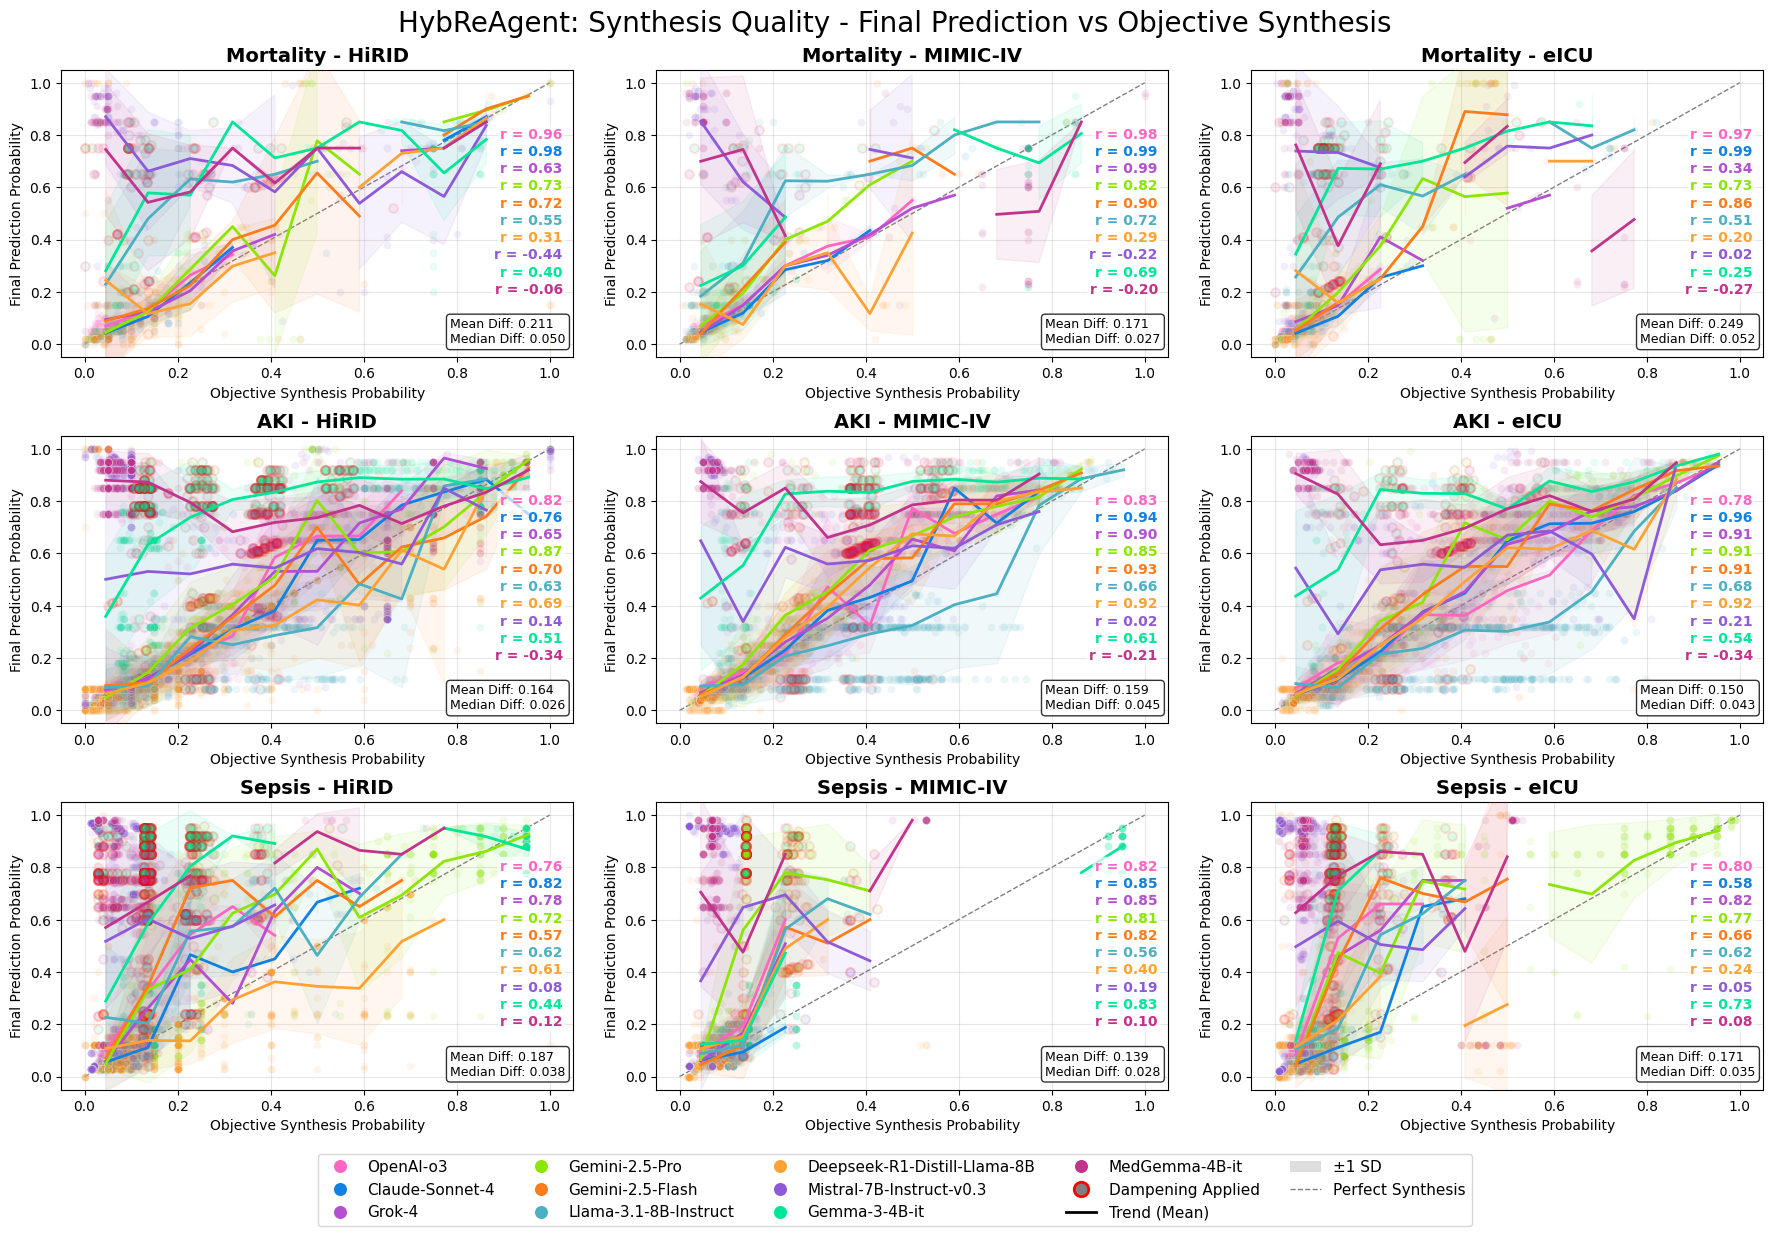

In [ ]:
# Synthesis Quality Analysis
print("\n" + "=" * 80)
print("SYNTHESIS QUALITY AND DAMPENING ANALYSIS")
print("=" * 80)


def convert_to_numeric_safe(series, default_value=0.0):
    """Safely convert a series to numeric, handling mixed types."""
    if series.dtype == "object":
        # Try to convert to numeric, coercing errors to NaN
        numeric_series = pd.to_numeric(series, errors="coerce")
        # Fill NaN values with default
        return numeric_series.fillna(default_value)
    elif pd.api.types.is_numeric_dtype(series):
        return series.fillna(default_value)
    else:
        # If it's another type, try conversion
        try:
            return pd.to_numeric(series, errors="coerce").fillna(default_value)
        except:
            return pd.Series([default_value] * len(series), index=series.index)


def create_synthesis_analysis_plot(models=None):
    """Create visualization showing synthesis quality and dampening effects, with trend lines and correlation.

    Args:
        models (list, optional): List of model names to include. If None, includes all models.
    """

    # Filter samples with complete synthesis data
    synthesis_data = df_sample_evolution[
        (df_sample_evolution["final_prediction"].notna())
        & (df_sample_evolution["objective_synthesis"].notna())
    ].copy()

    # Filter by models if specified
    if models is not None:
        # Ensure models follow LLM_MODELS order
        ordered_models = [m for m in LLM_MODELS if m in models]
        synthesis_data = synthesis_data[synthesis_data["model"].isin(ordered_models)]
        synthesis_data["model"] = pd.Categorical(
            synthesis_data["model"], categories=ordered_models, ordered=True
        )

    # Convert columns to numeric
    synthesis_data["final_prediction_numeric"] = convert_to_numeric_safe(
        synthesis_data["final_prediction"]
    )
    synthesis_data["objective_synthesis_numeric"] = convert_to_numeric_safe(
        synthesis_data["objective_synthesis"]
    )

    print(f"Samples with complete synthesis data: {len(synthesis_data):,}")

    # Create 3x3 grid
    tasks = ["Mortality", "AKI", "Sepsis"]
    datasets = ["HiRID", "MIMIC-IV", "eICU"]

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))

    # Update title to reflect selected models
    if models is not None:
        model_str = f" ({', '.join(models)})"
        title = f"HybReAgent: Synthesis Quality - Final Prediction vs Objective Synthesis by Model"
    else:
        title = (
            "HybReAgent: Synthesis Quality - Final Prediction vs Objective Synthesis"
        )

    fig.suptitle(title, fontsize=20, y=0.98)

    # Prepare legend elements
    legend_elements = []
    # Always use LLM_MODELS order, but only those present in synthesis_data
    ordered_models = [m for m in LLM_MODELS if m in synthesis_data["model"].unique()]
    for model in ordered_models:
        color = get_model_color(model)
        legend_elements.append(
            mlines.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markerfacecolor=color,
                markeredgecolor="white",
                markersize=8,
                label=model,
                alpha=1,
            )
        )
    # Dampening highlight
    legend_elements.append(
        mlines.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="gray",
            markeredgecolor="red",
            markeredgewidth=2,
            markersize=8,
            label="Dampening Applied",
            alpha=1,
        )
    )
    # Trend line
    legend_elements.append(
        mlines.Line2D(
            [0], [0], color="black", linewidth=2, label="Trend (Mean)", alpha=1
        )
    )
    # Std fill
    legend_elements.append(Patch(facecolor="black", alpha=0.13, label="±1 SD"))
    # Diagonal
    legend_elements.append(
        mlines.Line2D(
            [0],
            [0],
            color="k",
            linestyle="--",
            linewidth=1,
            label="Perfect Synthesis",
            alpha=0.5,
        )
    )

    for i, task in enumerate(tasks):
        for j, dataset in enumerate(datasets):
            ax = axes[i, j]

            # Filter data for this task-dataset
            task_data = synthesis_data[
                (synthesis_data["task"] == task)
                & (synthesis_data["dataset"] == dataset)
            ]

            if len(task_data) == 0:
                ax.text(
                    0.5,
                    0.5,
                    f"No data for\n{task}-{dataset}",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                    fontsize=12,
                )
                ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
                continue

            # Clean dampening column if it exists
            if "dampening_applied" in task_data.columns:
                dampening_clean = task_data["dampening_applied"].astype(str).str.lower()
                dampening_clean = dampening_clean.map(
                    {"true": True, "false": False, "nan": False, "none": False}
                )
                task_data = task_data.copy()
                task_data["dampening_applied_clean"] = dampening_clean
            else:
                task_data["dampening_applied_clean"] = False

            # Plot all points (normal: transparent, dampened: highlighted)
            for model in [m for m in LLM_MODELS if m in task_data["model"].unique()]:
                model_data = task_data[task_data["model"] == model]
                color = get_model_color(model)
                # Normal points (not dampened)
                normal = model_data[model_data["dampening_applied_clean"] == False]
                ax.scatter(
                    normal["objective_synthesis_numeric"],
                    normal["final_prediction_numeric"],
                    c=color,
                    edgecolors="white",
                    linewidth=0.5,
                    alpha=0.10,
                    s=32,
                    label=None,
                    zorder=2,
                )
                # Dampened points (highlighted)
                dampened = model_data[model_data["dampening_applied_clean"] == True]
                ax.scatter(
                    dampened["objective_synthesis_numeric"],
                    dampened["final_prediction_numeric"],
                    c=color,
                    edgecolors=(1, 0, 0, 0.1),  # RGBA for red with alpha=0.5
                    linewidth=1.5,
                    alpha=0.10,
                    s=40,
                    label=None,
                    zorder=3,
                )

                # Trend line with std fill (model color)
                if len(model_data) > 10:
                    x = model_data["objective_synthesis_numeric"]
                    y = model_data["final_prediction_numeric"]
                    bins = np.linspace(0, 1, 12)
                    bin_centers = (bins[:-1] + bins[1:]) / 2
                    means = []
                    stds = []
                    for k in range(len(bins) - 1):
                        mask = (x >= bins[k]) & (x < bins[k + 1])
                        y_bin = y[mask]
                        if len(y_bin) > 0:
                            means.append(y_bin.mean())
                            stds.append(y_bin.std())
                        else:
                            means.append(np.nan)
                            stds.append(np.nan)
                    ax.plot(bin_centers, means, color=color, linewidth=2, zorder=4)
                    ax.fill_between(
                        bin_centers,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        color=color,
                        alpha=0.08,
                        zorder=3,
                    )

                # Correlation coefficient (per model)
                if len(model_data) > 10:
                    x = model_data["objective_synthesis_numeric"]
                    y = model_data["final_prediction_numeric"]
                    mask = x.notna() & y.notna()
                    if mask.sum() > 10:
                        corr = np.corrcoef(x[mask], y[mask])[0, 1]
                        # Place annotation on the right side (x=0.98), stacked by model index
                        model_idx = [m for m in LLM_MODELS if m in task_data["model"].unique()].index(model)
                        ax.text(
                            0.98,
                            0.80
                            - 0.06 * model_idx,  # Stack vertically by model index
                            f"r = {corr:.2f}",
                            transform=ax.transAxes,
                            fontsize=10,
                            fontweight="bold",
                            color=color,
                            ha="right",
                            va="top",
                            bbox=dict(
                                facecolor="white",
                                alpha=0.7,
                                edgecolor="none",
                                boxstyle="round,pad=0.2",
                            ),
                            zorder=10,
                        )

            # Add diagonal line (perfect synthesis agreement)
            ax.plot(
                [0, 1],
                [0, 1],
                "k--",
                alpha=0.5,
                linewidth=1,
                label="Perfect Synthesis",
                zorder=1,
            )

            # Formatting
            ax.set_xlim(-0.05, 1.05)
            ax.set_ylim(-0.05, 1.05)
            ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            ax.set_xticklabels([f"{x:.1f}" for x in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]], fontsize=10)
            ax.set_xlabel("Objective Synthesis Probability", fontsize=10)
            ax.set_ylabel("Final Prediction Probability", fontsize=10)
            ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
            ax.grid(True, alpha=0.3)

            # Calculate synthesis agreement statistics (now with numeric data)
            synthesis_diff = abs(
                task_data["final_prediction_numeric"]
                - task_data["objective_synthesis_numeric"]
            )
            mean_diff = synthesis_diff.mean()
            median_diff = synthesis_diff.median()

            # Place mean/median annotation in lower right corner
            ax.text(
                0.76,
                0.05,
                f"Mean Diff: {mean_diff:.3f}\nMedian Diff: {median_diff:.3f}",
                transform=ax.transAxes,
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
            )

    # Place legend below the grid, multi-column
    fig.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.04),
        fontsize=11,
        frameon=True,
        ncol=min(5, len(legend_elements)),
        markerscale=1.3,
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.93, bottom=0.08)
    model_suffix = f"_{'_'.join(models)}" if models else ""
    save_path = os.path.join(
        OUTPUT_BASE_DIR, f"synthesis_quality_analysis{model_suffix}.png"
    )
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    print(f"Synthesis quality plot saved to: {save_path}")
    plt.show()

    return fig


# Example usage:
# synthesis_selected_models = [
#     "Gemini-2.5-Flash",
#     "Llama-3.1-8B-Instruct",
#     "Mistral-7B-Instruct-v0.3",
# ]
synthesis_fig = create_synthesis_analysis_plot(models=None)

In [ ]:
# Improved: Detailed synthesis statistics with standard deviations and dampening effect on AUROC/AUPRC

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

print("\n" + "=" * 50)
print("DETAILED SYNTHESIS STATISTICS (with SD and Dampening AUROC/AUPRC)")
print("=" * 50)

# Prepare synthesis data
synthesis_data = df_sample_evolution[
    (df_sample_evolution["final_prediction"].notna())
    & (df_sample_evolution["objective_synthesis"].notna())
    & (df_sample_evolution["label"].notna())
].copy()

# Convert to numeric
synthesis_data["final_prediction_numeric"] = convert_to_numeric_safe(
    synthesis_data["final_prediction"]
)
synthesis_data["objective_synthesis_numeric"] = convert_to_numeric_safe(
    synthesis_data["objective_synthesis"]
)

# Synthesis agreement stats
synthesis_diff = abs(
    synthesis_data["final_prediction_numeric"]
    - synthesis_data["objective_synthesis_numeric"]
)
print(f"\nSynthesis Agreement Analysis (n={len(synthesis_data):,}):")
print(
    f"  Mean difference: {synthesis_diff.mean():.3f} (SD: {synthesis_diff.std():.3f})"
)
print(f"  Median difference: {synthesis_diff.median():.3f}")
print(f"  75th percentile: {synthesis_diff.quantile(0.75):.3f}")
print(f"  95th percentile: {synthesis_diff.quantile(0.95):.3f}")

print(f"\nSynthesis Quality by Task (mean ± SD):")
synthesis_by_task = (
    synthesis_data.groupby("task")
    .agg(
        mean_synthesis_diff=(
            "final_prediction_numeric",
            lambda x: (x - synthesis_data.loc[x.index, "objective_synthesis_numeric"])
            .abs()
            .mean(),
        ),
        std_synthesis_diff=(
            "final_prediction_numeric",
            lambda x: (x - synthesis_data.loc[x.index, "objective_synthesis_numeric"])
            .abs()
            .std(),
        ),
        n=("final_prediction_numeric", "count"),
    )
    .reset_index()
)
for _, row in synthesis_by_task.iterrows():
    print(
        f"  {row['task']}: {row['mean_synthesis_diff']:.3f} ± {row['std_synthesis_diff']:.3f} (n={int(row['n'])})"
    )

# Synthesis by task-dataset (with SD)
print(f"\nSynthesis Quality by Task-Dataset (mean ± SD):")
synthesis_by_task_dataset = (
    synthesis_data.groupby(["task", "dataset"])
    .agg(
        mean_synthesis_diff=(
            "final_prediction_numeric",
            lambda x: (x - synthesis_data.loc[x.index, "objective_synthesis_numeric"])
            .abs()
            .mean(),
        ),
        std_synthesis_diff=(
            "final_prediction_numeric",
            lambda x: (x - synthesis_data.loc[x.index, "objective_synthesis_numeric"])
            .abs()
            .std(),
        ),
        n=("final_prediction_numeric", "count"),
    )
    .reset_index()
)
for _, row in synthesis_by_task_dataset.iterrows():
    print(
        f"  {row['task']}-{row['dataset']}: {row['mean_synthesis_diff']:.3f} ± {row['std_synthesis_diff']:.3f} (n={int(row['n'])})"
    )

# Model differences in synthesis quality (with SD)
print(f"\nSynthesis Quality by Model (mean ± SD):")
synthesis_by_model = (
    synthesis_data.groupby("model")
    .agg(
        mean_synthesis_diff=(
            "final_prediction_numeric",
            lambda x: (x - synthesis_data.loc[x.index, "objective_synthesis_numeric"])
            .abs()
            .mean(),
        ),
        std_synthesis_diff=(
            "final_prediction_numeric",
            lambda x: (x - synthesis_data.loc[x.index, "objective_synthesis_numeric"])
            .abs()
            .std(),
        ),
        n=("final_prediction_numeric", "count"),
    )
    .reset_index()
    .sort_values("mean_synthesis_diff", ascending=True)
)
for _, row in synthesis_by_model.iterrows():
    print(
        f"  {row['model']}: {row['mean_synthesis_diff']:.3f} ± {row['std_synthesis_diff']:.3f} (n={int(row['n'])})"
    )

# Dampening analysis
if "dampening_applied" in df_sample_evolution.columns:
    dampening_data = synthesis_data[synthesis_data["dampening_applied"].notna()].copy()
    dampening_clean = dampening_data["dampening_applied"].astype(str).str.lower()
    dampening_clean = dampening_clean.map(
        {"true": True, "false": False, "nan": False, "none": False}
    )
    dampening_data["dampening_applied_clean"] = dampening_clean

    dampening_stats = dampening_data["dampening_applied_clean"].value_counts()
    total_dampening = dampening_stats.sum()

    print(f"\nDampening Application Analysis (n={total_dampening:,}):")
    for applied, count in dampening_stats.items():
        percentage = (count / total_dampening) * 100
        print(f"  Dampening {applied}: {count:,} ({percentage:.1f}%)")

    # Compare dampened vs non-dampened cases
    if (
        "original_clinical" in df_sample_evolution.columns
        and "dampened_clinical" in df_sample_evolution.columns
    ):
        dampened_cases = dampening_data[
            dampening_data["dampening_applied_clean"] == True
        ].copy()
        if len(dampened_cases) > 0:
            dampened_cases["original_clinical_numeric"] = convert_to_numeric_safe(
                dampened_cases["original_clinical"]
            )
            dampened_cases["dampened_clinical_numeric"] = convert_to_numeric_safe(
                dampened_cases["dampened_clinical"]
            )
            original_dampened_diff = abs(
                dampened_cases["original_clinical_numeric"]
                - dampened_cases["dampened_clinical_numeric"]
            )
            print(
                f"\n  Average dampening effect: {original_dampened_diff.mean():.3f} (SD: {original_dampened_diff.std():.3f})"
            )

    # --- AUROC/AUPRC for dampened vs non-dampened subgroups ---
    print("\nDampening Effect on AUROC/AUPRC (Final Prediction):")
    for dampened, label in [(True, "Dampened"), (False, "Not Dampened")]:
        subset = dampening_data[dampening_data["dampening_applied_clean"] == dampened]
        if len(subset) > 1 and len(subset["label"].unique()) > 1:
            y_true = subset["label"].astype(int)
            y_pred = subset["final_prediction_numeric"]
            try:
                auroc = roc_auc_score(y_true, y_pred)
                precision, recall, _ = precision_recall_curve(y_true, y_pred)
                auprc = auc(recall, precision)
                print(
                    f"  {label}: AUROC={auroc:.3f}, AUPRC={auprc:.3f} (n={len(subset)})"
                )
            except Exception as e:
                print(f"  {label}: AUROC/AUPRC not computable ({e})")
        else:
            print(f"  {label}: Not enough data for AUROC/AUPRC.")

else:
    print(f"\nDampening Application Analysis: No dampening data available")


DETAILED SYNTHESIS STATISTICS (with SD and Dampening AUROC/AUPRC)

Synthesis Agreement Analysis (n=47,736):
  Mean difference: 0.166 (SD: 0.275)
  Median difference: 0.031
  75th percentile: 0.120
  95th percentile: 0.861

Synthesis Quality by Task (mean ± SD):
  AKI: 0.160 ± 0.254 (n=17680)
  Mortality: 0.214 ± 0.302 (n=2773)
  Sepsis: 0.165 ± 0.284 (n=27283)

Synthesis Quality by Task-Dataset (mean ± SD):
  AKI-HiRID: 0.164 ± 0.272 (n=9820)
  AKI-MIMIC-IV: 0.159 ± 0.234 (n=4144)
  AKI-eICU: 0.150 ± 0.227 (n=3716)
  Mortality-HiRID: 0.211 ± 0.295 (n=1000)
  Mortality-MIMIC-IV: 0.171 ± 0.276 (n=774)
  Mortality-eICU: 0.249 ± 0.323 (n=999)
  Sepsis-HiRID: 0.187 ± 0.282 (n=8785)
  Sepsis-MIMIC-IV: 0.139 ± 0.277 (n=9442)
  Sepsis-eICU: 0.171 ± 0.291 (n=9056)

Synthesis Quality by Model (mean ± SD):
  Claude-Sonnet-4: 0.016 ± 0.056 (n=4565)
  Grok-4: 0.025 ± 0.097 (n=4819)
  OpenAI-o3: 0.046 ± 0.076 (n=4739)
  Gemini-2.5-Flash: 0.068 ± 0.159 (n=4460)
  Deepseek-R1-Distill-Llama-8B: 0.080 

## 5. XGBoost Feature Importance Analysis

This section analyzes the most important clinical features identified by XGBoost across different task-dataset combinations.

In [ ]:
# XGBoost Feature Importance Analysis
print("\n" + "="*80)
print("XGBOOST FEATURE IMPORTANCE ANALYSIS")
print("="*80)

def extract_xgboost_features_by_task_dataset():
    """
    Extract unique XGBoost feature importance per task-dataset combination.
    Since XGBoost is trained once per task-dataset combination, features should be identical
    across all samples within the same combination.
    """
    
    # Filter to samples that have XGBoost feature importance data
    xgb_data = df_hra_clean[
        (df_hra_clean['Step_Category'] == 'ML Interpretation') &
        (df_hra_clean['metadata_ml_top_unique_features'].notna())
    ].copy()
    
    print(f"Samples with XGBoost feature data: {len(xgb_data):,}")
    
    # Parse the string representation of feature lists back to actual lists
    def parse_feature_list(feature_str):
        """Parse string representation of feature list back to list."""
        if pd.isna(feature_str):
            return []
        try:
            # Remove extra quotes and brackets, then split
            cleaned = str(feature_str).strip("[]'\"").replace("'", "").replace('"', '')
            if cleaned:
                features = [f.strip() for f in cleaned.split(',') if f.strip()]
                return features
            return []
        except Exception as e:
            print(f"Error parsing feature string: {feature_str}, Error: {e}")
            return []
    
    xgb_data['parsed_features'] = xgb_data['metadata_ml_top_unique_features'].apply(parse_feature_list)
    
    # Group by task-dataset and get unique feature sets
    xgb_features_by_task_dataset = {}
    
    for (task, dataset), group in xgb_data.groupby(['task', 'dataset']):
        # Get all feature lists for this task-dataset combination
        all_feature_lists = group['parsed_features'].tolist()
        
        # Since XGBoost is trained once per task-dataset, features should be consistent
        # Let's check for consistency and get the most common feature set
        unique_feature_sets = []
        for feature_list in all_feature_lists:
            if feature_list and feature_list not in unique_feature_sets:
                unique_feature_sets.append(feature_list)
        
        if unique_feature_sets:
            # Use the first non-empty feature set (they should all be the same)
            primary_features = unique_feature_sets[0]
            
            # Check for consistency
            if len(unique_feature_sets) > 1:
                print(f"WARNING: Multiple feature sets found for {task}-{dataset}: {len(unique_feature_sets)} different sets")
                # Use the most common one
                from collections import Counter
                feature_set_counts = Counter([tuple(fs) for fs in unique_feature_sets])
                most_common_set = list(feature_set_counts.most_common(1)[0][0])
                primary_features = most_common_set
            
            xgb_features_by_task_dataset[(task, dataset)] = {
                'features': primary_features,
                'sample_count': len(group),
                'unique_sets_found': len(unique_feature_sets)
            }
            
            print(f"{task}-{dataset}: {len(primary_features)} features, {len(group):,} samples, {len(unique_feature_sets)} unique sets")
    
    return xgb_features_by_task_dataset

def get_task_specific_features_from_data_util():
    """Get task-specific features from data_util.py"""
    
    tasks = ['mortality', 'aki', 'sepsis']
    task_specific_features = {}
    
    for task in tasks:
        features = get_priority_features_for_task(task)
        task_specific_features[task] = list(features)
        print(f"Task-specific features for {task}: {len(features)} features")
        print(f"  Features: {sorted(features)}")
    
    return task_specific_features

def map_xgb_to_data_util_features(xgb_feature_name):
    """
    Map XGBoost feature names to data_util feature keys.
    XGBoost features often have temporal suffixes or transformations.
    """
    
    # Handle missing data indicators
    if xgb_feature_name.startswith("Missing: "):
        clinical_name = xgb_feature_name.replace("Missing: ", "")
        # Find matching abbreviation from features_dict
        for abbrev, (full_name, _, _) in features_dict.items():
            if full_name == clinical_name:
                return abbrev
        # Fallback to simple conversion
        return clinical_name.lower().replace(" ", "_")
    
    # Regular clinical name - find matching abbreviation
    for abbrev, (full_name, _, _) in features_dict.items():
        if full_name == xgb_feature_name:
            return abbrev
    
    # Try common aliases
    aliases = get_common_feature_aliases()
    normalized_name = xgb_feature_name.lower()
    if normalized_name in aliases:
        return aliases[normalized_name]
    
    # Extract base feature name (remove temporal suffixes)
    base_feature = xgb_feature_name.lower()
    
    # Remove common temporal patterns
    temporal_patterns = ['_min', '_max', '_mean', '_median', '_std', '_first', '_last', '_slope', '_range']
    for pattern in temporal_patterns:
        if pattern in base_feature:
            base_feature = base_feature.split(pattern)[0]
            break
    
    # Remove time window indicators (e.g., _24h, _12h)
    import re
    base_feature = re.sub(r'_\d+h?$', '', base_feature)
    
    # Check if this base feature exists in data_util
    if base_feature in features_dict:
        return base_feature
    
    # Final fallback - return the simplified name
    return base_feature

def analyze_feature_overlap():
    """Analyze overlap between XGBoost features and task-specific features."""
    
    print("\n" + "="*60)
    print("FEATURE OVERLAP ANALYSIS")
    print("="*60)
    
    # Get XGBoost features by task-dataset
    xgb_features = extract_xgboost_features_by_task_dataset()
    
    # Get task-specific features from data_util
    task_specific = get_task_specific_features_from_data_util()
    
    # Analyze overlap for each task-dataset combination
    overlap_results = {}
    
    for (task, dataset), xgb_data in xgb_features.items():
        task_lower = task.lower()
        
        if task_lower not in task_specific:
            print(f"WARNING: No task-specific features found for {task}")
            continue
        
        # Map XGBoost features to data_util keys
        xgb_feature_names = xgb_data['features']
        mapped_xgb_features = set()
        
        for xgb_feat in xgb_feature_names:
            mapped_feat = map_xgb_to_data_util_features(xgb_feat)
            mapped_xgb_features.add(mapped_feat)
        
        # Get task-specific features
        task_features = set(task_specific[task_lower])
        
        # Calculate overlap
        overlap = mapped_xgb_features.intersection(task_features)
        xgb_only = mapped_xgb_features - task_features
        task_only = task_features - mapped_xgb_features
        
        # Calculate percentages
        overlap_pct_xgb = (len(overlap) / len(mapped_xgb_features)) * 100 if mapped_xgb_features else 0
        overlap_pct_task = (len(overlap) / len(task_features)) * 100 if task_features else 0
        
        overlap_results[(task, dataset)] = {
            'xgb_features': list(mapped_xgb_features),
            'task_features': list(task_features),
            'overlap': list(overlap),
            'xgb_only': list(xgb_only),
            'task_only': list(task_only),
            'overlap_pct_xgb': overlap_pct_xgb,
            'overlap_pct_task': overlap_pct_task,
            'original_xgb_features': xgb_feature_names  # Keep original names for reference
        }
        
        print(f"\n{task}-{dataset} Feature Overlap Analysis:")
        print(f"  XGBoost features: {len(mapped_xgb_features)} (mapped from {len(xgb_feature_names)} original)")
        print(f"  Task-specific features: {len(task_features)}")
        print(f"  Overlap: {len(overlap)} features ({overlap_pct_xgb:.1f}% of XGBoost, {overlap_pct_task:.1f}% of task-specific)")
        print(f"  Overlapping features: {sorted(overlap)}")
        print(f"  XGBoost only: {sorted(xgb_only)}")
        print(f"  Task-specific only: {sorted(task_only)}")
    
    return overlap_results

# Run the analysis
overlap_results = analyze_feature_overlap()

print(f"\n" + "="*80)
print("SUMMARY OF FINDINGS")
print("="*80)

print(f"\n1. XGBOOST MOST IMPORTANT FEATURES BY TASK-DATASET:")
for (task, dataset), results in overlap_results.items():
    print(f"\n{task}-{dataset}:")
    print(f"  Original XGBoost features: {results['original_xgb_features']}")
    print(f"  Mapped to data_util keys: {sorted(results['xgb_features'])}")

print(f"\n2. TASK-SPECIFIC FEATURES BY TASK:")
task_specific_features = get_task_specific_features_from_data_util()
for task, features in task_specific_features.items():
    print(f"\n{task.title()}: {sorted(features)}")

print(f"\n3. FEATURE OVERLAP SUMMARY:")
for (task, dataset), results in overlap_results.items():
    print(f"\n{task}-{dataset}:")
    print(f"  Overlap: {len(results['overlap'])}/{len(results['xgb_features'])} XGBoost features ({results['overlap_pct_xgb']:.1f}%)")
    print(f"  Overlap: {len(results['overlap'])}/{len(results['task_features'])} task-specific features ({results['overlap_pct_task']:.1f}%)")
    print(f"  Overlapping features: {sorted(results['overlap'])}")


XGBOOST FEATURE IMPORTANCE ANALYSIS

FEATURE OVERLAP ANALYSIS
Samples with XGBoost feature data: 61,889
AKI-HiRID: 10 features, 9,820 samples, 1 unique sets
AKI-MIMIC-IV: 10 features, 9,840 samples, 1 unique sets
AKI-eICU: 10 features, 9,840 samples, 1 unique sets
Mortality-HiRID: 10 features, 1,000 samples, 1 unique sets
Mortality-MIMIC-IV: 10 features, 1,000 samples, 1 unique sets
Mortality-eICU: 10 features, 1,000 samples, 1 unique sets
Sepsis-HiRID: 10 features, 9,690 samples, 1 unique sets
Sepsis-MIMIC-IV: 10 features, 9,900 samples, 1 unique sets
Sepsis-eICU: 10 features, 9,799 samples, 1 unique sets
Task-specific features for mortality: 20 features
  Features: ['alt', 'ast', 'be', 'bicar', 'bili', 'bun', 'crea', 'dbp', 'hr', 'inr_pt', 'lact', 'map', 'o2sat', 'pco2', 'ph', 'plt', 'po2', 'sbp', 'temp', 'urine']
Task-specific features for aki: 7 features
  Features: ['bun', 'crea', 'k', 'map', 'na', 'sbp', 'urine']
Task-specific features for sepsis: 17 features
  Features: ['bili'


CREATING PROPORTIONAL VENN DIAGRAM VISUALIZATION WITH FEATURE LIST ANNOTATIONS
Proportional Venn diagram visualization saved to: ./notebook_output/pulse_agents_hybreagent/xgboost_feature_overlap_analysis_venn_proportional.png


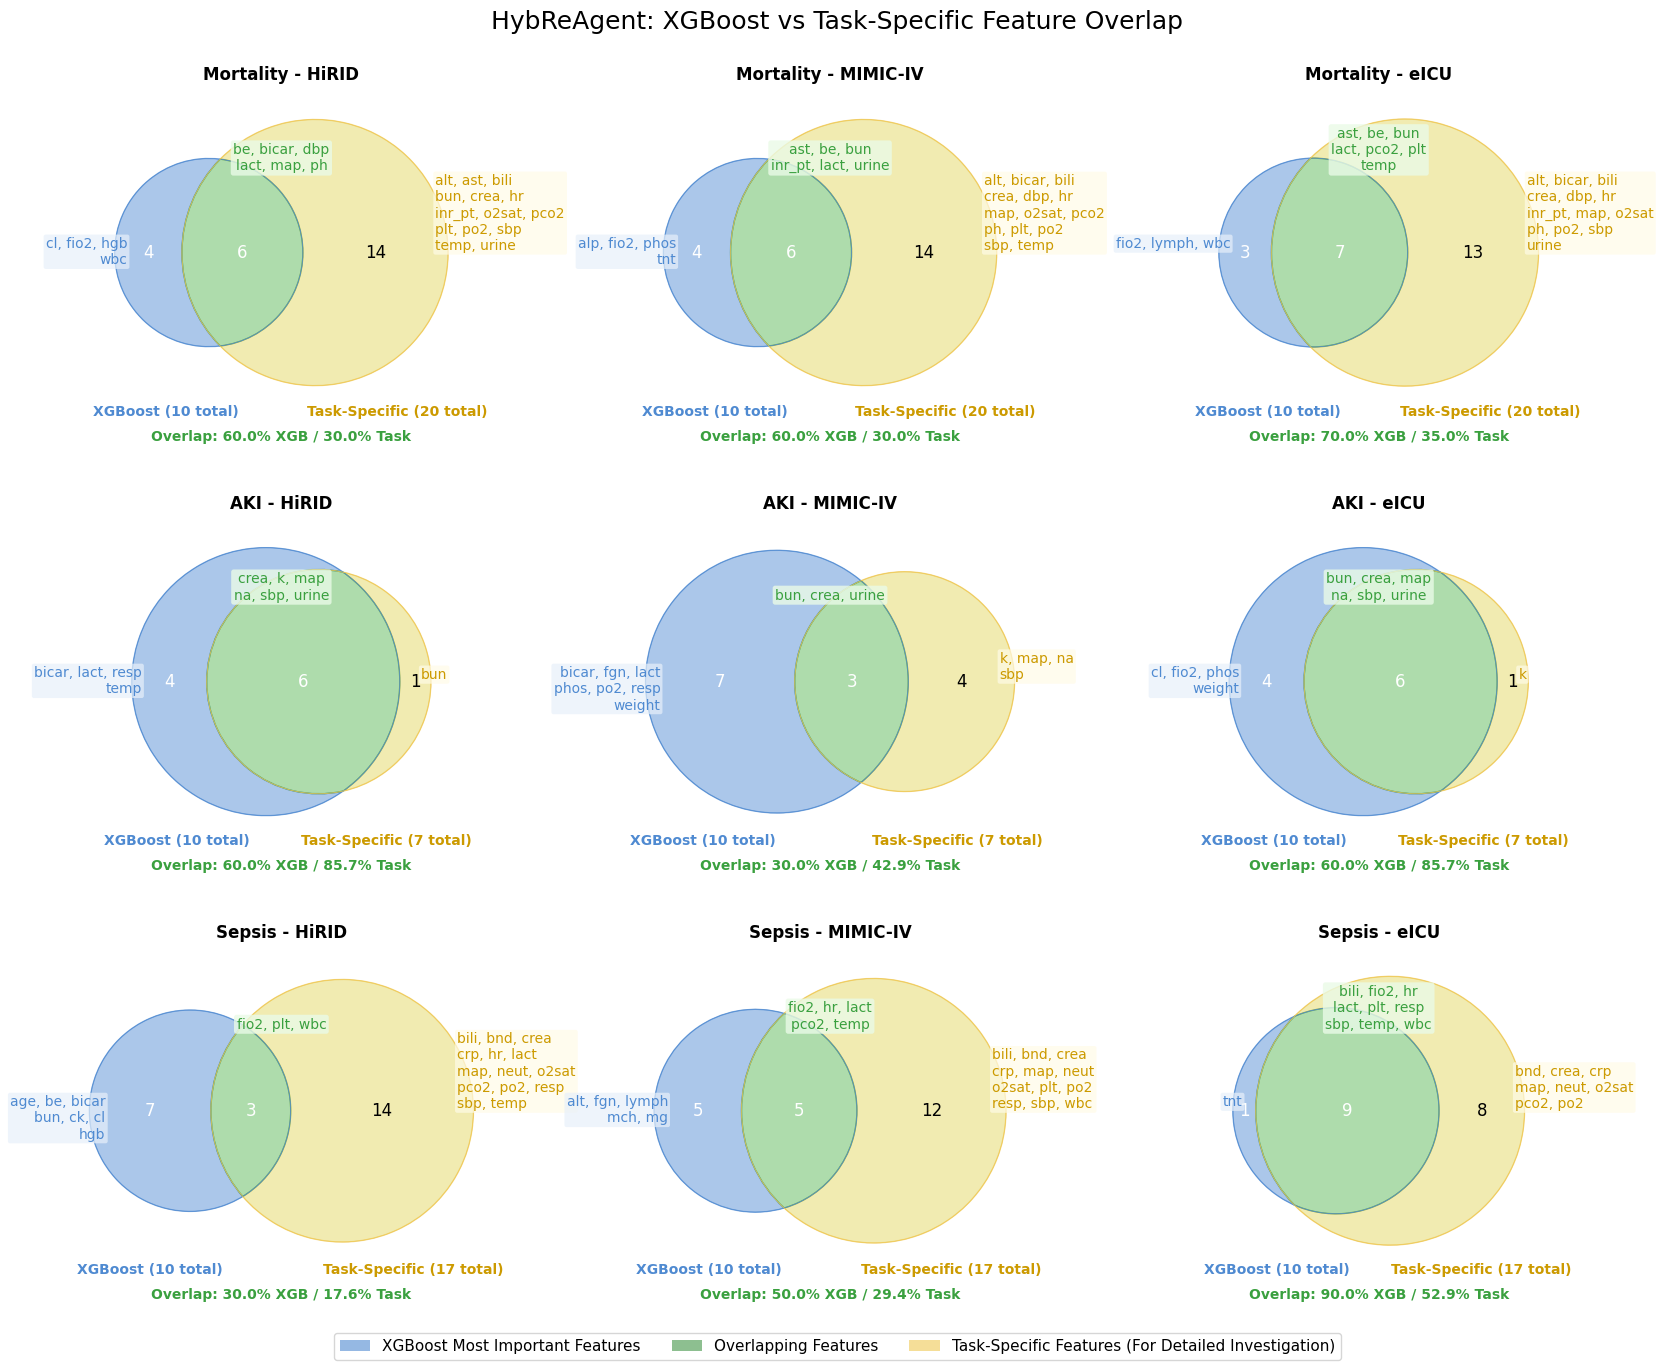

In [ ]:
def create_feature_overlap_venn_visualization_proportional(
    overlap_results, task_specific_features
):
    """
    Create 3x3 grid visualization of feature overlap analysis using proportional Venn diagrams,
    and annotate each region with the feature lists (abbreviations only) next to the corresponding area.
    """
    import matplotlib.pyplot as plt
    from matplotlib_venn import venn2, venn2_circles
    from matplotlib.patches import Patch
    import os

    def format_feature_list(feats, max_per_line=3):
        if not feats:
            return "-"
        feats = sorted(feats)
        lines = []
        for i in range(0, len(feats), max_per_line):
            lines.append(", ".join(feats[i : i + max_per_line]))
        return "\n".join(lines)

    tasks = ["Mortality", "AKI", "Sepsis"]
    datasets = ["HiRID", "MIMIC-IV", "eICU"]

    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle(
        "HybReAgent: XGBoost vs Task-Specific Feature Overlap",
        fontsize=18,
        y=0.96,
        ha="center",
    )

    for i, task in enumerate(tasks):
        for j, dataset in enumerate(datasets):
            ax = axes[i, j]
            key = (task, dataset)
            if key not in overlap_results:
                ax.text(
                    0.5,
                    0.5,
                    f"No XGBoost data\nfor {task}-{dataset}",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                    fontsize=12,
                )
                ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.axis("off")
                continue

            results = overlap_results[key]
            xgb_only_count = len(results["xgb_only"])
            task_only_count = len(results["task_only"])
            overlap_count = len(results["overlap"])
            total_xgb = len(results["xgb_features"])
            total_task = len(results["task_features"])
            overlap_pct_xgb = results["overlap_pct_xgb"]
            overlap_pct_task = results["overlap_pct_task"]

            try:
                if total_xgb == 0 and total_task == 0:
                    ax.text(
                        0.5,
                        0.5,
                        f"No features\nfor {task}-{dataset}",
                        ha="center",
                        va="center",
                        transform=ax.transAxes,
                        fontsize=12,
                    )
                    ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
                    ax.axis("off")
                    continue
                elif total_xgb == 0:
                    ax.text(
                        0.5,
                        0.5,
                        f"Only Task-Specific\nFeatures\n({total_task} features)",
                        ha="center",
                        va="center",
                        transform=ax.transAxes,
                        fontsize=12,
                    )
                    ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
                    ax.axis("off")
                    continue
                elif total_task == 0:
                    ax.text(
                        0.5,
                        0.5,
                        f"Only XGBoost\nFeatures\n({total_xgb} features)",
                        ha="center",
                        va="center",
                        transform=ax.transAxes,
                        fontsize=12,
                    )
                    ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
                    ax.axis("off")
                    continue

                venn_diagram = venn2(
                    subsets=(xgb_only_count, task_only_count, overlap_count),
                    set_labels=("", ""),
                    ax=ax,
                )

                # Custom colors
                if venn_diagram.get_patch_by_id("10"):
                    venn_diagram.get_patch_by_id("10").set_facecolor("#74a3dc")
                    venn_diagram.get_patch_by_id("10").set_alpha(0.6)
                    venn_diagram.get_patch_by_id("10").set_edgecolor("#4f8ad1")
                    venn_diagram.get_patch_by_id("10").set_linewidth(1)
                if venn_diagram.get_patch_by_id("01"):
                    venn_diagram.get_patch_by_id("01").set_facecolor("#e8df7e")
                    venn_diagram.get_patch_by_id("01").set_alpha(0.6)
                    venn_diagram.get_patch_by_id("01").set_edgecolor("#efc854")
                    venn_diagram.get_patch_by_id("01").set_linewidth(1)
                if venn_diagram.get_patch_by_id("11"):
                    venn_diagram.get_patch_by_id("11").set_facecolor("#79c676")
                    venn_diagram.get_patch_by_id("11").set_alpha(0.6)
                    venn_diagram.get_patch_by_id("11").set_edgecolor("#429546")
                    venn_diagram.get_patch_by_id("11").set_linewidth(1)

                venn_circles = venn2_circles(
                    subsets=(xgb_only_count, task_only_count, overlap_count), ax=ax
                )
                if venn_circles and len(venn_circles) >= 2:
                    if venn_circles[0]:
                        venn_circles[0].set_edgecolor("#4f8ad1")
                        venn_circles[0].set_linewidth(0.5)
                        venn_circles[0].set_facecolor("none")
                    if venn_circles[1]:
                        venn_circles[1].set_edgecolor("#efc854")
                        venn_circles[1].set_linewidth(0.5)
                        venn_circles[1].set_facecolor("none")

                # Label counts
                if venn_diagram.get_label_by_id("10") and xgb_only_count > 0:
                    venn_diagram.get_label_by_id("10").set_text(str(xgb_only_count))
                    venn_diagram.get_label_by_id("10").set_fontsize(12)
                    venn_diagram.get_label_by_id("10").set_color("white")
                if venn_diagram.get_label_by_id("01") and task_only_count > 0:
                    venn_diagram.get_label_by_id("01").set_text(str(task_only_count))
                    venn_diagram.get_label_by_id("01").set_fontsize(12)
                    venn_diagram.get_label_by_id("01").set_color("black")
                if venn_diagram.get_label_by_id("11") and overlap_count > 0:
                    venn_diagram.get_label_by_id("11").set_text(str(overlap_count))
                    venn_diagram.get_label_by_id("11").set_fontsize(12)
                    venn_diagram.get_label_by_id("11").set_color("white")

                # Set labels and overlap percentages below
                ax.text(
                    0.2,
                    -0.0,
                    f"XGBoost ({total_xgb} total)",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                    fontsize=10,
                    color="#4f8ad1",
                    fontweight="bold",
                )
                ax.text(
                    0.8,
                    -0.0,
                    f"Task-Specific ({total_task} total)",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                    fontsize=10,
                    color="#cc9a00",
                    fontweight="bold",
                )
                overlap_text = f"Overlap: {overlap_pct_xgb:.1f}% XGB / {overlap_pct_task:.1f}% Task"
                ax.text(
                    0.5,
                    -0.08,
                    overlap_text,
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                    fontsize=10,
                    color="#3aa03f",
                    fontweight="bold",
                )

                # --- Annotate feature lists next to Venn regions ---
                # Get region centers (empirically determined for matplotlib_venn)
                # Adjust y-coordinates to avoid overlap
                region_coords = {
                    "10": (0.1, 0.55),  # XGBoost only (left)
                    "01": (0.9, 0.5),  # Task-specific only (right)
                    "11": (0.5, 0.75),  # Overlap (center top)
                }
                # XGBoost only
                ax.text(
                    region_coords["10"][0],
                    region_coords["10"][1],
                    format_feature_list(results["xgb_only"]),
                    ha="right",
                    va="top",
                    fontsize=10,
                    color="#4f8ad1",
                    bbox=dict(
                        facecolor="#e7f0fa",
                        alpha=0.7,
                        edgecolor="none",
                        boxstyle="round,pad=0.15",
                    ),
                    transform=ax.transAxes,
                )
                # Task-specific only
                ax.text(
                    region_coords["01"][0],
                    region_coords["01"][1],
                    format_feature_list(results["task_only"]),
                    ha="left",
                    va="bottom",
                    fontsize=10,
                    color="#cc9a00",
                    bbox=dict(
                        facecolor="#fffbe7",
                        alpha=0.7,
                        edgecolor="none",
                        boxstyle="round,pad=0.15",
                    ),
                    transform=ax.transAxes,
                )
                # Overlap
                ax.text(
                    region_coords["11"][0],
                    region_coords["11"][1],
                    format_feature_list(results["overlap"]),
                    ha="center",
                    va="bottom",
                    fontsize=10,
                    color="#3aa03f",
                    bbox=dict(
                        facecolor="#eafbe7",
                        alpha=0.8,
                        edgecolor="none",
                        boxstyle="round,pad=0.18",
                    ),
                    transform=ax.transAxes,
                )

            except Exception as e:
                print(
                    f"Warning: Could not create Venn diagram for {task}-{dataset}: {e}"
                )
                ax.text(
                    0.5,
                    0.5,
                    f"Venn diagram\nerror for\n{task}-{dataset}\n(Error: {str(e)[:30]}...)",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                    fontsize=10,
                    color="red",
                )
                ax.axis("off")

            ax.set_title(f"{task} - {dataset}", fontsize=12, fontweight="bold", pad=10)

    # Add legend
    legend_elements = [
        Patch(facecolor="#4f8ad1", alpha=0.6, label="XGBoost Most Important Features"),
        Patch(facecolor="#429546", alpha=0.6, label="Overlapping Features"),
        Patch(
            facecolor="#efc854",
            alpha=0.6,
            label="Task-Specific Features (For Detailed Investigation)",
        ),
    ]
    fig.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.01),
        ncol=3,
        fontsize=11,
        frameon=True,
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.06, hspace=0.35, wspace=0.0)

    # Save plot
    save_path = os.path.join(
        OUTPUT_BASE_DIR, "xgboost_feature_overlap_analysis_venn_proportional.png"
    )
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    print(f"Proportional Venn diagram visualization saved to: {save_path}")
    plt.show()

    return fig


# Create the Venn diagram visualization with proportional circles and feature lists as annotations
print("\n" + "=" * 80)
print("CREATING PROPORTIONAL VENN DIAGRAM VISUALIZATION WITH FEATURE LIST ANNOTATIONS")
print("=" * 80)

overlap_fig_venn = create_feature_overlap_venn_visualization_proportional(
    overlap_results, task_specific_features
)

In [ ]:
def create_detailed_feature_lists_visualization(
    overlap_results, task_specific_features
):
    """Create detailed visualization showing actual feature lists."""

    print("\n" + "=" * 80)
    print("DETAILED FEATURE LISTS BY TASK-DATASET")
    print("=" * 80)

    # Create text-based detailed breakdown
    for (task, dataset), results in overlap_results.items():
        print(f"\n{task.upper()} - {dataset.upper()}:")
        print("-" * 50)

        print(
            f"\nXGBoost Most Important Features ({len(results['original_xgb_features'])}):"
        )
        for i, feat in enumerate(results["original_xgb_features"], 1):
            print(f"  {i:2d}. {feat}")

        print(f"\nTask-Specific Features ({len(results['task_features'])}):")
        task_feats = sorted(results["task_features"])
        for i, feat in enumerate(task_feats, 1):
            # Get full name from data_util
            from src.util.data_util import get_feature_name

            full_name = get_feature_name(feat)
            print(f"  {i:2d}. {feat} ({full_name})")

        print(f"\nOverlapping Features ({len(results['overlap'])}):")
        overlap_feats = sorted(results["overlap"])
        for i, feat in enumerate(overlap_feats, 1):
            from src.util.data_util import get_feature_name

            full_name = get_feature_name(feat)
            print(f"  {i:2d}. {feat} ({full_name})")

        print(f"\nXGBoost-Only Features ({len(results['xgb_only'])}):")
        xgb_only_feats = sorted(results["xgb_only"])
        for i, feat in enumerate(xgb_only_feats, 1):
            print(f"  {i:2d}. {feat}")

        print(f"\nTask-Specific-Only Features ({len(results['task_only'])}):")
        task_only_feats = sorted(results["task_only"])
        for i, feat in enumerate(task_only_feats, 1):
            from src.util.data_util import get_feature_name

            full_name = get_feature_name(feat)
            print(f"  {i:2d}. {feat} ({full_name})")


# Create detailed feature lists
create_detailed_feature_lists_visualization(overlap_results, task_specific_features)


DETAILED FEATURE LISTS BY TASK-DATASET

AKI - HIRID:
--------------------------------------------------

XGBoost Most Important Features (10):
   1. Systolic Blood Pressure
   2. Mean Arterial Pressure (MAP)
   3. Urine Output
   4. Creatinine
   5. Temperature
   6. Potassium
   7. Respiratory Rate
   8. Bicarbonate
   9. Lactate
  10. Sodium

Task-Specific Features (7):
   1. bun (Blood Urea Nitrogen (BUN))
   2. crea (Creatinine)
   3. k (Potassium)
   4. map (Mean Arterial Pressure (MAP))
   5. na (Sodium)
   6. sbp (Systolic Blood Pressure)
   7. urine (Urine Output)

Overlapping Features (6):
   1. crea (Creatinine)
   2. k (Potassium)
   3. map (Mean Arterial Pressure (MAP))
   4. na (Sodium)
   5. sbp (Systolic Blood Pressure)
   6. urine (Urine Output)

XGBoost-Only Features (4):
   1. bicar
   2. lact
   3. resp
   4. temp

Task-Specific-Only Features (1):
   1. bun (Blood Urea Nitrogen (BUN))

AKI - MIMIC-IV:
--------------------------------------------------

XGBoost Most 

## 6. Qualitative Assessment

In [ ]:
def analyze_agent_corrections(
    model_name=None, threshold=0.5, df=None, print_overview=True, return_details=False
):
    """
    Identify sample_index where the agent (final_prediction) corrected a wrong XGBoost prediction (step0_ml_prediction)
    or made a correct prediction wrong, for each task-dataset combination for a given model.

    Args:
        model_name (str or None): Model to print overview for (e.g., "Gemini-2.5-Flash"). If None, print all.
        threshold (float): Probability threshold for binary classification (default: 0.5)
        df (pd.DataFrame): DataFrame to use (default: df_sample_evolution)
        print_overview (bool): Print summary statistics and examples
        return_details (bool): If True, return a DataFrame with all details

    Returns:
        pd.DataFrame: DataFrame with details for each model-task-dataset combination (if return_details=True)
    """
    if df is None:
        df = df_sample_evolution

    # Filter for samples with all required data
    filtered = df[
        df["step0_ml_prediction"].notna()
        & df["final_prediction"].notna()
        & df["label"].notna()
    ].copy()

    # Compute binary predictions
    filtered["xgb_pred"] = (filtered["step0_ml_prediction"] >= threshold).astype(int)
    filtered["agent_pred"] = (filtered["final_prediction"] >= threshold).astype(int)
    filtered["true_label"] = filtered["label"].astype(int)

    # Identify cases
    filtered["xgb_correct"] = filtered["xgb_pred"] == filtered["true_label"]
    filtered["agent_correct"] = filtered["agent_pred"] == filtered["true_label"]

    filtered["agent_corrected_wrong_xgb"] = (~filtered["xgb_correct"]) & (
        filtered["agent_correct"]
    )
    filtered["agent_made_correct_wrong"] = (filtered["xgb_correct"]) & (
        ~filtered["agent_correct"]
    )

    # Group by model, task, dataset
    group_cols = ["model", "task", "dataset"]

    rows = []
    for group_keys, group in filtered.groupby(group_cols):
        model, task, dataset = group_keys
        group_label = f"{model} | {task} - {dataset}"

        corrections = group[group["agent_corrected_wrong_xgb"]]
        regressions = group[group["agent_made_correct_wrong"]]

        # Directional indices for this group
        corr_false_to_true = corrections[
            (corrections["xgb_pred"] == 0) & (corrections["agent_pred"] == 1)
        ]["sample_index"].tolist()
        corr_true_to_false = corrections[
            (corrections["xgb_pred"] == 1) & (corrections["agent_pred"] == 0)
        ]["sample_index"].tolist()
        reg_false_to_true = regressions[
            (regressions["xgb_pred"] == 0) & (regressions["agent_pred"] == 1)
        ]["sample_index"].tolist()
        reg_true_to_false = regressions[
            (regressions["xgb_pred"] == 1) & (regressions["agent_pred"] == 0)
        ]["sample_index"].tolist()

        corrections_sorted = corrections.assign(
            diff=abs(
                corrections["final_prediction"] - corrections["step0_ml_prediction"]
            )
        ).sort_values("diff", ascending=False)
        regressions_sorted = regressions.assign(
            diff=abs(
                regressions["final_prediction"] - regressions["step0_ml_prediction"]
            )
        ).sort_values("diff", ascending=False)

        stats = dict(
            model=model,
            task=task,
            dataset=dataset,
            n_total=len(group),
            n_corrections=len(corrections),
            n_regressions=len(regressions),
            corrections_indices=list(corrections["sample_index"]),
            regressions_indices=list(regressions["sample_index"]),
            corrections_best=corrections_sorted.head(5)[
                [
                    "sample_index",
                    "true_label",
                    "step0_ml_prediction",
                    "final_prediction",
                    "diff",
                ]
            ],
            regressions_worst=regressions_sorted.head(5)[
                [
                    "sample_index",
                    "true_label",
                    "step0_ml_prediction",
                    "final_prediction",
                    "diff",
                ]
            ],
            corrections_label_counts=corrections["true_label"].value_counts().to_dict(),
            regressions_label_counts=regressions["true_label"].value_counts().to_dict(),
            corrections_mean_diff=corrections_sorted["diff"].mean()
            if len(corrections_sorted) > 0
            else None,
            regressions_mean_diff=regressions_sorted["diff"].mean()
            if len(regressions_sorted) > 0
            else None,
            corrections_false_to_true_indices=corr_false_to_true,
            corrections_true_to_false_indices=corr_true_to_false,
            regressions_false_to_true_indices=reg_false_to_true,
            regressions_true_to_false_indices=reg_true_to_false,
        )
        rows.append(stats)

        # Only print for the specified model (or all if model_name is None)
        if print_overview and (model_name is None or model == model_name):
            print(f"\n=== {group_label} ===")
            print(f"Total samples: {stats['n_total']}")
            print(
                f"Agent corrected wrong XGBoost predictions: {stats['n_corrections']}"
            )
            print(
                f"Agent made correct XGBoost predictions wrong: {stats['n_regressions']}"
            )
            print(
                f"  - Corrections label breakdown (True label): {stats['corrections_label_counts']}"
            )
            print(
                f"  - Regressions label breakdown (True label): {stats['regressions_label_counts']}"
            )
            print(
                f"  - Mean abs diff (corrections): {stats['corrections_mean_diff']:.3f}"
                if stats["corrections_mean_diff"] is not None
                else ""
            )
            print(
                f"  - Mean abs diff (regressions): {stats['regressions_mean_diff']:.3f}"
                if stats["regressions_mean_diff"] is not None
                else ""
            )

            print("\n  Top 5 biggest corrections (agent fixed XGBoost):")
            if len(stats["corrections_best"]) > 0:
                print(stats["corrections_best"].to_string(index=False))
            else:
                print("    None")

            print("\n  Top 5 biggest regressions (agent made correct wrong):")
            if len(stats["regressions_worst"]) > 0:
                print(stats["regressions_worst"].to_string(index=False))
            else:
                print("    None")

            print(f"  - Corrections False→True: {corr_false_to_true}")
            print(f"  - Corrections True→False: {corr_true_to_false}")
            print(f"  - Regressions False→True: {reg_false_to_true}")
            print(f"  - Regressions True→False: {reg_true_to_false}")

    if return_details:
        return pd.DataFrame(rows)

# Example usage:
# Analyze for OpenAI-o3 (prints only OpenAI-o3, but DataFrame includes all models)
correction_stats = analyze_agent_corrections("OpenAI-o3", threshold=0.5, print_overview=True, return_details=True)


=== OpenAI-o3 | AKI - HiRID ===
Total samples: 982
Agent corrected wrong XGBoost predictions: 8
Agent made correct XGBoost predictions wrong: 16
  - Corrections label breakdown (True label): {1: 8}
  - Regressions label breakdown (True label): {0: 16}
  - Mean abs diff (corrections): 0.346
  - Mean abs diff (regressions): 0.583

  Top 5 biggest corrections (agent fixed XGBoost):
 sample_index  true_label  step0_ml_prediction  final_prediction  diff
          673           1                 0.26              0.70  0.44
          981           1                 0.49              0.92  0.43
          249           1                 0.16              0.55  0.39
          250           1                 0.26              0.65  0.39
            6           1                 0.47              0.82  0.35

  Top 5 biggest regressions (agent made correct wrong):
 sample_index  true_label  step0_ml_prediction  final_prediction  diff
          181           0                 0.07              0.8

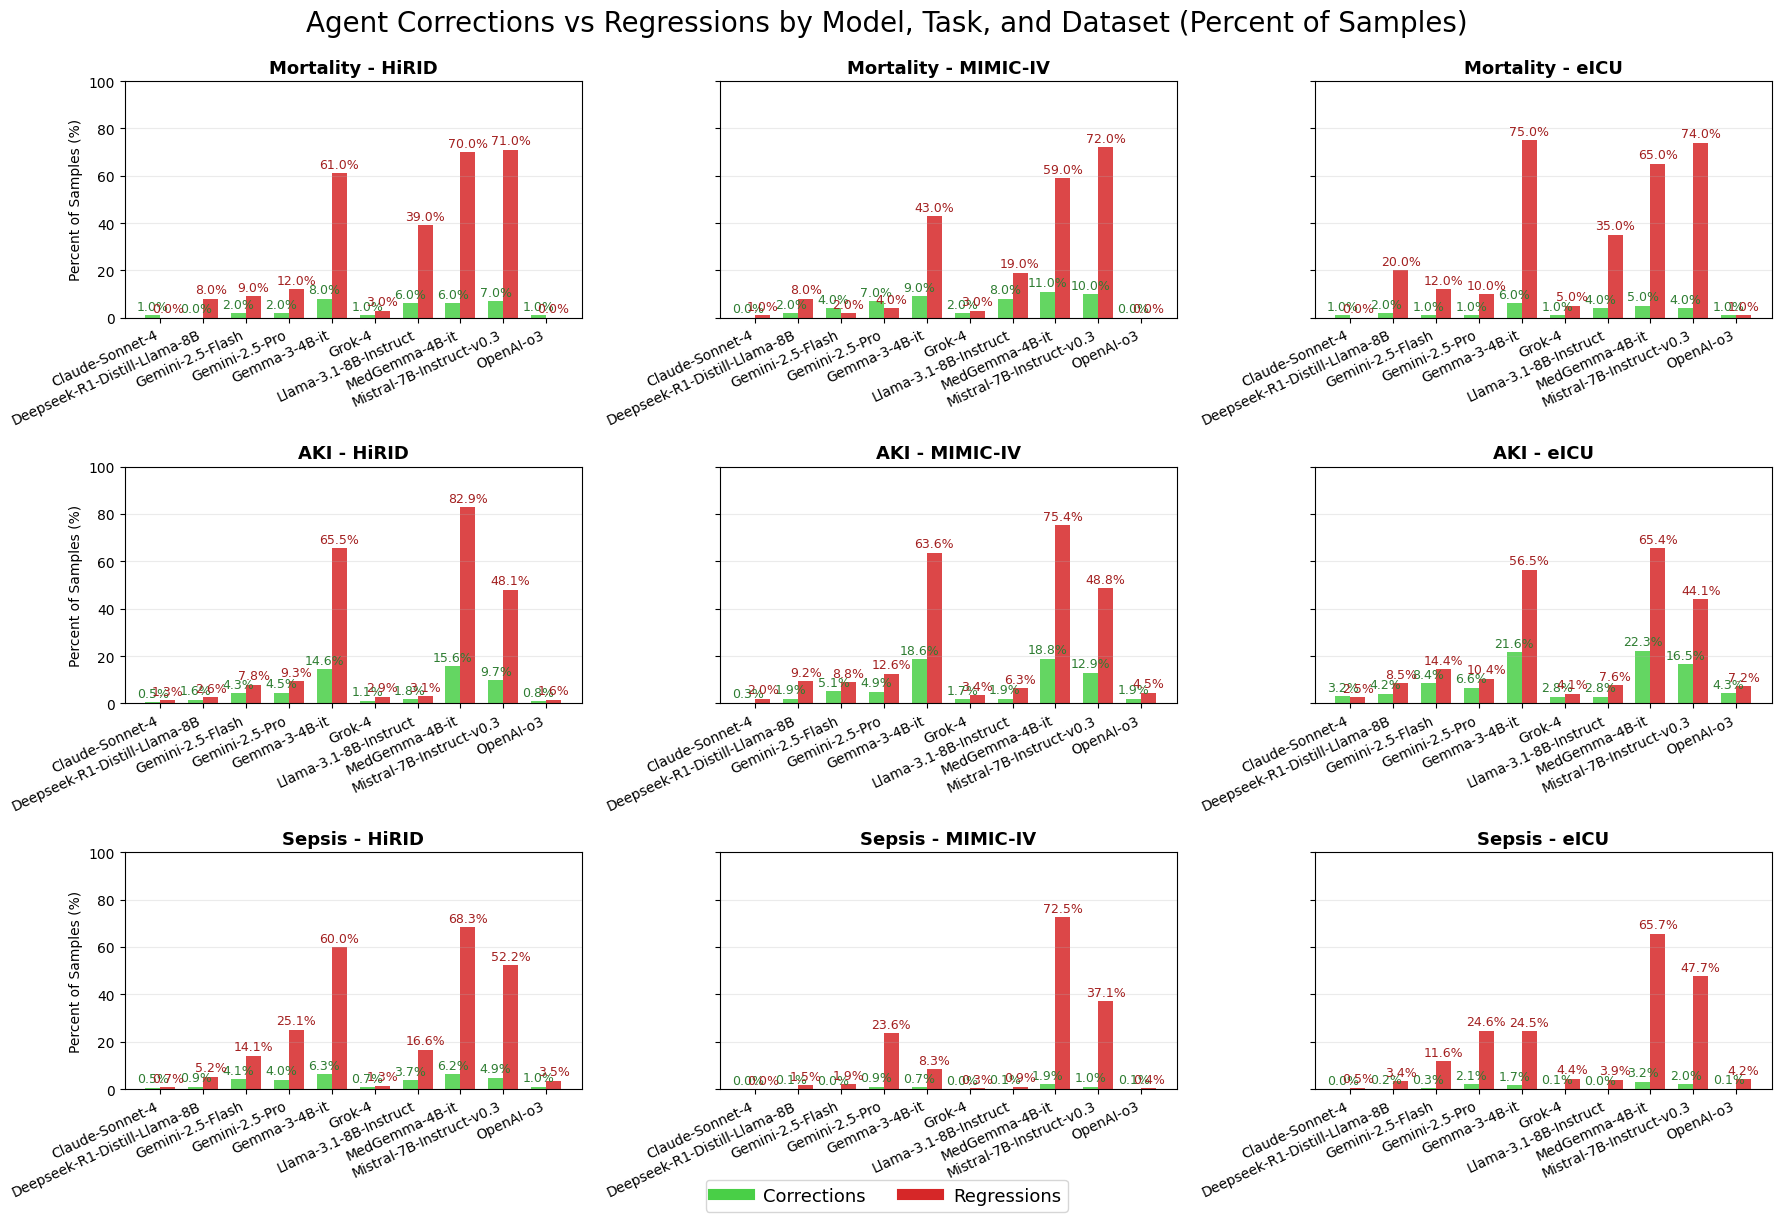

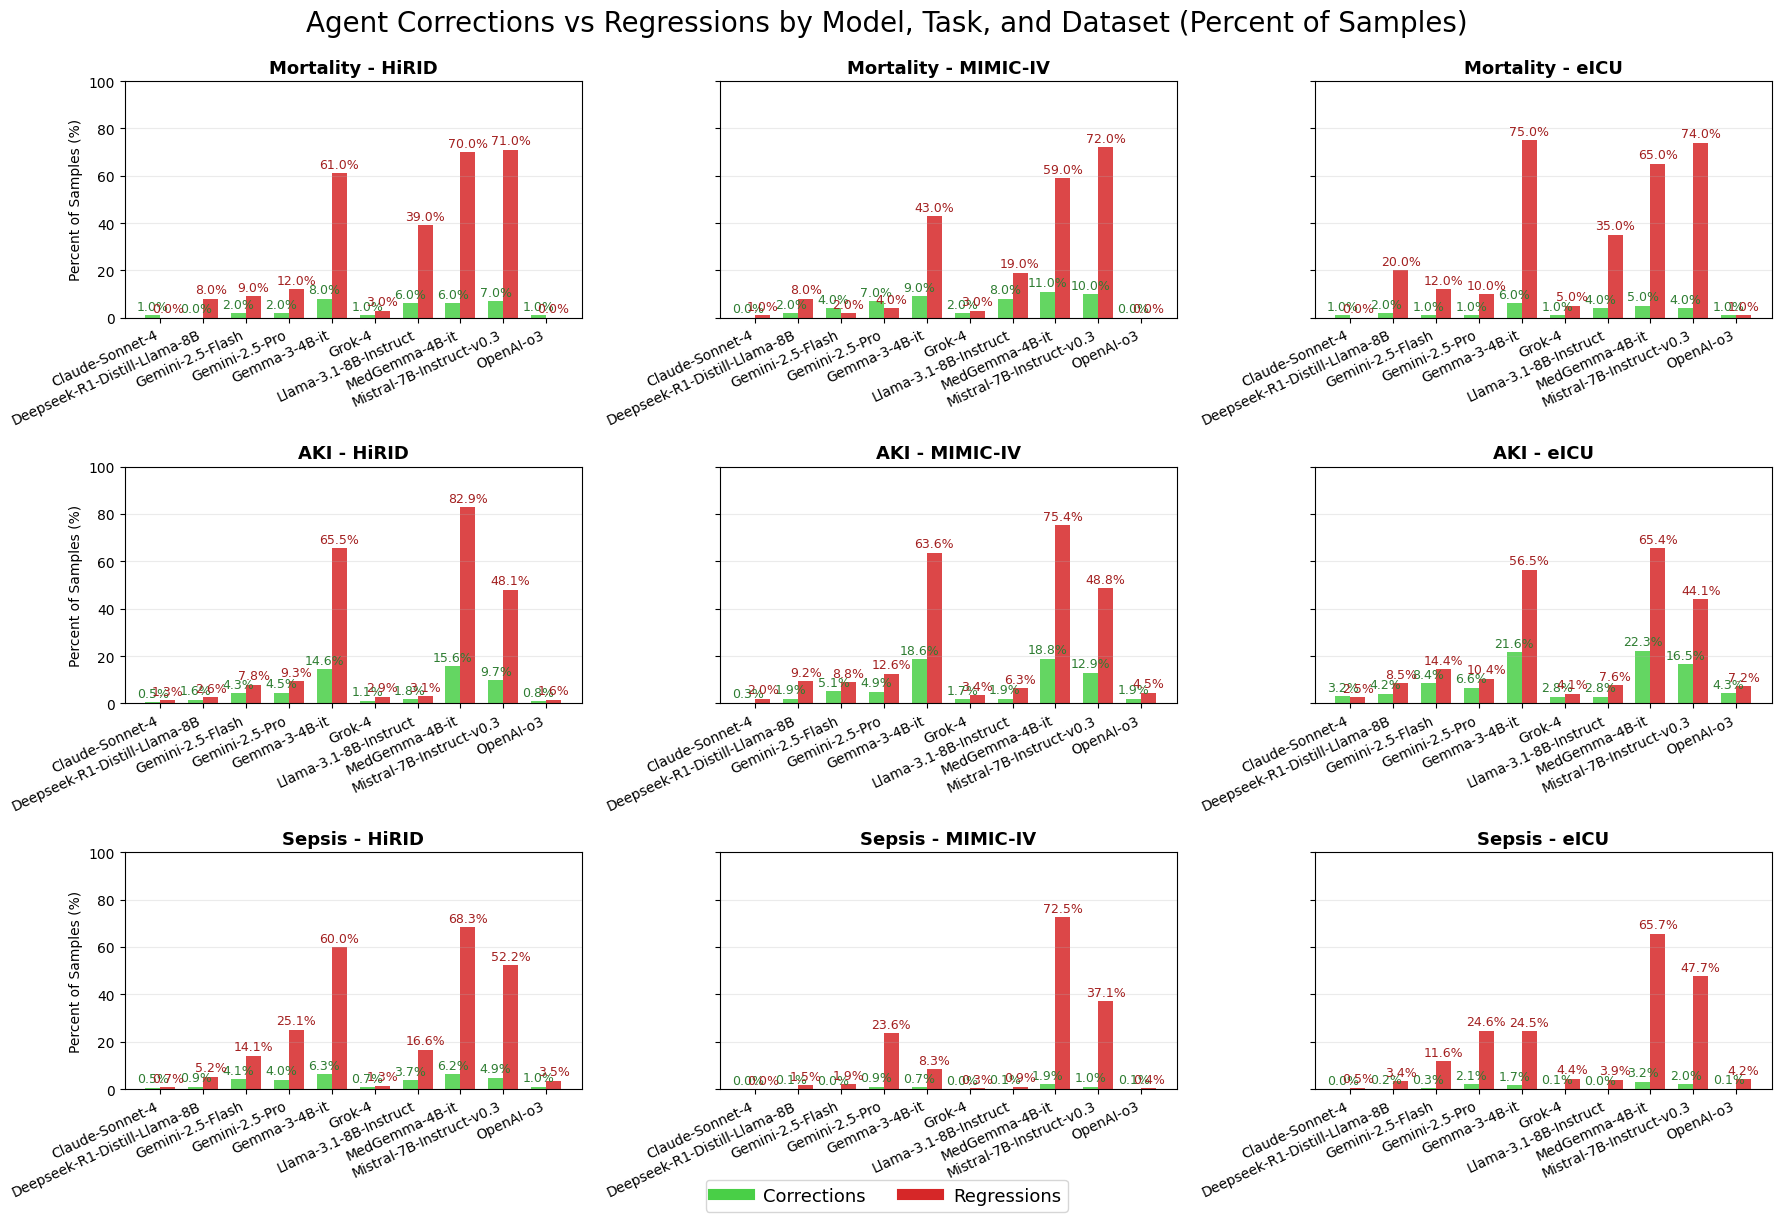

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_agent_correction_gridplot(
    correction_stats_df,
    threshold=0.5,
    models=None,
    figsize=(18, 12),
    save_path=None
):
    """
    Visualize agent corrections and regressions in a 3x3 grid (task x dataset) for all models.
    Each subplot shows a grouped barplot for each model:
    - Percentage of corrections (agent fixed XGBoost error)
    - Percentage of regressions (agent made correct XGBoost wrong)
    - Y axis is always 0-100 (% of samples for that group).

    Args:
        correction_stats_df (pd.DataFrame): Output from analyze_agent_corrections(..., return_details=True)
        threshold (float): Classification threshold (for title)
        models (list or None): List of models to include (default: all in stats)
        figsize (tuple): Figure size
        save_path (str or None): If set, save the figure to this path
    """
    # If input is not a DataFrame, convert
    if not isinstance(correction_stats_df, pd.DataFrame):
        correction_stats_df = pd.DataFrame(correction_stats_df)

    all_tasks = ["Mortality", "AKI", "Sepsis"]
    all_datasets = ["HiRID", "MIMIC-IV", "eICU"]

    # Filter models if needed
    all_models = sorted(correction_stats_df["model"].unique())
    if models is None:
        models = all_models

    # Prepare data for plotting
    plot_data = []
    for model in models:
        for task in all_tasks:
            for dataset in all_datasets:
                row = correction_stats_df[
                    (correction_stats_df["model"] == model)
                    & (correction_stats_df["task"] == task)
                    & (correction_stats_df["dataset"] == dataset)
                ]
                if not row.empty:
                    stats = row.iloc[0]
                    n_total = stats["n_total"]
                    # Avoid division by zero
                    corr_pct = 100 * stats["n_corrections"] / n_total if n_total else 0
                    reg_pct = 100 * stats["n_regressions"] / n_total if n_total else 0
                    plot_data.append({
                        "model": model,
                        "task": task,
                        "dataset": dataset,
                        "corrections_pct": corr_pct,
                        "regressions_pct": reg_pct,
                        "n_total": n_total,
                    })
                else:
                    plot_data.append({
                        "model": model,
                        "task": task,
                        "dataset": dataset,
                        "corrections_pct": 0,
                        "regressions_pct": 0,
                        "n_total": 0,
                    })
    plot_df = pd.DataFrame(plot_data)

    # Set up grid
    fig, axes = plt.subplots(3, 3, figsize=figsize, sharey=True)
    fig.suptitle(
        f"Agent Corrections vs Regressions by Model, Task, and Dataset (Percent of Samples)",
        fontsize=20, y=0.98
    )

    bar_width = 0.35
    for i, task in enumerate(all_tasks):
        for j, dataset in enumerate(all_datasets):
            ax = axes[i, j]
            subset = plot_df[(plot_df["task"] == task) & (plot_df["dataset"] == dataset)]
            if subset["n_total"].sum() == 0:
                ax.text(0.5, 0.5, f"No data\n{task}-{dataset}", ha="center", va="center", fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
                continue

            idx = np.arange(len(models))
            corrections_pct = subset["corrections_pct"].values
            regressions_pct = subset["regressions_pct"].values
            totals = subset["n_total"].values

            bars1 = ax.bar(idx - bar_width/2, corrections_pct, bar_width, label="Corrections", color="#49cf47", alpha=0.85)
            bars2 = ax.bar(idx + bar_width/2, regressions_pct, bar_width, label="Regressions", color="#d62728", alpha=0.85)

            # Annotate bars with % (the bar height itself)
            for bar, pct, n in zip(bars1, corrections_pct, totals):
                if n > 0:
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{pct:.1f}%", ha="center", va="bottom", fontsize=9, color="#2e7d32")
            for bar, pct, n in zip(bars2, regressions_pct, totals):
                if n > 0:
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{pct:.1f}%", ha="center", va="bottom", fontsize=9, color="#a32020")

            ax.set_xticks(idx)
            ax.set_xticklabels(models, rotation=25, ha="right", fontsize=10)
            ax.set_title(f"{task} - {dataset}", fontsize=13, fontweight="bold")
            ax.set_ylabel("Percent of Samples (%)" if j == 0 else "")
            ax.grid(True, axis="y", alpha=0.25)
            ax.set_ylim(0, 100)

    # Legend and layout
    handles = [
        plt.Line2D([0], [0], color="#49cf47", lw=8, label="Corrections"),
        plt.Line2D([0], [0], color="#d62728", lw=8, label="Regressions"),
    ]
    fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.03), ncol=2, fontsize=13, frameon=True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08)
    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches="tight")
        print(f"Agent correction gridplot saved to: {save_path}")
    plt.show()
    return fig

# Example usage:
correction_stats_all = analyze_agent_corrections(
    model_name=None, threshold=0.5, print_overview=False, return_details=True
)
create_agent_correction_gridplot(correction_stats_all)

Static confusion Sankey grid saved to:./notebook_output/pulse_agents_hybreagent/static_confusion_sankey_grid_openaio3.png


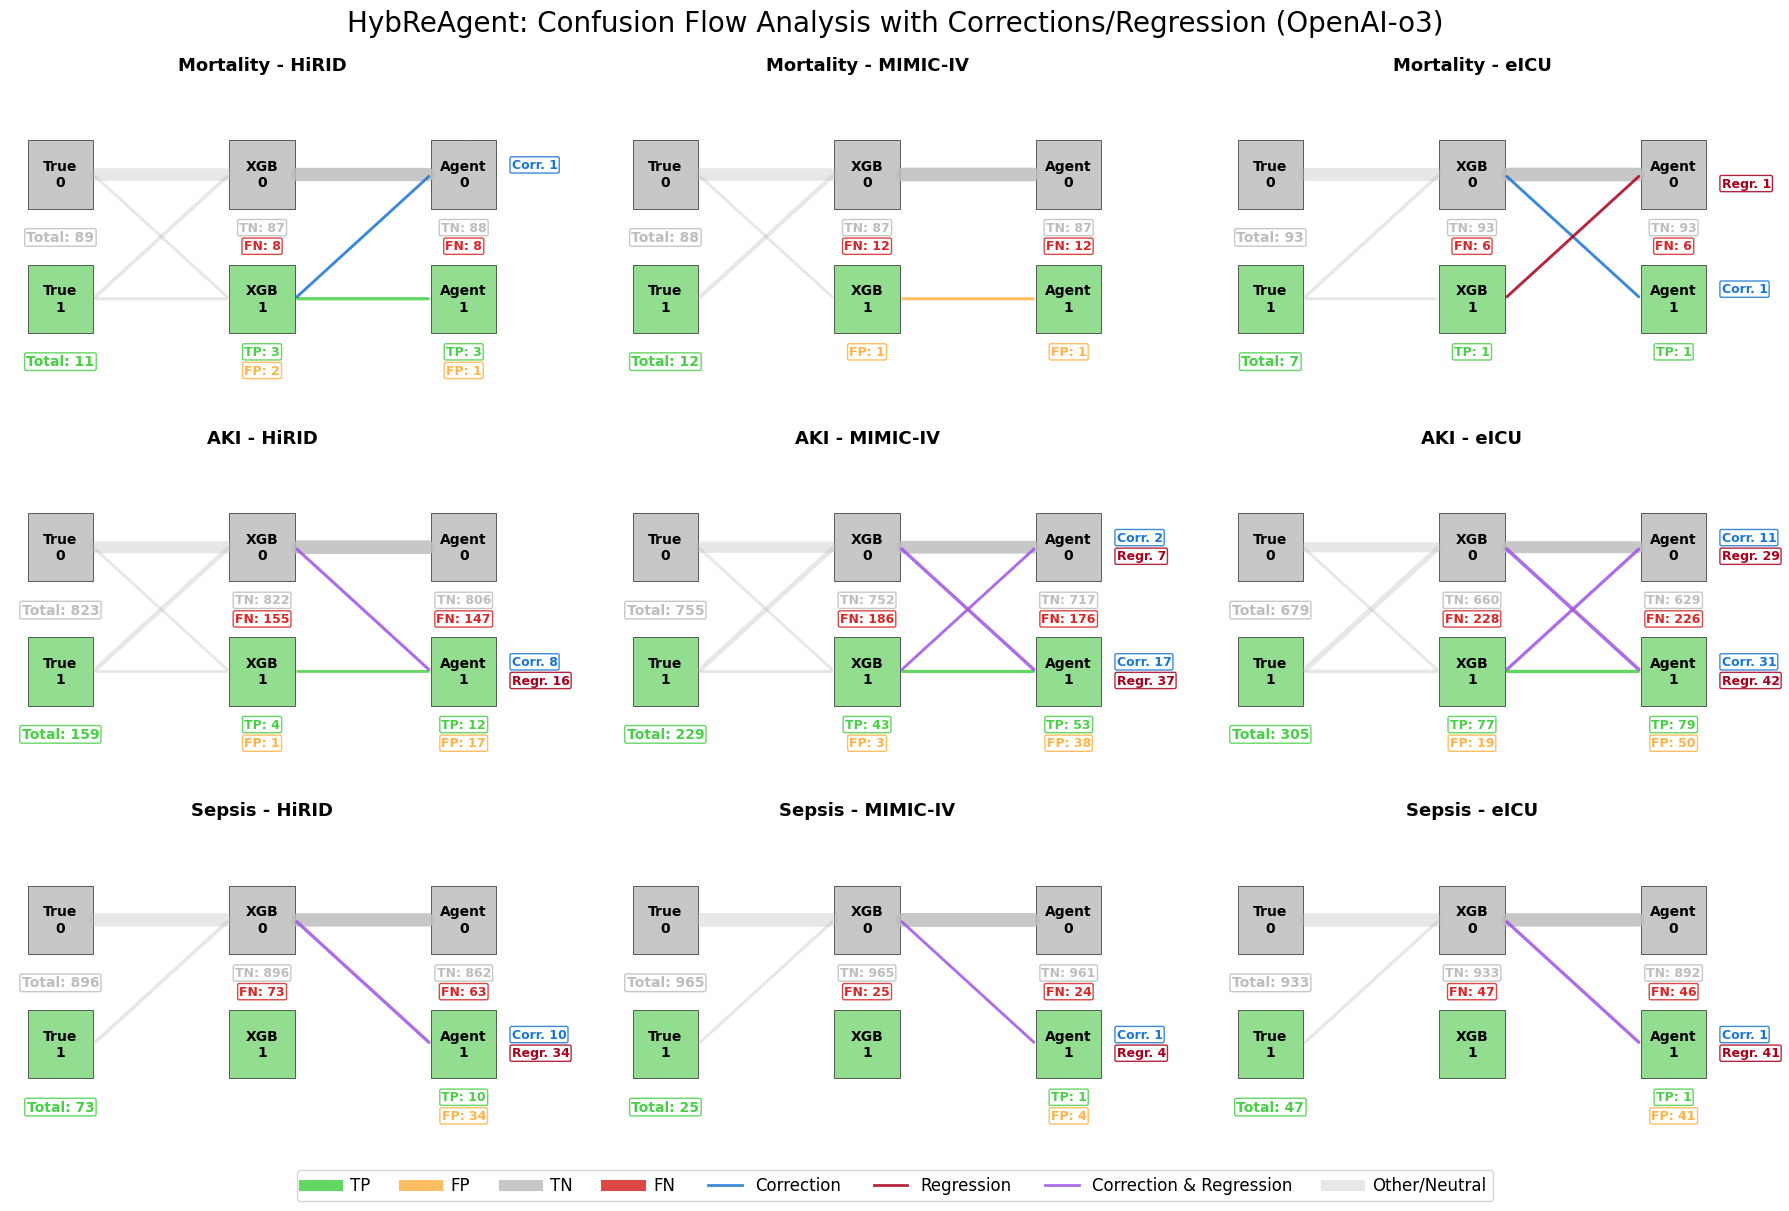

In [ ]:
def plot_static_confusion_sankey_grid(
    model_name,
    df=None,
    threshold=0.5,
    figsize=(18, 12),
    save_name=None,
):
    """
    3x3 grid of static Sankey-like diagrams for all task-dataset combinations,
    showing True → XGB → Agent, with TP/FP/TN/FN flows colored and annotated.
    Correction (blue) and regression (dark red) flows are annotated with counts.
    If both correction and regression occur for a flow, draw a single purple line and show both annotations near the Agent box.
    The annotation positioning is simple and can be changed via corr_offset and regr_offset.
    Now also annotates the total number of True 0 and True 1 underneath the respective boxes.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.patches import FancyArrowPatch, Rectangle

    if df is None:
        df = df_sample_evolution
    tasks = ["Mortality", "AKI", "Sepsis"]
    datasets = ["HiRID", "MIMIC-IV", "eICU"]

    # Node positions
    node_x = [0.1, 0.5, 0.9]
    node_y = {0: 0.7, 1: 0.3}
    node_width = 0.13
    node_height = 0.22

    # Colors
    color_tp = "#49cf47"
    color_fp = "#ffb347"
    color_tn = "#bdbdbd"
    color_fn = "#d62728"
    color_neutral = "#bbbbbb"
    color_correction = "#1976d2"  # blue
    color_regression = "#a8001c"  # dark red
    color_both = "#9e54e2"  # purple

    fig, axes = plt.subplots(3, 3, figsize=figsize)
    fig.suptitle(
        f"HybReAgent: Confusion Flow Analysis with Corrections/Regression ({model_name})",
        fontsize=20,
        y=0.98,  # Reduced space between title and grid
    )

    for i, task in enumerate(tasks):
        for j, dataset in enumerate(datasets):
            ax = axes[i, j]
            sub = df[
                (df["model"] == model_name)
                & (df["task"] == task)
                & (df["dataset"] == dataset)
                & df["step0_ml_prediction"].notna()
                & df["final_prediction"].notna()
                & df["label"].notna()
            ].copy()
            if len(sub) == 0:
                ax.text(
                    0.5,
                    0.5,
                    f"No data\n{task}-{dataset}",
                    ha="center",
                    va="center",
                    fontsize=12,
                )
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(
                    f"{task} - {dataset}", fontsize=14, fontweight="bold", pad=0
                )
                ax.axis("off")
                continue

            sub["true_label"] = sub["label"].astype(int)
            sub["xgb_pred"] = (sub["step0_ml_prediction"] >= threshold).astype(int)
            sub["agent_pred"] = (sub["final_prediction"] >= threshold).astype(int)

            # Correction/regression logic
            sub["xgb_correct"] = sub["xgb_pred"] == sub["true_label"]
            sub["agent_correct"] = sub["agent_pred"] == sub["true_label"]
            sub["correction"] = (~sub["xgb_correct"]) & (sub["agent_correct"])
            sub["regression"] = (sub["xgb_correct"]) & (~sub["agent_correct"])

            # Node drawing (labels: True, XGB, Agent)
            for col, label in zip([0, 1, 2], ["True", "XGB", "Agent"]):
                for val in [0, 1]:
                    x = node_x[col]
                    y = node_y[val]
                    color = color_tn if val == 0 else "#80d77e"  # green for True 1
                    rect = Rectangle(
                        (x - node_width / 2, y - node_height / 2),
                        node_width,
                        node_height,
                        color=color,
                        alpha=0.85,
                        ec="black",
                        lw=0.5,
                        zorder=2,
                    )
                    ax.add_patch(rect)
                    ax.text(
                        x,
                        y,
                        f"{label}\n{val}",
                        ha="center",
                        va="center",
                        fontsize=10,
                        fontweight="bold",
                        color="black",
                        zorder=3,
                    )

            # --- Add total True 0 and True 1 annotations under the True boxes ---
            for val in [0, 1]:
                x = node_x[0]
                y = node_y[val] - node_height / 2 - 0.07
                n_true = (sub["true_label"] == val).sum()
                ax.text(
                    x,
                    y,
                    f"Total: {n_true}",
                    ha="center",
                    va="top",
                    fontsize=10,
                    fontweight="bold",
                    color=color_tn if val == 0 else color_tp,
                    bbox=dict(
                        facecolor="white",
                        alpha=0.85,
                        edgecolor=color_tn if val == 0 else color_tp,
                        boxstyle="round,pad=0.13",
                    ),
                    zorder=10,
                )

            # Place TP/FP/TN/FN annotations beneath XGB and Agent boxes
            for col, pred_col, label in [
                (1, "xgb_pred", "XGB"),
                (2, "agent_pred", "Agent"),
            ]:
                for val in [0, 1]:
                    x = node_x[col]
                    y = node_y[val] - node_height / 2 - 0.04
                    if val == 1:
                        tp = ((sub[pred_col] == 1) & (sub["true_label"] == 1)).sum()
                        fp = ((sub[pred_col] == 1) & (sub["true_label"] == 0)).sum()
                        if tp > 0:
                            ax.text(
                                x,
                                y,
                                f"TP: {tp}",
                                ha="center",
                                va="top",
                                fontsize=9,
                                fontweight="bold",
                                color=color_tp,
                                bbox=dict(
                                    facecolor="white",
                                    alpha=0.85,
                                    edgecolor=color_tp,
                                    boxstyle="round,pad=0.13",
                                ),
                                zorder=10,
                            )
                            y -= 0.06
                        if fp > 0:
                            ax.text(
                                x,
                                y,
                                f"FP: {fp}",
                                ha="center",
                                va="top",
                                fontsize=9,
                                fontweight="bold",
                                color=color_fp,
                                bbox=dict(
                                    facecolor="white",
                                    alpha=0.85,
                                    edgecolor=color_fp,
                                    boxstyle="round,pad=0.13",
                                ),
                                zorder=10,
                            )
                    else:
                        tn = ((sub[pred_col] == 0) & (sub["true_label"] == 0)).sum()
                        fn = ((sub[pred_col] == 0) & (sub["true_label"] == 1)).sum()
                        if tn > 0:
                            ax.text(
                                x,
                                y,
                                f"TN: {tn}",
                                ha="center",
                                va="top",
                                fontsize=9,
                                fontweight="bold",
                                color=color_tn,
                                bbox=dict(
                                    facecolor="white",
                                    alpha=0.85,
                                    edgecolor=color_tn,
                                    boxstyle="round,pad=0.13",
                                ),
                                zorder=10,
                            )
                            y -= 0.06
                        if fn > 0:
                            ax.text(
                                x,
                                y,
                                f"FN: {fn}",
                                ha="center",
                                va="top",
                                fontsize=9,
                                fontweight="bold",
                                color=color_fn,
                                bbox=dict(
                                    facecolor="white",
                                    alpha=0.85,
                                    edgecolor=color_fn,
                                    boxstyle="round,pad=0.13",
                                ),
                                zorder=10,
                            )

            # Flows: True → XGB (neutral color)
            flows1 = (
                sub.groupby(["true_label", "xgb_pred"]).size().reset_index(name="count")
            )
            total = len(sub)
            for _, row in flows1.iterrows():
                src = row["true_label"]
                tgt = row["xgb_pred"]
                count = row["count"]
                x0, y0 = node_x[0] + node_width / 2, node_y[src]
                x1, y1 = node_x[1] - node_width / 2, node_y[tgt]
                width = 2 + 8 * (count / total)
                ax.add_patch(
                    FancyArrowPatch(
                        (x0, y0),
                        (x1, y1),
                        connectionstyle="arc3,rad=0.0",
                        arrowstyle="-",
                        lw=width,
                        color=color_neutral,
                        alpha=0.35,
                        zorder=2,
                    )
                )

            # Flows: XGB → Agent, color by correction/regression, with annotation
            flows2 = (
                sub.groupby(["xgb_pred", "agent_pred", "true_label"])
                .size()
                .reset_index(name="count")
            )
            # Aggregate corrections and regressions by (src, tgt)
            flow_corr = sub.groupby(["xgb_pred", "agent_pred"])["correction"].sum()
            flow_reg = sub.groupby(["xgb_pred", "agent_pred"])["regression"].sum()
            for (src, tgt), _ in sub.groupby(["xgb_pred", "agent_pred"]):
                # Get total count for this flow (all true labels)
                mask = (sub["xgb_pred"] == src) & (sub["agent_pred"] == tgt)
                count = mask.sum()
                x0, y0 = node_x[1] + node_width / 2, node_y[src]
                x1, y1 = node_x[2] - node_width / 2, node_y[tgt]
                width = 2 + 8 * (count / total) if total else 2
                n_corr = flow_corr.get((src, tgt), 0)
                n_reg = flow_reg.get((src, tgt), 0)
                # Decide color for the line
                if n_corr > 0 and n_reg > 0:
                    color = color_both
                    zorder = 20
                elif n_corr > 0:
                    color = color_correction
                    zorder = 10
                elif n_reg > 0:
                    color = color_regression
                    zorder = 10
                else:
                    # Default to confusion color (use majority true_label for this flow)
                    true_label_mode = sub.loc[mask, "true_label"].mode()
                    if not true_label_mode.empty:
                        label = true_label_mode.iloc[0]
                        if tgt == 1 and label == 1:
                            color = color_tp
                        elif tgt == 1 and label == 0:
                            color = color_fp
                        elif tgt == 0 and label == 0:
                            color = color_tn
                        elif tgt == 0 and label == 1:
                            color = color_fn
                        else:
                            color = color_neutral
                    else:
                        color = color_neutral
                    zorder = 3
                ax.add_patch(
                    FancyArrowPatch(
                        (x0, y0),
                        (x1, y1),
                        connectionstyle="arc3,rad=0.0",
                        arrowstyle="-",
                        lw=width,
                        color=color,
                        alpha=0.85,
                        zorder=zorder,
                    )
                )
                # Annotation positions: all on the same vertical line (ann_x)
                ann_x = node_x[2] + node_width / 2 + 0.03
                ann_y_corr = y1 + 0.01
                ann_y_regr = y1 - 0.05
                # Correction annotation
                if n_corr > 0:
                    ax.text(
                        ann_x,
                        ann_y_corr,
                        f"Corr. {int(n_corr)}",
                        ha="left",
                        va="bottom",
                        fontsize=9,
                        color=color_correction,
                        fontweight="bold",
                        bbox=dict(
                            facecolor="white",
                            alpha=0.85,
                            edgecolor=color_correction,
                            boxstyle="round,pad=0.13",
                        ),
                        zorder=30,
                    )
                # Regression annotation
                if n_reg > 0:
                    ax.text(
                        ann_x,
                        ann_y_regr,
                        f"Regr. {int(n_reg)}",
                        ha="left",
                        va="bottom",
                        fontsize=9,
                        color=color_regression,
                        fontweight="bold",
                        bbox=dict(
                            facecolor="white",
                            alpha=0.85,
                            edgecolor=color_regression,
                            boxstyle="round,pad=0.13",
                        ),
                        zorder=30,
                    )

            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.axis("off")
            ax.set_title(f"{task} - {dataset}", fontsize=13, fontweight="bold", pad=8)

    # Legend
    legend_elements = [
        plt.Line2D([0], [0], color=color_tp, lw=8, label="TP", alpha=0.85),
        plt.Line2D([0], [0], color=color_fp, lw=8, label="FP", alpha=0.85),
        plt.Line2D([0], [0], color=color_tn, lw=8, label="TN", alpha=0.85),
        plt.Line2D([0], [0], color=color_fn, lw=8, label="FN", alpha=0.85),
        plt.Line2D(
            [0], [0], color=color_correction, lw=2, label="Correction", alpha=0.85
        ),
        plt.Line2D(
            [0], [0], color=color_regression, lw=2, label="Regression", alpha=0.85
        ),
        plt.Line2D(
            [0],
            [0],
            color=color_both,
            lw=2,
            label="Correction & Regression",
            alpha=0.85,
        ),
        plt.Line2D(
            [0], [0], color=color_neutral, lw=8, label="Other/Neutral", alpha=0.35
        ),
    ]
    fig.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.02),
        ncol=8,
        fontsize=12,
        frameon=True,
    )
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.04, wspace=0.2, hspace=0.2)
    save_path = os.path.join(
        OUTPUT_BASE_DIR, save_name
    )
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    print(f"Static confusion Sankey grid saved to:{save_path}")
    plt.show()


# Example usage:
plot_static_confusion_sankey_grid(
    "OpenAI-o3",
    figsize=(18, 12),
    save_name="static_confusion_sankey_grid_openaio3.png",
)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_colored_sankey_grid(model_name, df=None, threshold=0.5):
    """
    3x3 grid of Plotly Sankey diagrams (task x dataset) for a model,
    with colored flows for TP, FP, TN, FN.
    """
    if df is None:
        df = df_sample_evolution
    tasks = ["Mortality", "AKI", "Sepsis"]
    datasets = ["HiRID", "MIMIC-IV", "eICU"]

    # Colors for confusion matrix
    color_tp = "rgba(73,207,71,0.85)"   # green
    color_fp = "rgba(255,179,71,0.85)"  # orange
    color_tn = "rgba(189,189,189,0.85)" # gray
    color_fn = "rgba(214,39,40,0.85)"   # red
    color_neutral = "rgba(180,180,180,0.3)"

    fig = make_subplots(
        rows=3, cols=3,
        subplot_titles=[f"{t} - {d}" for t in tasks for d in datasets],
        specs=[[{"type": "domain"}]*3]*3,
        horizontal_spacing=0.05, vertical_spacing=0.08
    )

    for i, task in enumerate(tasks):
        for j, dataset in enumerate(datasets):
            sub = df[
                (df["model"] == model_name) &
                (df["task"] == task) &
                (df["dataset"] == dataset) &
                df["step0_ml_prediction"].notna() &
                df["final_prediction"].notna() &
                df["label"].notna()
            ].copy()
            if len(sub) == 0:
                continue

            sub["true_label"] = sub["label"].astype(int)
            sub["xgb_pred"] = (sub["step0_ml_prediction"] >= threshold).astype(int)
            sub["agent_pred"] = (sub["final_prediction"] >= threshold).astype(int)

            node_labels = [
                "True 0", "True 1",
                "XGB 0", "XGB 1",
                "Agent 0", "Agent 1"
            ]
            node_colors = [
                "#bdbdbd", "#49cf47",
                "#bdbdbd", "#49cf47",
                "#bdbdbd", "#49cf47"
            ]

            # Flows: True → XGB
            flows1 = sub.groupby(["true_label", "xgb_pred"]).size().reset_index(name="count")
            # Flows: XGB → Agent, color by confusion type
            flows2 = sub.groupby(["xgb_pred", "agent_pred", "true_label"]).size().reset_index(name="count")

            sources = []
            targets = []
            values = []
            colors = []

            # True → XGB (neutral color)
            for _, row in flows1.iterrows():
                src = row["true_label"]
                tgt = 2 + row["xgb_pred"]
                sources.append(src)
                targets.append(tgt)
                values.append(row["count"])
                colors.append(color_neutral)

            # XGB → Agent (color by confusion type)
            for _, row in flows2.iterrows():
                src = 2 + row["xgb_pred"]
                tgt = 4 + row["agent_pred"]
                label = row["true_label"]
                count = row["count"]
                sources.append(src)
                targets.append(tgt)
                values.append(count)
                # Confusion color
                if row["agent_pred"] == 1 and label == 1:
                    colors.append(color_tp)
                elif row["agent_pred"] == 1 and label == 0:
                    colors.append(color_fp)
                elif row["agent_pred"] == 0 and label == 0:
                    colors.append(color_tn)
                elif row["agent_pred"] == 0 and label == 1:
                    colors.append(color_fn)
                else:
                    colors.append(color_neutral)

            sankey = go.Sankey(
                node=dict(
                    pad=15,
                    thickness=18,
                    line=dict(color="black", width=0.5),
                    label=node_labels,
                    color=node_colors,
                ),
                link=dict(
                    source=sources,
                    target=targets,
                    value=values,
                    color=colors
                ),
                arrangement="snap"
            )

            fig.add_trace(sankey, row=i+1, col=j+1)

    fig.update_layout(
        height=1100, width=1600,
        title_text=f"Sankey Flow: True Label → XGBoost → Agent for {model_name} (TP/FP/TN/FN colors)",
        font_size=12,
        margin=dict(t=80, l=10, r=10, b=10)
    )
    fig.show()

# Example usage:
create_colored_sankey_grid("OpenAI-o3")

### Data Preparation for Clinician Validation

In [ ]:
def save_balanced_sample_csvs_for_openaio3(
    df,
    output_dir="./notebook_output/pulse_agents_hra/clinician_validation_samples",
    model_name="OpenAI-o3",
    n_per_group=25,
    random_state=42,
):
    """
    For each task-dataset combination, sample up to n_per_group sample_index for each of 4 groups:
      - agreement_group: correct_correct, correct_incorrect, incorrect_correct, incorrect_incorrect
      - sample_labels: "{xgb_pred}_{agent_pred}" (e.g., "0_0", "1_0", etc.)
    For each selected sample_index, save all rows (except Step Name == "SAMPLE_METADATA") to a CSV.
    Also, add columns for agreement_group, sample_labels, and group_sample_index (ascending per agreement_group).
    Print detailed statistics about the saved CSVs, including fractions of target labels per group.
    Now: Within each agreement_group, sample equally from each Target Label group if possible.
    """
    import os

    os.makedirs(output_dir, exist_ok=True)

    keep_cols = [
        "model_name",
        "prompting_id",
        "task",
        "dataset",
        "sample_index",
        "sex",
        "age",
        "height",
        "weight",
        "Target Label",
        "Step Name",
        "Step Number",
        "Predicted Probability",
        "Input Prompt",
        "Output",
    ]

    df_model = df[df["model_name"] == model_name].copy()
    df_model = df_model[df_model["Step Name"].str.lower() != "sample_metadata"]

    tasks = sorted(df_model["task"].unique())
    datasets = sorted(df_model["dataset"].unique())

    for task in tasks:
        for dataset in datasets:
            df_td = df_model[
                (df_model["task"] == task) & (df_model["dataset"] == dataset)
            ].copy()
            if df_td.empty:
                print(f"No data for {task}-{dataset}, skipping.")
                continue

            # Get step0 (XGB) and final (Agent) predictions
            step0 = df_td[
                df_td["Step Name"].str.lower().str.contains("ml_interpretation")
            ]
            final = df_td[
                df_td["Step Name"].str.lower().str.contains("final_prediction")
            ]

            step0_sel = step0[
                ["sample_index", "metadata_ml_prediction"]
            ].drop_duplicates("sample_index")
            final_sel = final[
                ["sample_index", "Predicted Probability"]
            ].drop_duplicates("sample_index")
            label_sel = final[["sample_index", "Target Label"]].drop_duplicates(
                "sample_index"
            )

            merged = pd.merge(
                step0_sel, final_sel, on="sample_index", suffixes=("_xgb", "_final")
            )
            merged = pd.merge(merged, label_sel, on="sample_index", how="left")

            # Convert to numeric
            merged["xgb_prob_01"] = (
                pd.to_numeric(merged["metadata_ml_prediction"], errors="coerce") / 100.0
            )
            merged["final_prob"] = pd.to_numeric(
                merged["Predicted Probability"], errors="coerce"
            )
            merged["target_label"] = pd.to_numeric(
                merged["Target Label"], errors="coerce"
            ).astype("Int64")

            # Compute predicted labels
            merged["xgb_pred"] = (merged["xgb_prob_01"] >= 0.5).astype(int)
            merged["agent_pred"] = (merged["final_prob"] >= 0.5).astype(int)

            # Compute correctness
            merged["xgb_correct"] = merged["xgb_pred"] == merged["target_label"]
            merged["agent_correct"] = merged["agent_pred"] == merged["target_label"]

            # Assign agreement_group
            def agreement_group_func(row):
                if row["xgb_correct"] and row["agent_correct"]:
                    return "correct_correct"
                elif row["xgb_correct"] and not row["agent_correct"]:
                    return "correct_incorrect"
                elif not row["xgb_correct"] and row["agent_correct"]:
                    return "incorrect_correct"
                else:
                    return "incorrect_incorrect"

            merged["agreement_group"] = merged.apply(agreement_group_func, axis=1)
            # Assign sample_labels as "{xgb_pred}_{agent_pred}"
            merged["sample_labels"] = (
                merged["xgb_pred"].astype(str) + "_" + merged["agent_pred"].astype(str)
            )

            # --- Balanced sampling by Target Label within each agreement_group ---
            agreement_groups = []
            idxs = []
            for group in [
                "correct_correct",
                "correct_incorrect",
                "incorrect_correct",
                "incorrect_incorrect",
            ]:
                group_df = merged[merged["agreement_group"] == group]
                if group_df.empty:
                    continue
                # Get all unique Target Labels in this group
                target_labels = group_df["target_label"].dropna().unique()
                n_per_label = (
                    max(1, n_per_group // len(target_labels))
                    if len(target_labels) > 0
                    else n_per_group
                )
                sampled_idxs = []
                for tlabel in target_labels:
                    group_t = group_df[group_df["target_label"] == tlabel]
                    n_sample = min(n_per_label, len(group_t))
                    sampled = group_t.sample(n=n_sample, random_state=random_state)
                    sampled_idxs.extend(sampled["sample_index"].tolist())
                    agreement_groups.extend([group] * len(sampled))
                # If we have less than n_per_group, try to fill up with random samples from the group (excluding already chosen)
                if len(sampled_idxs) < n_per_group:
                    remaining = group_df[~group_df["sample_index"].isin(sampled_idxs)]
                    n_fill = min(n_per_group - len(sampled_idxs), len(remaining))
                    if n_fill > 0:
                        fill_samples = remaining.sample(
                            n=n_fill, random_state=random_state
                        )
                        sampled_idxs.extend(fill_samples["sample_index"].tolist())
                        agreement_groups.extend([group] * len(fill_samples))
                idxs.extend(sampled_idxs)

            # Remove duplicate sample_index, keep first occurrence
            idxs_unique = []
            agreement_groups_unique = []
            seen = set()
            for idx, group in zip(idxs, agreement_groups):
                if idx not in seen:
                    idxs_unique.append(idx)
                    agreement_groups_unique.append(group)
                    seen.add(idx)
            idxs = idxs_unique
            agreement_groups = agreement_groups_unique

            # Build agreement_group and sample_labels mapping for each sample_index
            agreement_group_map = {
                idx: group for idx, group in zip(idxs, agreement_groups)
            }
            sample_labels_map = {
                idx: merged.loc[merged["sample_index"] == idx, "sample_labels"].iloc[0]
                for idx in idxs
            }

            df_selected = df_td[df_td["sample_index"].isin(idxs)][keep_cols].copy()

            xgb_prob_map = step0_sel.set_index("sample_index")[
                "metadata_ml_prediction"
            ].to_dict()
            df_selected["XGBoost_Probability"] = df_selected["sample_index"].map(
                xgb_prob_map
            )
            df_selected["agreement_group"] = df_selected["sample_index"].map(
                lambda x: agreement_group_map.get(x, "unknown")
            )
            df_selected["sample_labels"] = df_selected["sample_index"].map(
                lambda x: sample_labels_map.get(x, "unknown")
            )

            # Assign group_sample_index: for each agreement_group, enumerate unique sample_index
            df_selected["group_sample_index"] = -1  # placeholder
            for group in df_selected["agreement_group"].unique():
                sample_indices = (
                    df_selected[df_selected["agreement_group"] == group]["sample_index"]
                    .drop_duplicates()
                    .tolist()
                )
                sample_index_map = {
                    idx: i for i, idx in enumerate(sorted(sample_indices))
                }
                mask = df_selected["agreement_group"] == group
                df_selected.loc[mask, "group_sample_index"] = df_selected.loc[
                    mask, "sample_index"
                ].map(sample_index_map)

            df_selected["group_sample_index"] = df_selected[
                "group_sample_index"
            ].astype(int)

            # Move agreement_group, sample_labels, group_sample_index after 'dataset'
            cols = df_selected.columns.tolist()
            insert_at = cols.index("dataset") + 1
            for col in ["agreement_group", "sample_labels", "group_sample_index"]:
                cols.remove(col)
            cols = (
                cols[:insert_at]
                + ["agreement_group", "sample_labels", "group_sample_index"]
                + cols[insert_at:]
            )
            df_selected = df_selected[cols]

            # Sort by agreement_group and group_sample_index before saving
            df_selected = df_selected.sort_values(
                ["agreement_group", "group_sample_index"]
            ).reset_index(drop=True)

            fname = f"{model_name}_{task}_{dataset}_validation_samples.csv".replace(
                " ", "_"
            )
            out_path = os.path.join(output_dir, fname)
            df_selected.to_csv(out_path, index=False)
            print(f"Saved {len(df_selected)} rows for {task}-{dataset} to {out_path}")


def print_clinician_validation_csv_structure(
    output_dir="./notebook_output/pulse_agents_hybreagent/clinician_validation_samples",
    model_name="OpenAI-o3",
    tasks=None,
    datasets=None,
    n_per_group=25,
):
    """
    Print a detailed explanation of the CSV structure and summary statistics for clinician validation sample CSVs.
    """
    import glob
    import pandas as pd

    print("=" * 80)
    print("CLINICIAN VALIDATION SAMPLE CSV STRUCTURE AND SUMMARY")
    print("=" * 80)
    print("\nEach CSV contains one row per agent step for each selected sample_index.")
    print("Columns and their logic:\n")
    col_explanations = [
        ("model_name", "Name of the LLM model used (e.g., 'OpenAI-o3')."),
        (
            "prompting_id",
            "Prompting method used (should be 'HybReAgent' for these samples).",
        ),
        ("task", "Clinical prediction task (e.g., 'AKI', 'Mortality', 'Sepsis')."),
        ("dataset", "Dataset source (e.g., 'HiRID', 'MIMIC-IV', 'eICU')."),
        ("sample_index", "Unique identifier for the patient/sample."),
        ("sex", "Patient sex (e.g., 'Male', 'Female')."),
        ("age", "Patient age (years)."),
        ("height", "Patient height (cm)."),
        ("weight", "Patient weight (kg)."),
        (
            "Target Label",
            "Ground truth label for the clinical outcome (0 = negative, 1 = positive).",
        ),
        (
            "Step Name",
            "Name of the agent step (e.g., 'ML_Interpretation', 'Clinical_Assessment', 'Final_Prediction').",
        ),
        (
            "Step Number",
            "Order of the step in the agent workflow (integer, e.g., 1, 2, 3, 4).",
        ),
        (
            "Predicted Probability",
            "Agent's predicted probability for the outcome at this step (float, 0-1).",
        ),
        ("Input Prompt", "The prompt given to the LLM for this step."),
        ("Output", "The LLM's output for this step."),
        (
            "XGBoost_Probability",
            "XGBoost model's predicted probability (0-100 scale, repeated for all steps of the sample).",
        ),
        (
            "agreement_group",
            "Agreement type between XGBoost and agent vs ground truth (see below).",
        ),
        (
            "sample_labels",
            "String summarizing XGBoost and agent binary predictions (see below).",
        ),
        (
            "group_sample_index",
            "Index of the sample within its agreement_group (0-based, for easy reference).",
        ),
    ]
    # Print as a table
    df_cols = pd.DataFrame(col_explanations, columns=["Column", "Description"])
    print(df_cols.to_string(index=False))
    print("\n")

    print("Logic for agreement_group:")
    print(
        "  - correct_correct: Both XGBoost and agent are correct (match Target Label)"
    )
    print("  - correct_incorrect: XGBoost is correct, agent is incorrect (Regression)")
    print(
        "  - incorrect_correct: XGBoost is incorrect, agent is correct (agent 'corrected' XGBoost)"
    )
    print("  - incorrect_incorrect: Both XGBoost and agent are incorrect\n")

    print("Logic for sample_labels:")
    print(
        "  - Format: '{xgb_pred}_{agent_pred}' where each is 0 or 1 (binary prediction at threshold 0.5)"
    )
    print("  - Example: '0_1' means XGBoost predicted 0, agent predicted 1\n")

    print(
        "Each CSV contains up to {} samples per agreement_group, balanced by Target Label if possible.".format(
            n_per_group
        )
    )
    print("For each sample, all agent steps (except 'SAMPLE_METADATA') are included.\n")

    # Print summary statistics for each CSV
    csv_files = sorted(
        glob.glob(os.path.join(output_dir, f"{model_name}_*_validation_samples.csv"))
    )
    for csv_path in csv_files:
        print("=" * 60)
        print(f"File: {os.path.basename(csv_path)}")
        df = pd.read_csv(csv_path)
        # Group sizes (unique sample_index per agreement_group)
        group_counts = (
            df[["agreement_group", "sample_index"]]
            .drop_duplicates()
            .groupby("agreement_group")
            .size()
            .reset_index(name="n_samples")
        )
        # Target label distribution per group
        label_dist = (
            df[["agreement_group", "sample_index", "Target Label"]]
            .drop_duplicates()
            .groupby(["agreement_group", "Target Label"])
            .size()
            .reset_index(name="count")
        )
        # Pivot for table
        label_pivot = (
            label_dist.pivot(
                index="agreement_group", columns="Target Label", values="count"
            )
            .fillna(0)
            .astype(int)
        )
        label_pivot.columns = [f"Label {int(c)}" for c in label_pivot.columns]
        # sample_labels distribution
        sample_labels_dist = (
            df[["agreement_group", "sample_index", "sample_labels"]]
            .drop_duplicates()
            .groupby(["agreement_group", "sample_labels"])
            .size()
            .reset_index(name="count")
        )
        sample_labels_pivot = (
            sample_labels_dist.pivot(
                index="agreement_group", columns="sample_labels", values="count"
            )
            .fillna(0)
            .astype(int)
        )
        # Print tables
        print("\nSamples per agreement_group:")
        print(group_counts.to_string(index=False))
        print("\nTarget Label distribution per agreement_group:")
        print(label_pivot.to_string())
        print("\nsample_labels distribution per agreement_group:")
        print(sample_labels_pivot.to_string())
        print("-" * 60)
    print("\n")

# Call the function
save_balanced_sample_csvs_for_openaio3(df_metadata_hra)
print_clinician_validation_csv_structure()

Saved 271 rows for AKI-HiRID to ./notebook_output/pulse_agents_hra/clinician_validation_samples/OpenAI-o3_AKI_HiRID_validation_samples.csv
Saved 359 rows for AKI-MIMIC-IV to ./notebook_output/pulse_agents_hra/clinician_validation_samples/OpenAI-o3_AKI_MIMIC-IV_validation_samples.csv
Saved 387 rows for AKI-eICU to ./notebook_output/pulse_agents_hra/clinician_validation_samples/OpenAI-o3_AKI_eICU_validation_samples.csv
Saved 118 rows for Mortality-HiRID to ./notebook_output/pulse_agents_hra/clinician_validation_samples/OpenAI-o3_Mortality_HiRID_validation_samples.csv
Saved 124 rows for Mortality-MIMIC-IV to ./notebook_output/pulse_agents_hra/clinician_validation_samples/OpenAI-o3_Mortality_MIMIC-IV_validation_samples.csv
Saved 102 rows for Mortality-eICU to ./notebook_output/pulse_agents_hra/clinician_validation_samples/OpenAI-o3_Mortality_eICU_validation_samples.csv
Saved 294 rows for Sepsis-HiRID to ./notebook_output/pulse_agents_hra/clinician_validation_samples/OpenAI-o3_Sepsis_HiRID_